In [16]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines

In [17]:
data = '/Users/amyel/research/SMASH_project/datafiles/parsec_decamsdss_3.0gyr.fits.gz'
fx = fitsio.FITS(data)


In [18]:
fx


  file: /Users/amyel/research/SMASH_project/datafiles/parsec_decamsdss_3.0gyr.fits.gz
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      

In [19]:
objs = fx[1].read()

In [20]:
objs

array([(-2.3010302, 1.e-04, 3.e+09, 0.1       , 0.1  , -2.789, 3.5573,  5.409, 1., 0.   , 0.545,   0.  ,   0.  , -1.,  1.28e-16, 0., 0.7496, 0.2503, 1.798e-05, 4.851e-06, 4.400e-05, -1., 1.000e-04, 11.744, 16.138, 13.77 , 12.22 , 11.574, 11.284, 11.178, 17.454, 13.959, 12.347, 11.686, 11.322),
       (-2.3010302, 1.e-04, 3.e+09, 0.10982143, 0.109, -2.641, 3.5727,  5.36 , 1., 0.   , 0.545,   0.  ,   0.  , -1.,  1.82e-16, 0., 0.7491, 0.2508, 1.798e-05, 4.851e-06, 4.400e-05, -1., 9.996e-05, 11.371, 15.445, 13.203, 11.742, 11.186, 10.915, 10.815, 16.569, 13.374, 11.868, 11.28 , 10.95 ),
       (-2.3010302, 1.e-04, 3.e+09, 0.12946428, 0.129, -2.401, 3.5953,  5.284, 1., 0.   , 0.545,   0.  ,   0.  , -1.,  3.17e-16, 0., 0.7483, 0.2516, 1.798e-05, 4.851e-06, 4.400e-05, -1., 1.000e-04, 10.774, 14.108, 12.217, 10.984, 10.534, 10.294, 10.206, 14.766, 12.364, 11.097, 10.609, 10.326),
       ...,
       ( 0.1760912, 3.e-02, 3.e+09, 1.579558  , 0.609,  3.768, 3.5272, -0.485, 8., 0.569, 0.39 , 538.77

In [21]:
u_sdss = objs['SDSS_U']
g_sdss = objs['SDSS_G']
r_sdss = objs['SDSS_R']
i_sdss = objs['SDSS_I']
z_sdss = objs['SDSS_Z']
feh_sdss = objs['FEH']
u_g_sdss = u_sdss - g_sdss
g_r_sdss = g_sdss - r_sdss

In [22]:
ret = {}
xedge = {}
yedge = {}
bin = {}

In [23]:
#iso for isochrones
ret['iso'],xedge['iso'],yedge['iso'],bin['iso'] = stats.binned_statistic_2d(u_g_sdss,g_r_sdss,feh_sdss,'median',50)

/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5,1,'Originao Isochrone Data')

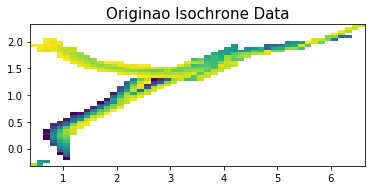

In [24]:
plt.imshow(ret['iso'].T,origin='lower',extent=[xedge['iso'].min(),xedge['iso'].max(),yedge['iso'].min(),yedge['iso'].max()])
plt.title('Original Isochrone Data',fontsize=15)


In [25]:
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [26]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

In [27]:
ret['original'],xedge['original'],yedge['original'],bin['original'] = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)

/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5,1,'Original Calibration Data')

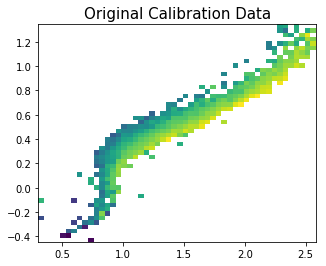

In [28]:
plt.imshow(ret['original'].T,origin='lower',extent=[xedge['original'].min(),xedge['original'].max(),yedge['original'].min(),yedge['original'].max()])
plt.title('Original Calibration Data',fontsize=15)


### Make cuts to isochrone data so we can subtract them 

In [29]:
selected = np.where((u_g_sdss >= u_g_cal.min()) & (u_g_sdss <= u_g_cal.max()) & (g_r_sdss >= g_r_cal.min()) & (g_r_sdss <= g_r_cal.max()))
u_g_sdss = u_g_sdss[selected]
g_r_sdss = g_r_sdss[selected]
feh_sdss = feh_sdss[selected]

                    

In [30]:
#iso for isochrones
ret['iso_cut'],xedge['iso_cut'],yedge['iso_cut'],bin['iso_cut'] = stats.binned_statistic_2d(u_g_sdss,g_r_sdss,feh_sdss,'median',50)

/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5,1,'Isochrone Data with Color Cuts')

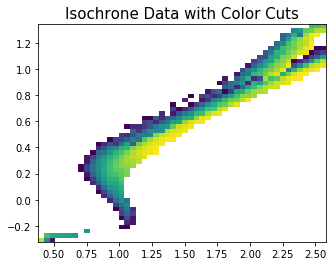

In [31]:
plt.imshow(ret['iso_cut'].T,origin='lower',extent=[xedge['iso_cut'].min(),xedge['iso_cut'].max(),yedge['iso_cut'].min(),yedge['iso_cut'].max()])
plt.title('Isochrone Data with Color Cuts',fontsize=15)



In [114]:
#ret['sub'] = ret['original']-ret['iso_cut']
xedge['sub'] = xedge['original']-xedge['iso_cut']
yedge['sub'] = yedge['original']-yedge['iso_cut']

In [115]:
ret['shift'] = ret['iso_cut'] 
xedge['shift'] = xedge['iso_cut'] + xedge['sub']
yedge['shift'] = yedge['iso_cut'] + yedge['sub']

Text(0.5,1,'Isochrone Data with Shift Applied')

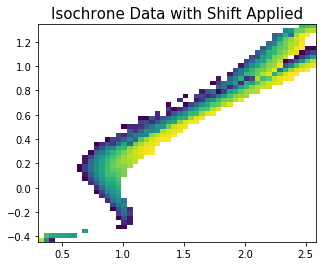

In [116]:
plt.imshow(ret['shift'].T,origin='lower',extent=[xedge['shift'].min(),xedge['shift'].max(),yedge['shift'].min(),yedge['shift'].max()])
plt.title('Isochrone Data with Shift Applied',fontsize=15)





In [274]:
fields = [1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 42, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 68, 149, 150, 156, 176, 177, 178, 246]
fields = np.array(fields)

In [275]:
len(fields)

59

In [276]:
good_index = np.where((fields!=50)&(fields!=35)&(fields!=30)&(fields!=42)&(fields!=48))

In [277]:
good_index

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 29, 30, 32, 33, 35, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
        56, 57, 58]),)

In [278]:
fields = fields[good_index]

In [279]:
len(fields)

54

### Now, calculate metallicity for original calibration, for original isochrone data, cut isochrone data, and shifted isochrone data

In [396]:
std = {}
metal = {}
error = {}
for i, method in enumerate(('original','iso','iso_cut','shift')):
    metal[method] = []
    std[method] = []
    error[method] = []

In [397]:
#for density plots
from scipy.stats import kde
xx_cal, yy_cal = np.mgrid[u_g_cal.min():u_g_cal.max():1000j, g_r_cal.min():g_r_cal.max():1000j]
positions = np.vstack([xx_cal.ravel(), yy_cal.ravel()])
values = np.vstack([u_g_cal, g_r_cal])
k_cal = kde.gaussian_kde(values)

In [177]:
zz_cal = np.reshape(k_cal(positions).T, xx_cal.shape)

In [398]:
import matplotlib.colors as clr

In [399]:

#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    #initial_stars.append(len(objs_new))
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.9)&(g<=22.8)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    fig, ax = plt.subplots(figsize=(10,5))
    hess = stats.binned_statistic_2d(u_g, g_r, None, 'count',bins=1000)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='bone',norm=clr.LogNorm())
    ax.contour(xx_cal,yy_cal,zz_cal,cmap='spring')
    cb = fig.colorbar(im,ax=ax,label='count in bin')
    ax.set_xlim(-.5,2.7)
    ax.set_ylim(-.5,1.6)
    ax.set_xlabel('u-g')
    ax.set_ylabel('g-r')
    ax.set_title('Density Plot of SMASH Field '+str(field_number[0])+' with Contours of SMASH Calibration Data Overlaid')
    
    plt.show(block=False)
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    #cut_stars.append(len(u))
    stars = len(u)
    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('original','shift')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        N = np.count_nonzero(~np.isnan(feh))
        metal[method].append(np.nanmedian(feh))
        print("metallicity for "+method+" method:",(np.nanmean(feh)))
        std[method].append(np.nanstd(feh))
        error[method].append((np.nanstd(feh))/np.sqrt(N))
        fig,ax = plt.subplots(figsize=(10,5))
        ax.hist(feh[~np.isnan(feh)],bins=20)
        ax.set_title('histogram of Fe/H for method '+method+' and field '+str(field_number[0]),fontsize=15)
        plt.show(block=False)
    
    
    return 0


number of initial stars in field 1: 46634


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


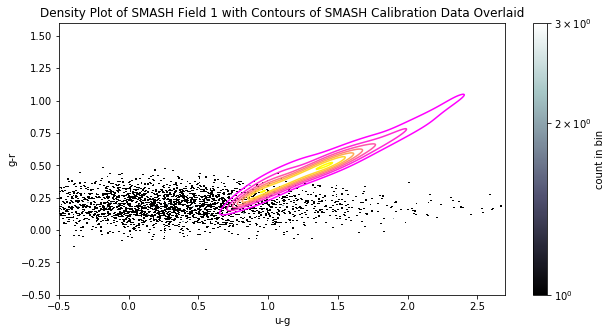

number of stars after cuts in field 1: 2849
metallicity for original method: -1.1979015532135964


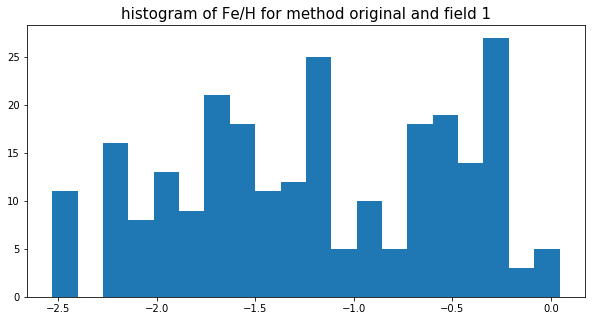

metallicity for shift method: -1.0611269238554402


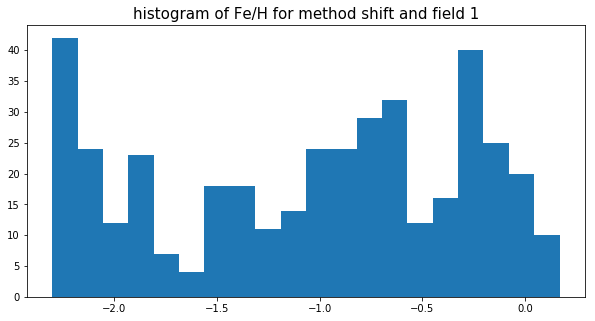

number of initial stars in field 2: 61991


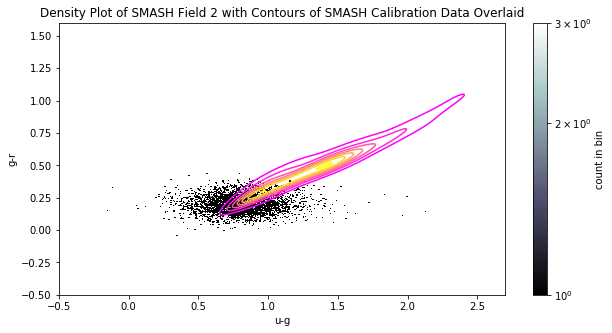

number of stars after cuts in field 2: 3435
metallicity for original method: -1.3346915160917907


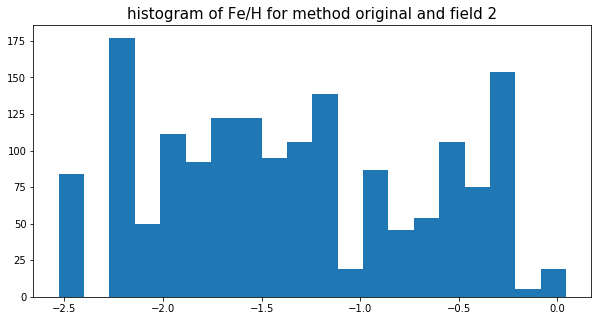

metallicity for shift method: -0.9714396842350121


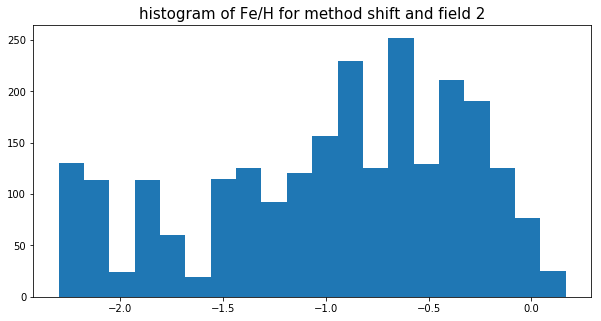

number of initial stars in field 3: 847797


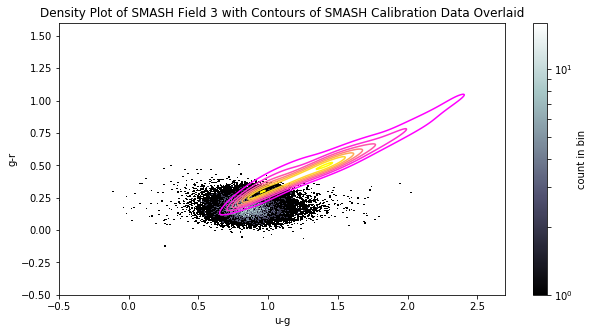

number of stars after cuts in field 3: 65489
metallicity for original method: -1.35108575487912


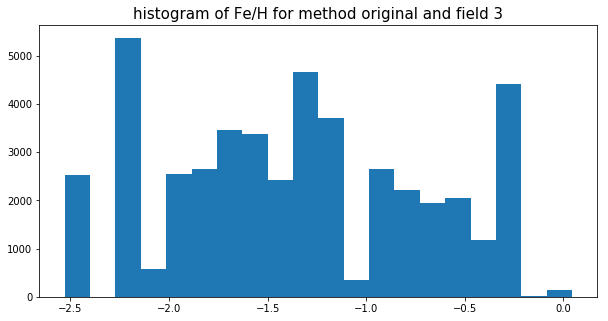

metallicity for shift method: -0.8369528242683003


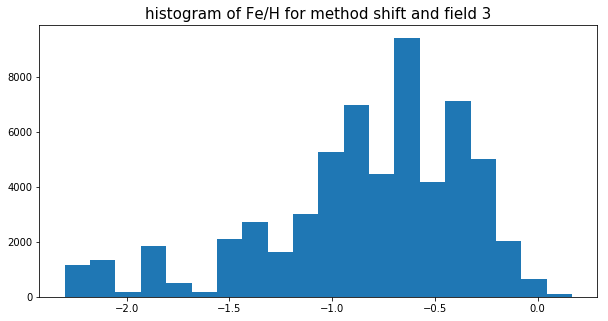

number of initial stars in field 4: 640420


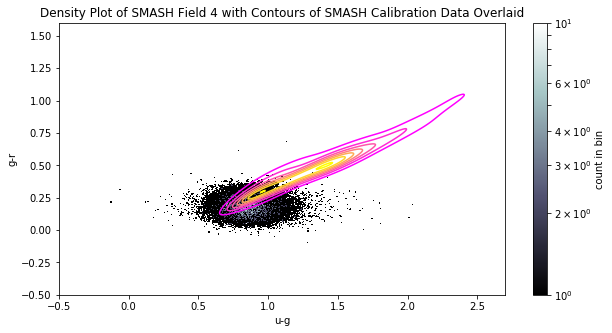

number of stars after cuts in field 4: 54416
metallicity for original method: -1.3743042049420737


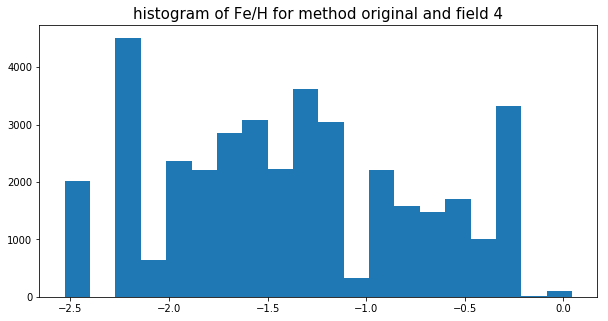

metallicity for shift method: -0.8605600098616004


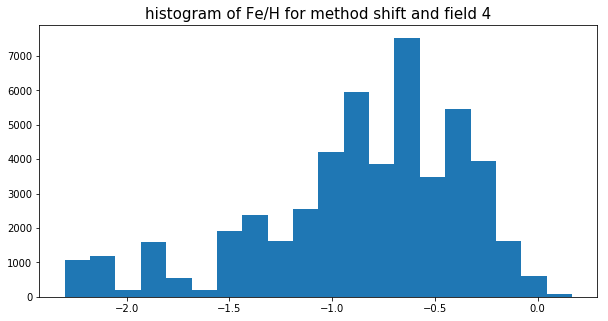

number of initial stars in field 5: 1048414


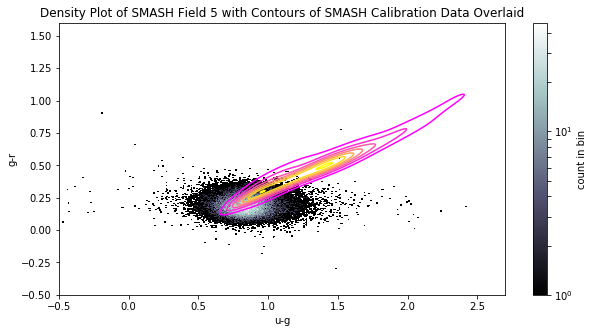

number of stars after cuts in field 5: 92611
metallicity for original method: -1.4395728897074516


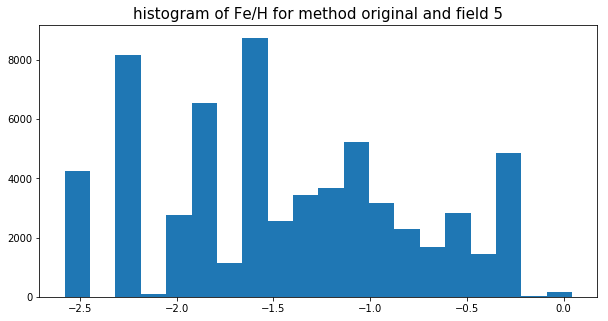

metallicity for shift method: -0.9019394858083584


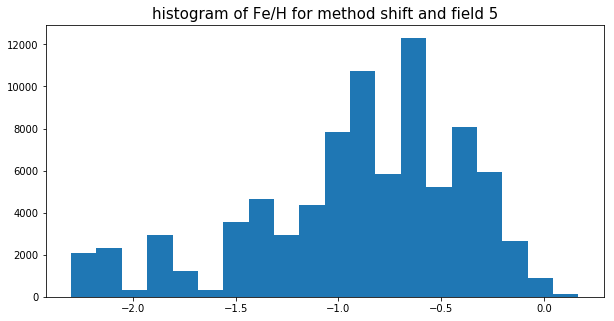

number of initial stars in field 7: 1201514


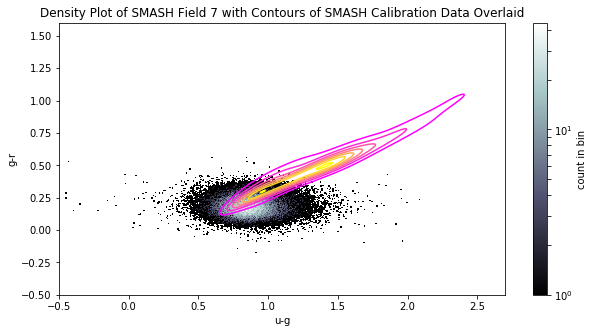

number of stars after cuts in field 7: 146618
metallicity for original method: -1.36376450476001


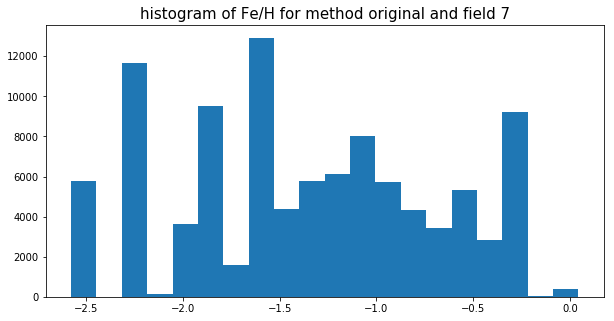

metallicity for shift method: -0.8537345776062535


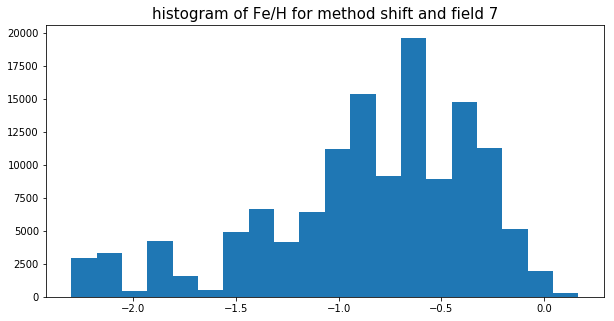

number of initial stars in field 8: 53873


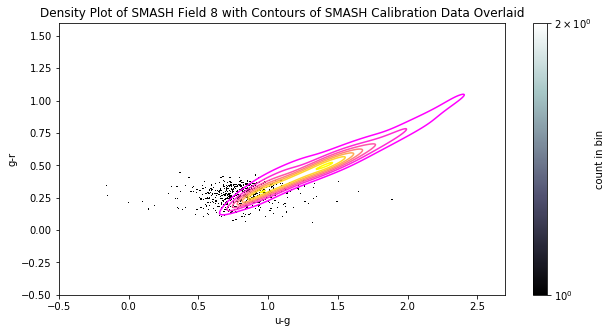

number of stars after cuts in field 8: 625
metallicity for original method: -1.5288815854011841


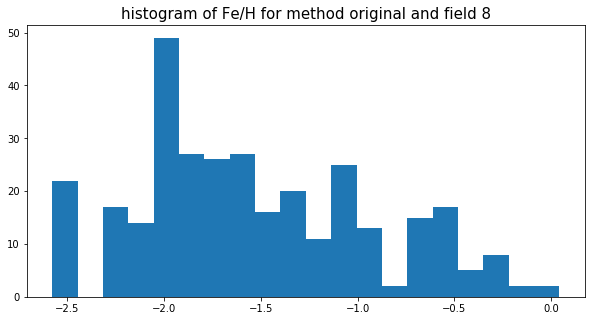

metallicity for shift method: -1.1516919455506132


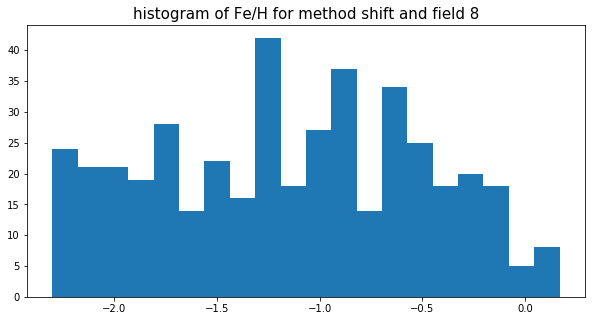

number of initial stars in field 9: 723837


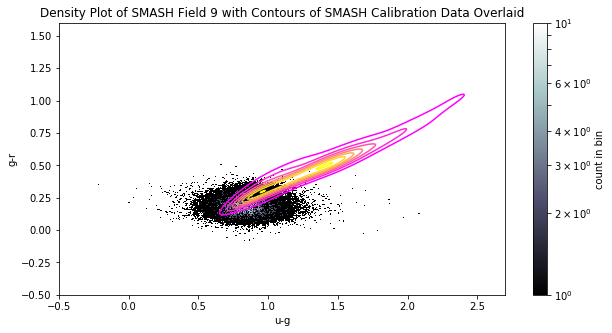

number of stars after cuts in field 9: 75346
metallicity for original method: -1.4251820191119817


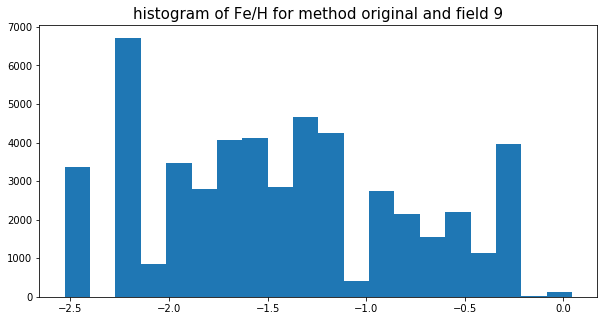

metallicity for shift method: -0.9003215369814204


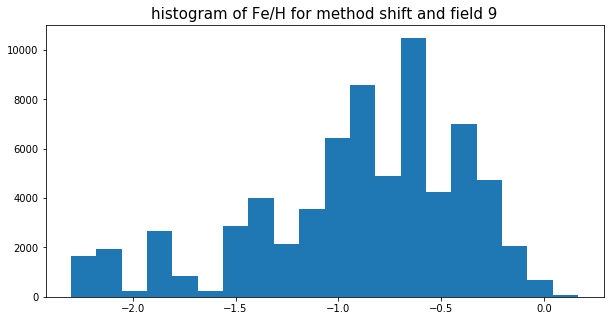

number of initial stars in field 12: 515707


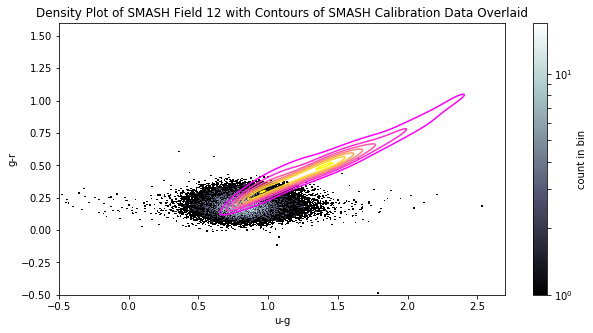

number of stars after cuts in field 12: 64007
metallicity for original method: -1.4174953633367169


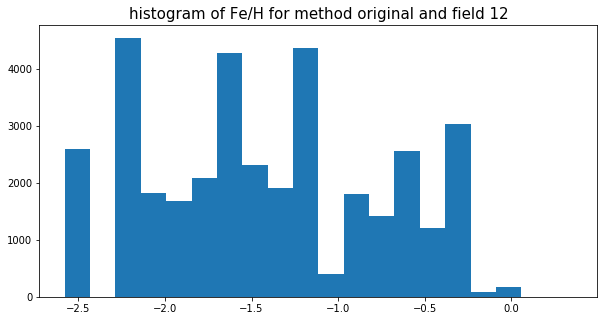

metallicity for shift method: -0.9758144703537132


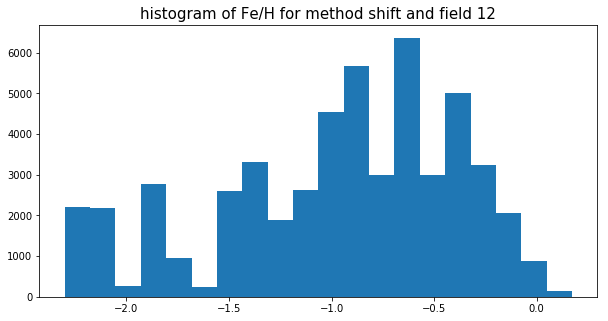

number of initial stars in field 13: 80790


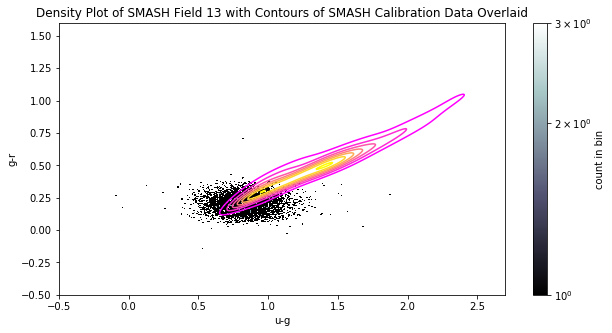

number of stars after cuts in field 13: 4344
metallicity for original method: -1.402487589728392


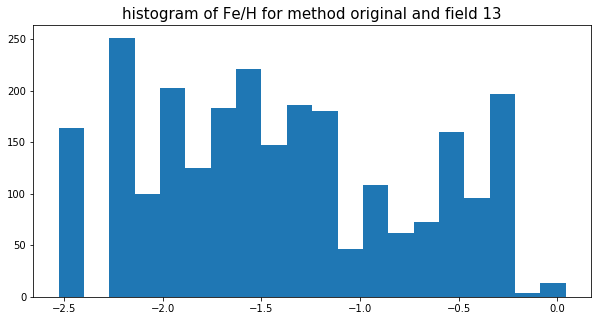

metallicity for shift method: -0.9631800589632036


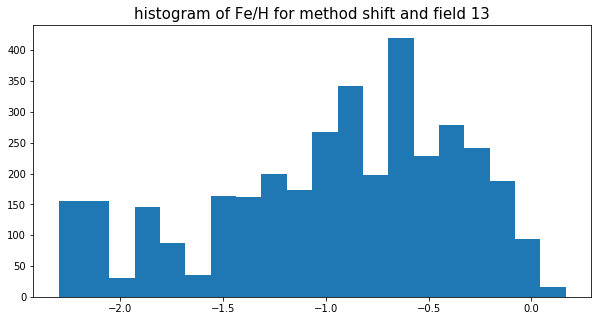

number of initial stars in field 14: 776768


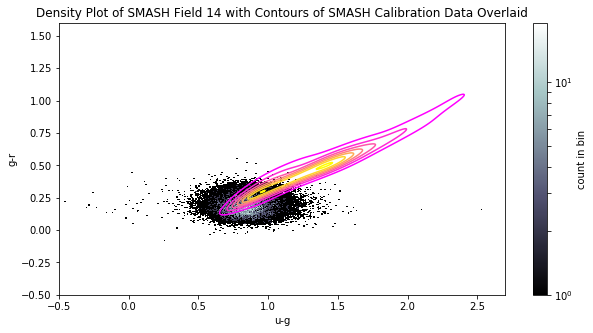

number of stars after cuts in field 14: 85748
metallicity for original method: -1.418008371895485


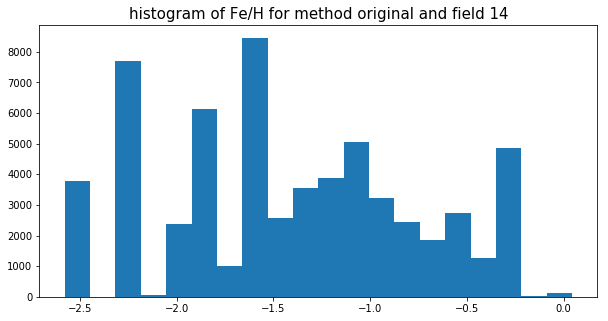

metallicity for shift method: -0.8741396362454844


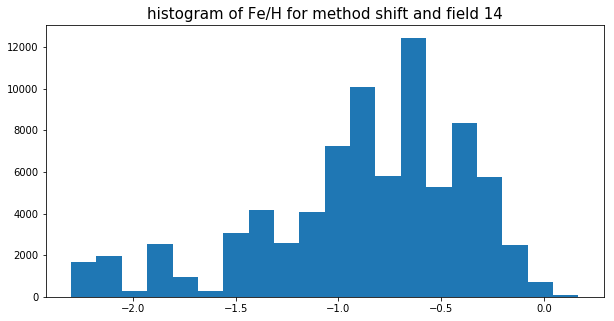

number of initial stars in field 15: 755871


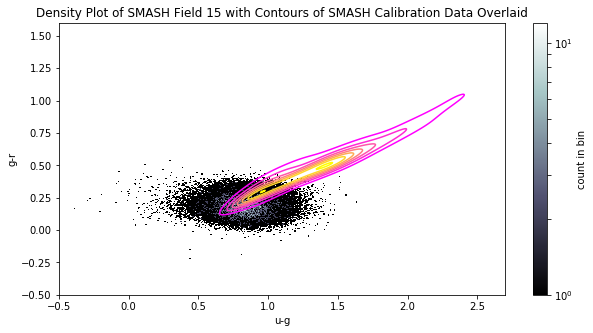

number of stars after cuts in field 15: 66660
metallicity for original method: -1.3754378535805696


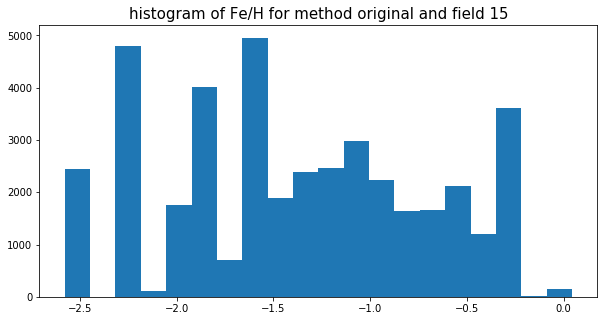

metallicity for shift method: -0.9225836579533168


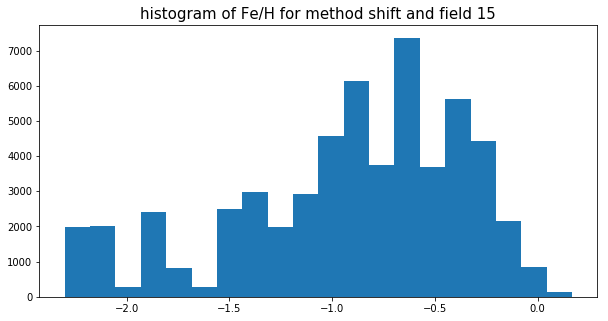

number of initial stars in field 16: 402062


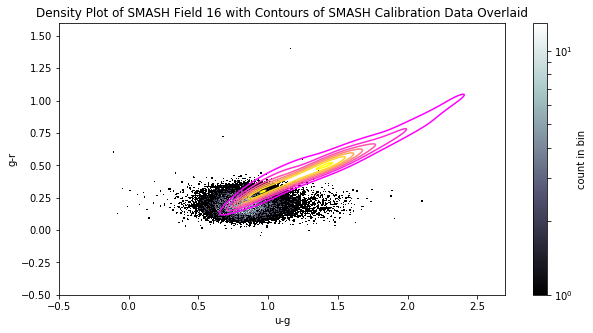

number of stars after cuts in field 16: 40929
metallicity for original method: -1.425718670038672


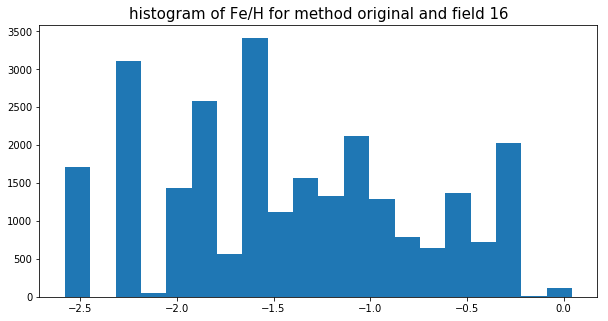

metallicity for shift method: -0.9304885466470668


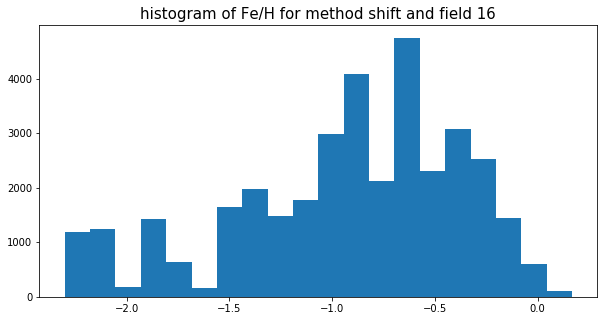

number of initial stars in field 18: 77413


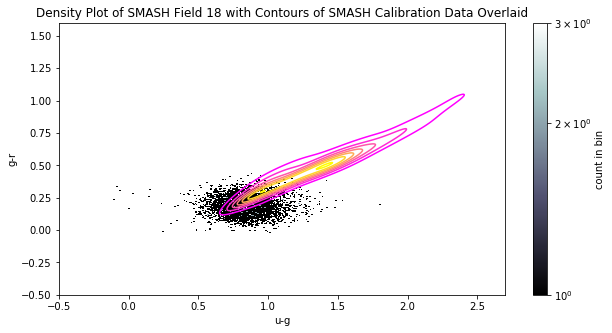

number of stars after cuts in field 18: 5585
metallicity for original method: -1.410409258909321


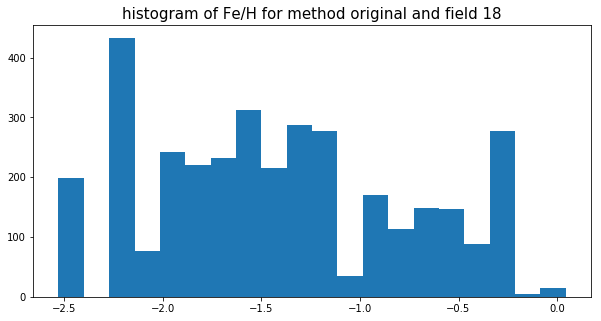

metallicity for shift method: -0.9509734941316585


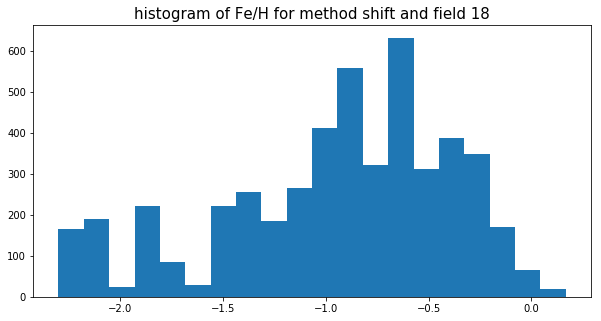

number of initial stars in field 19: 43871


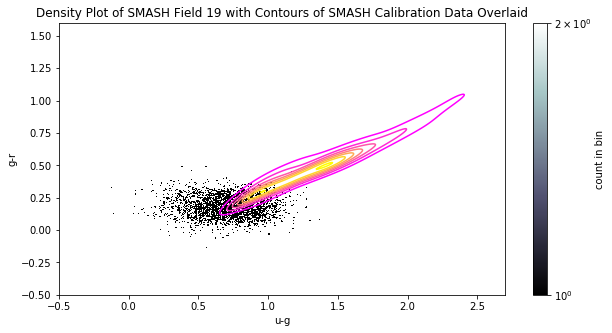

number of stars after cuts in field 19: 2830
metallicity for original method: -1.4177740116154625


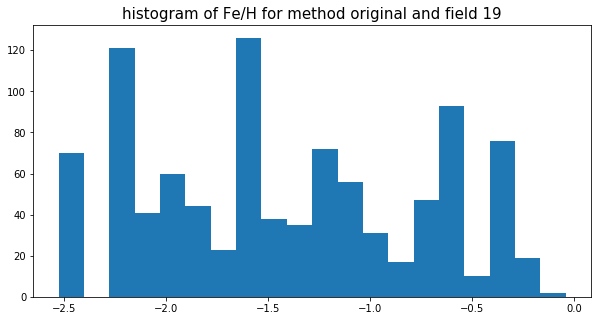

metallicity for shift method: -1.1309382018634933


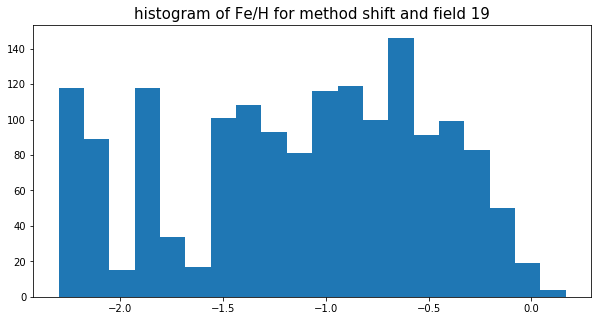

number of initial stars in field 20: 42362


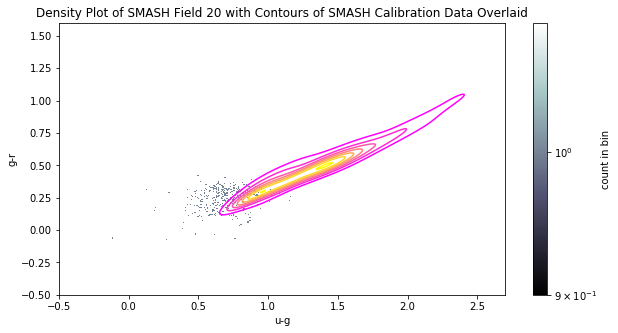

number of stars after cuts in field 20: 379
metallicity for original method: -1.6994287712233407


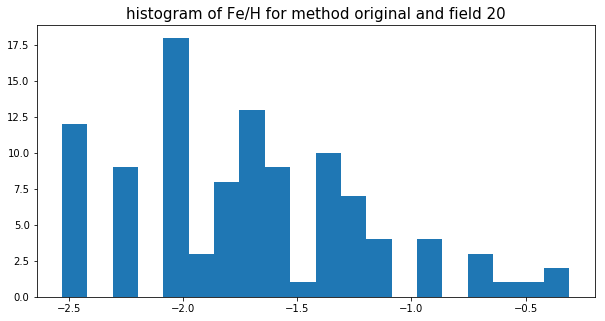

metallicity for shift method: -1.3828156996019108


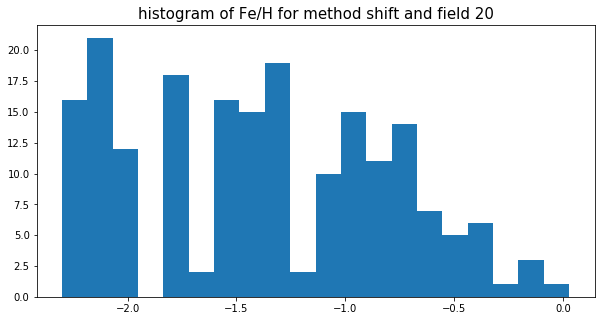

number of initial stars in field 21: 46188


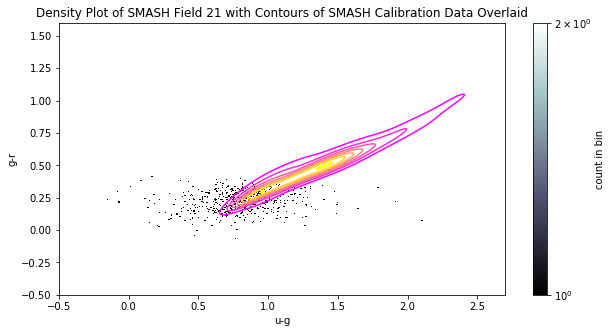

number of stars after cuts in field 21: 551
metallicity for original method: -1.3518786230124533


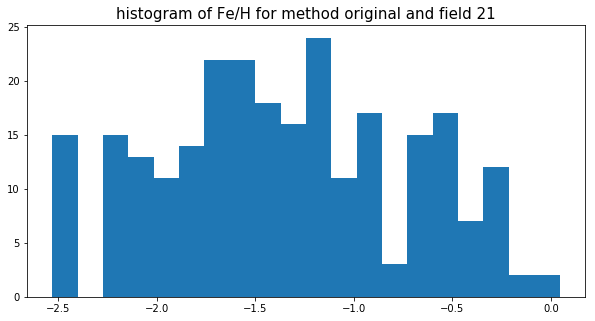

metallicity for shift method: -0.9596749129281803


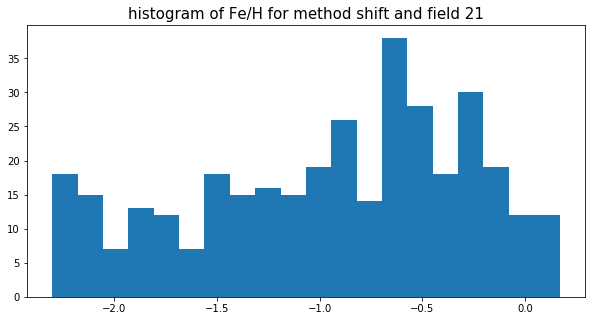

number of initial stars in field 22: 59954


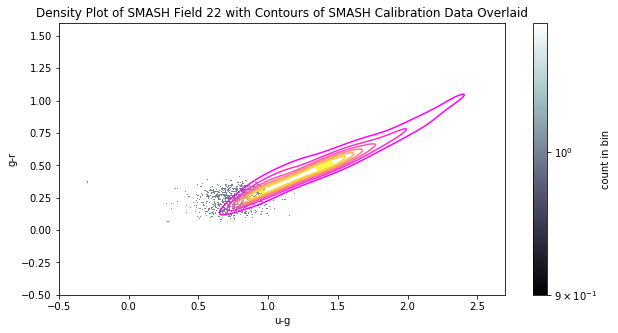

number of stars after cuts in field 22: 755
metallicity for original method: -1.7085853449974682


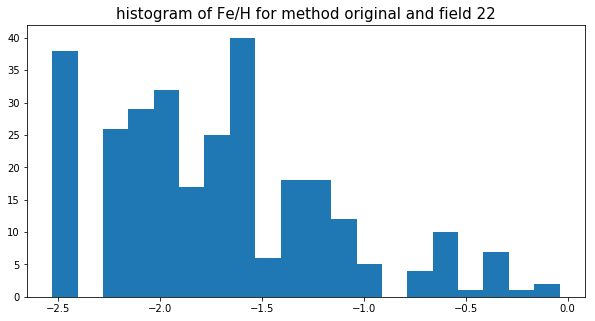

metallicity for shift method: -1.3372118589969781


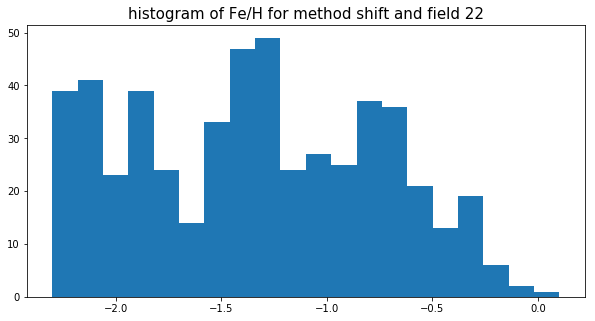

number of initial stars in field 24: 29599


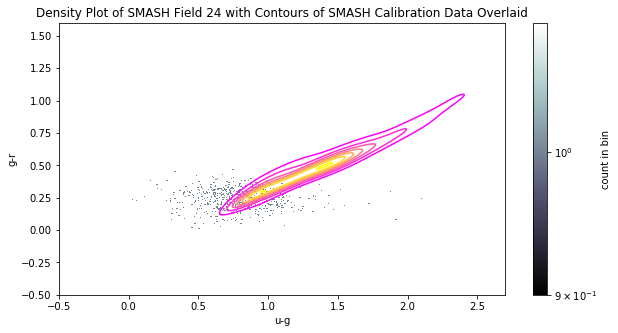

number of stars after cuts in field 24: 560
metallicity for original method: -1.3867831784783557


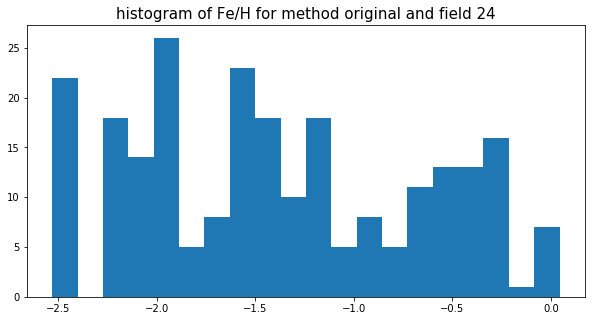

metallicity for shift method: -1.019976015956629


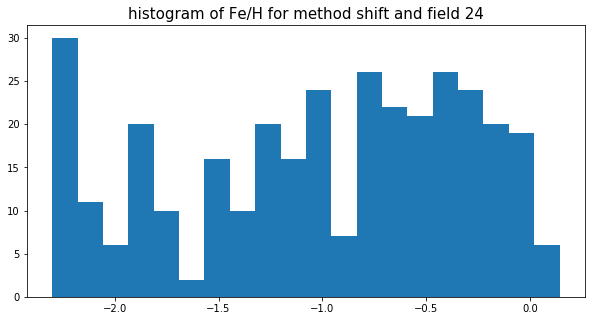

number of initial stars in field 26: 52301


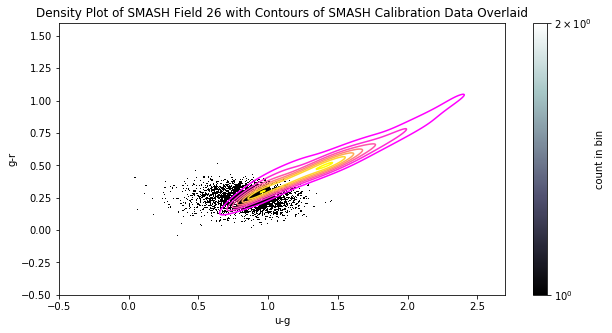

number of stars after cuts in field 26: 3767
metallicity for original method: -1.31284201884011


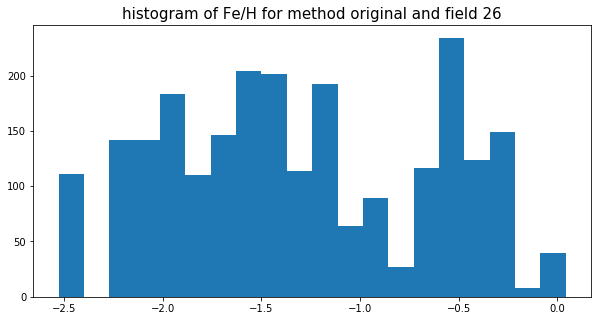

metallicity for shift method: -0.8514047115542817


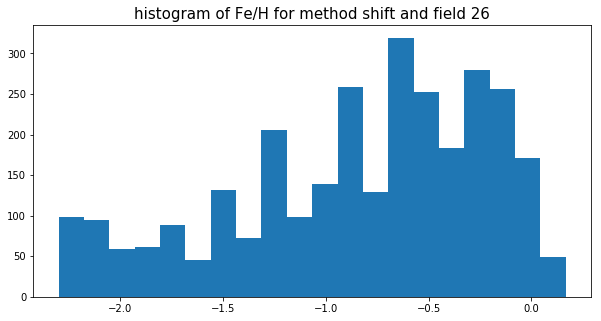

number of initial stars in field 27: 94878


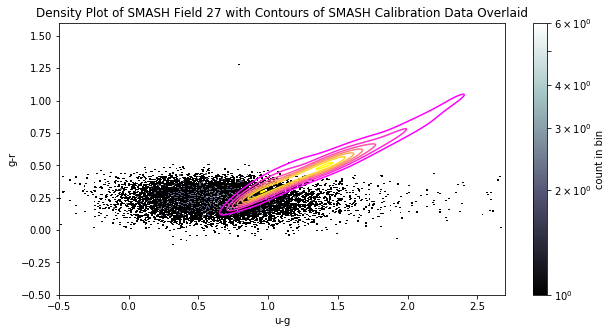

number of stars after cuts in field 27: 13883
metallicity for original method: -1.355154563542611


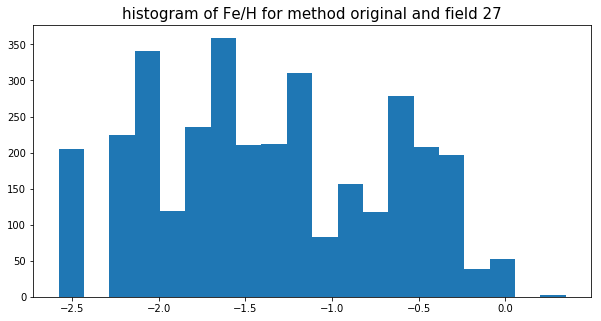

metallicity for shift method: -1.0739277971020291


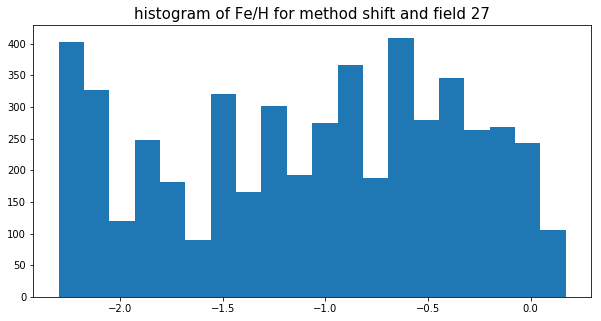

number of initial stars in field 28: 114705


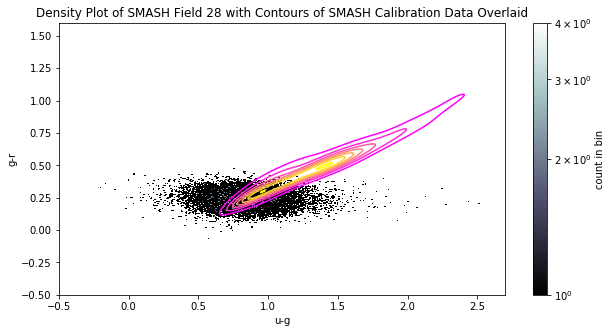

number of stars after cuts in field 28: 13946
metallicity for original method: -1.3223870159925815


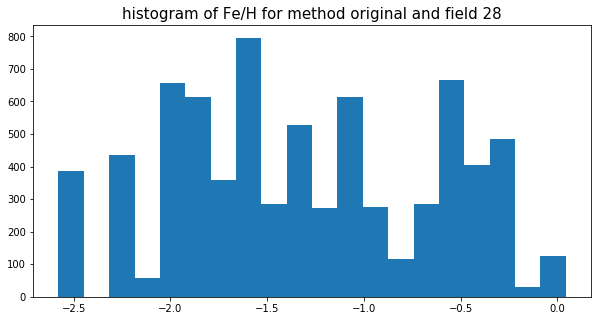

metallicity for shift method: -0.9171597008984008


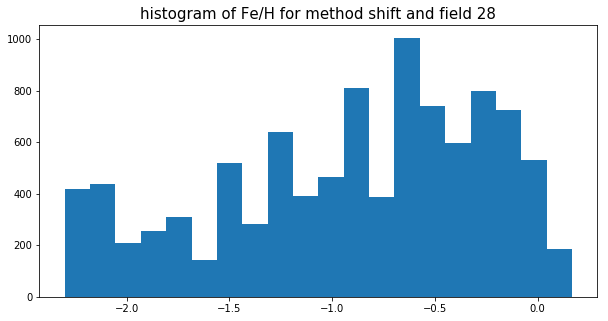

number of initial stars in field 29: 404098


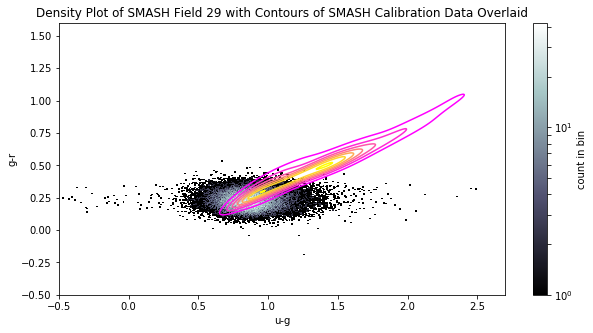

number of stars after cuts in field 29: 67384
metallicity for original method: -1.3723416384396308


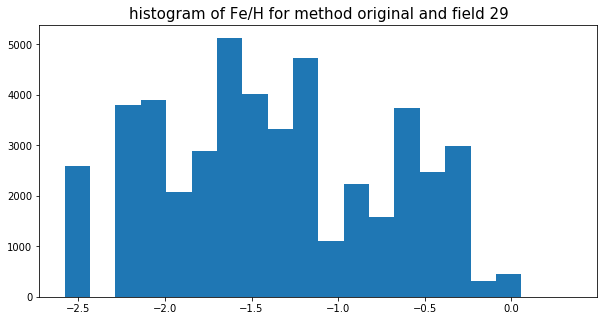

metallicity for shift method: -0.8535739702845321


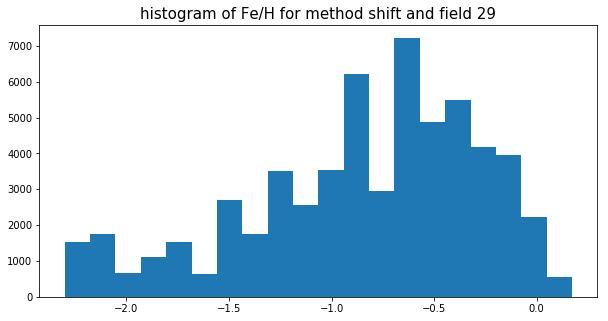

number of initial stars in field 31: 46943


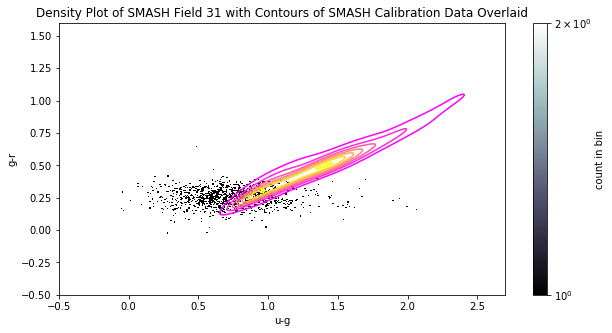

number of stars after cuts in field 31: 1132
metallicity for original method: -1.4359631357486553


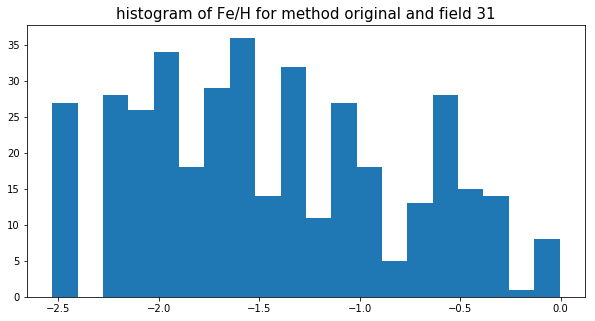

metallicity for shift method: -1.078628262818183


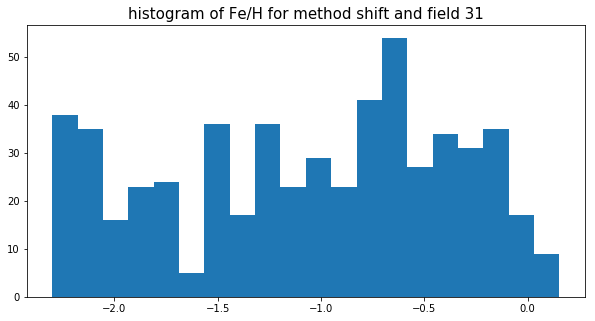

number of initial stars in field 32: 1825281


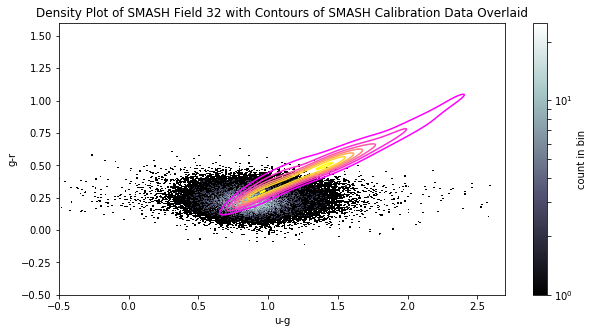

number of stars after cuts in field 32: 152476
metallicity for original method: -1.2579174814216574


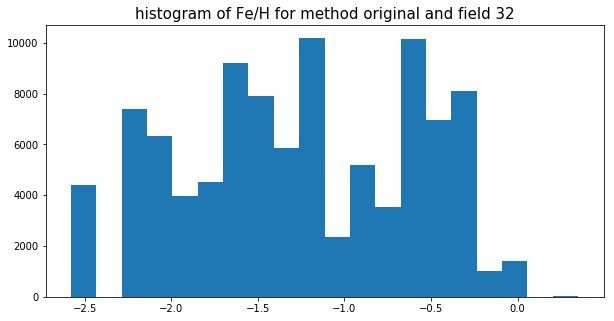

metallicity for shift method: -0.7888569560328312


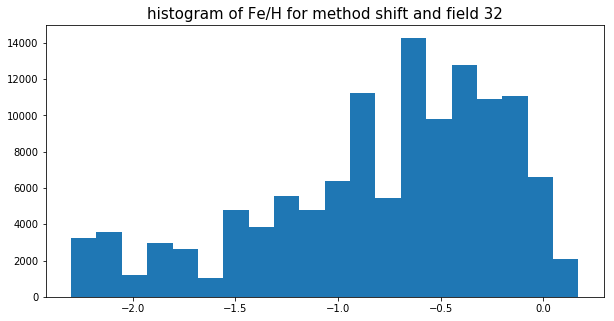

number of initial stars in field 33: 45996


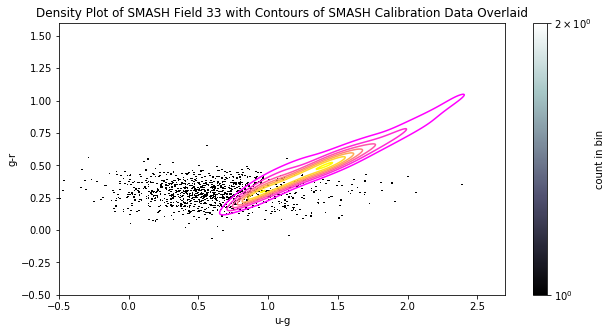

number of stars after cuts in field 33: 1105
metallicity for original method: -1.3179028308758998


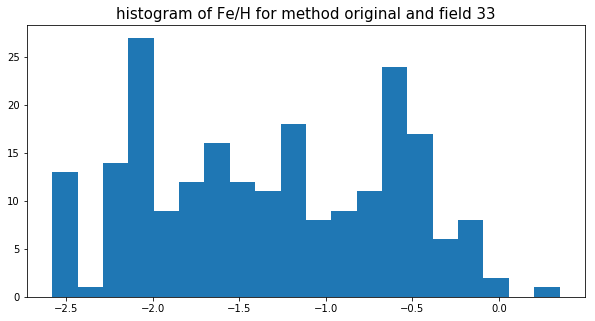

metallicity for shift method: -1.0934266292859638


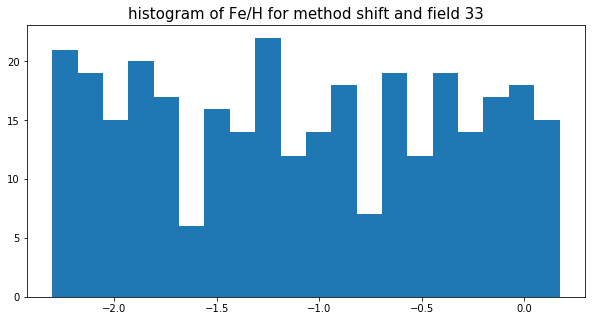

number of initial stars in field 34: 1421909


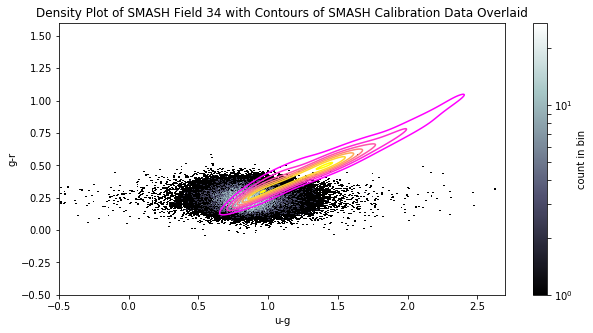

number of stars after cuts in field 34: 190149
metallicity for original method: -1.4102051520320158


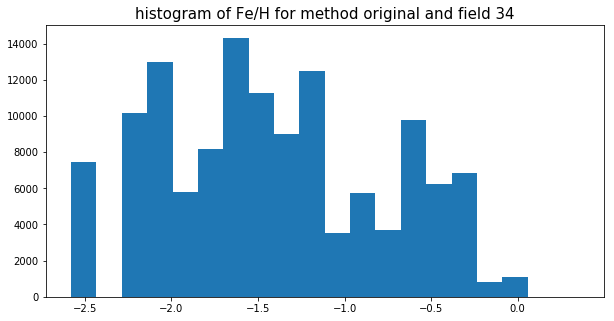

metallicity for shift method: -0.9066228935509839


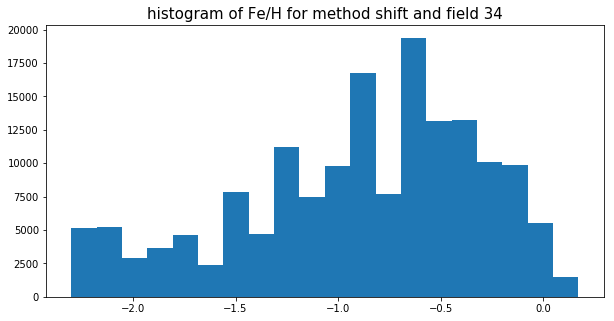

number of initial stars in field 37: 1743130


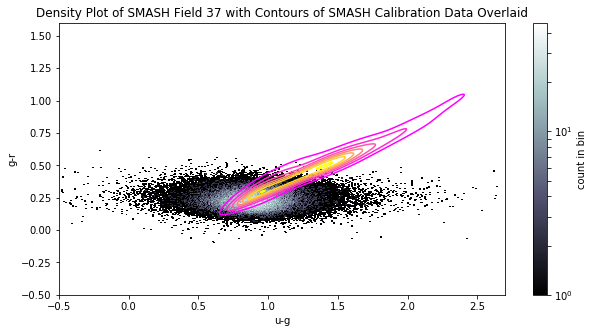

number of stars after cuts in field 37: 145725
metallicity for original method: -1.2540464895093544


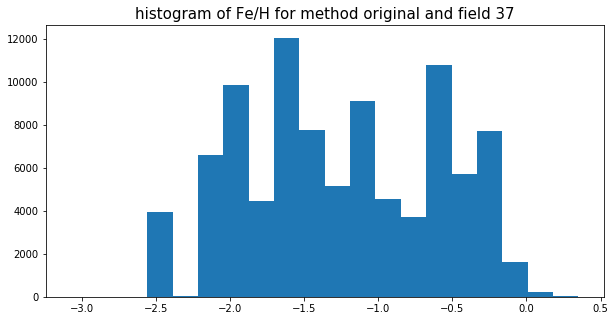

metallicity for shift method: -0.7759627396012464


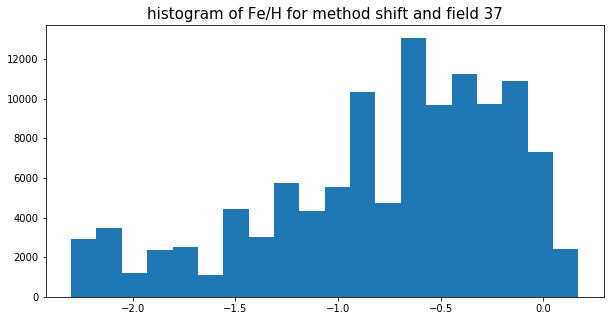

number of initial stars in field 40: 1752944


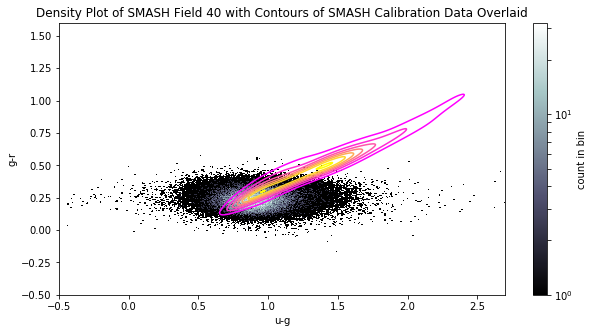

number of stars after cuts in field 40: 315218
metallicity for original method: -1.2510206897368523


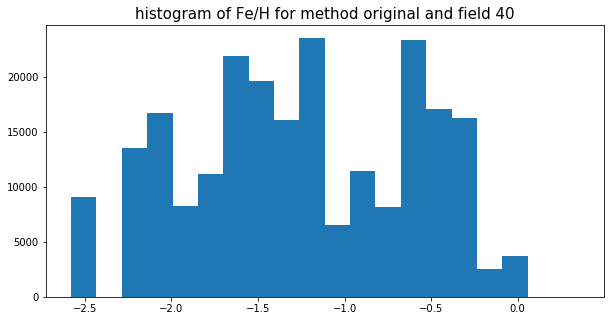

metallicity for shift method: -0.7392278099643058


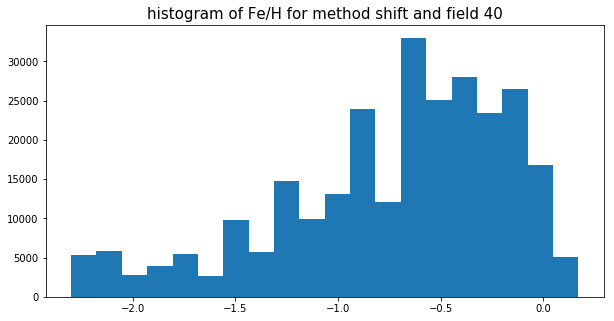

number of initial stars in field 44: 427557


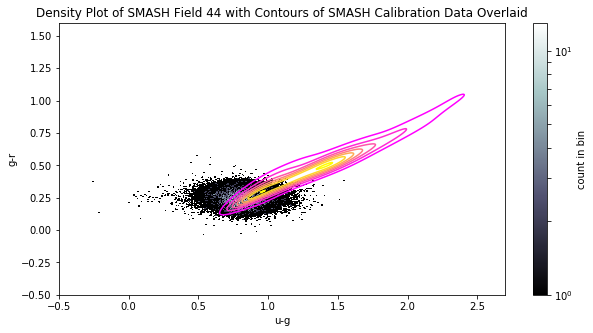

number of stars after cuts in field 44: 61749
metallicity for original method: -1.6501482733076875


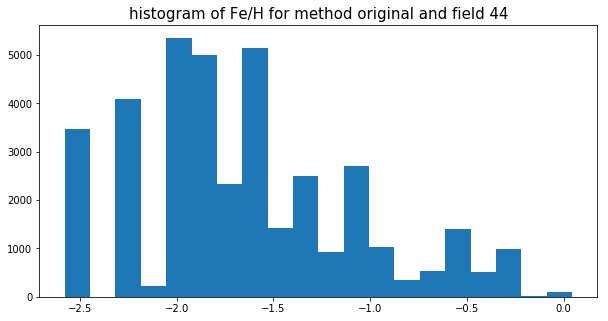

metallicity for shift method: -1.1102939864540693


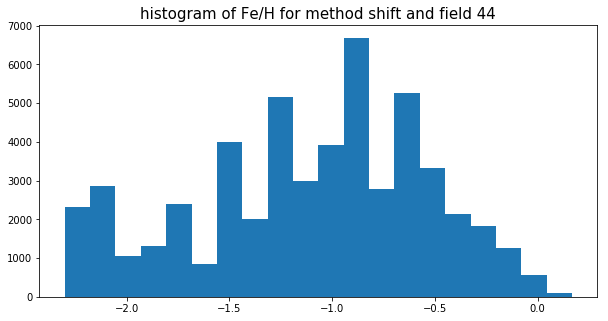

number of initial stars in field 46: 1304849


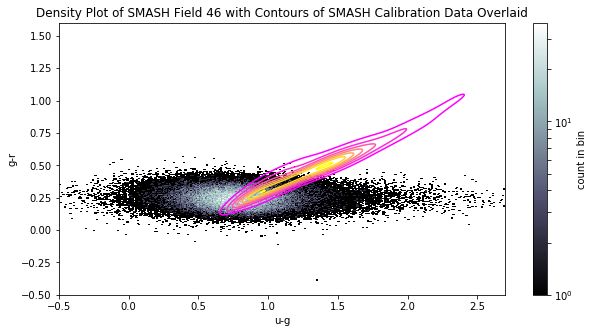

number of stars after cuts in field 46: 240939
metallicity for original method: -1.3652391012009564


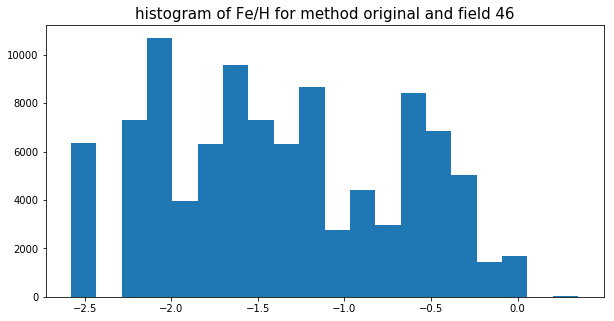

metallicity for shift method: -0.9860019189272411


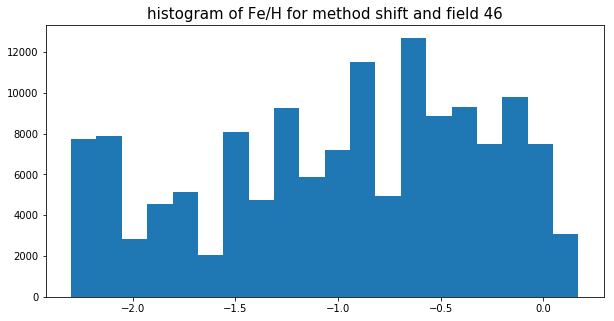

number of initial stars in field 49: 1763774


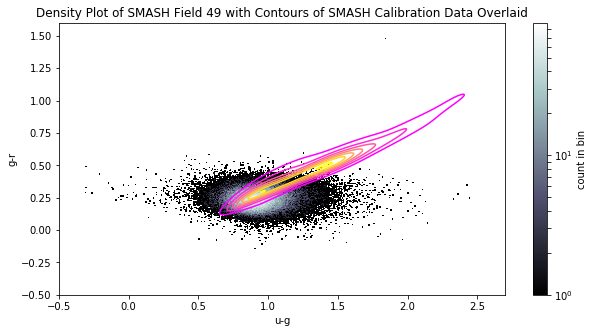

number of stars after cuts in field 49: 250502
metallicity for original method: -1.2269339727135553


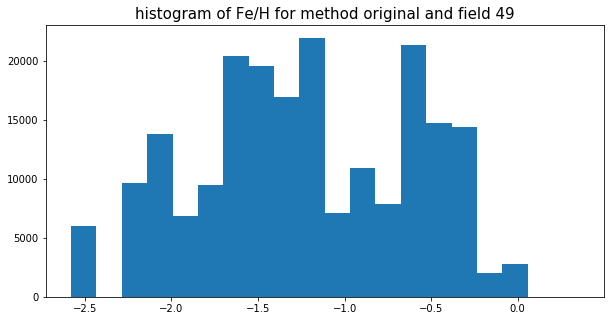

metallicity for shift method: -0.6738369889141925


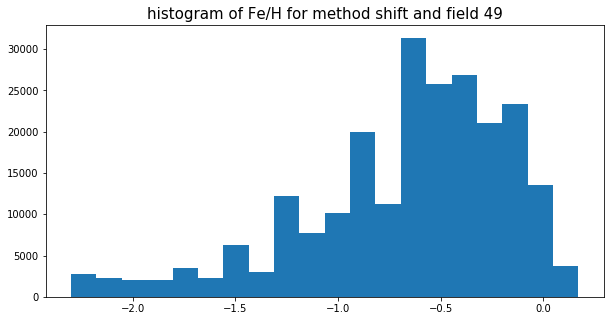

number of initial stars in field 51: 1574573


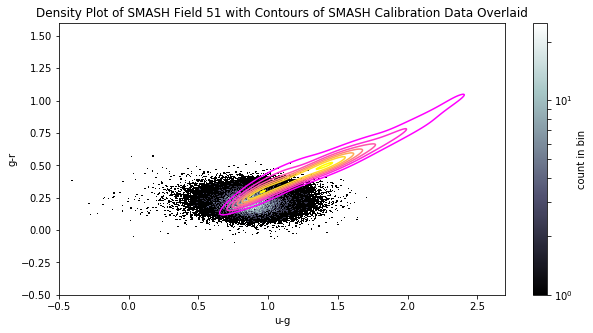

number of stars after cuts in field 51: 210235
metallicity for original method: -1.2986248185849176


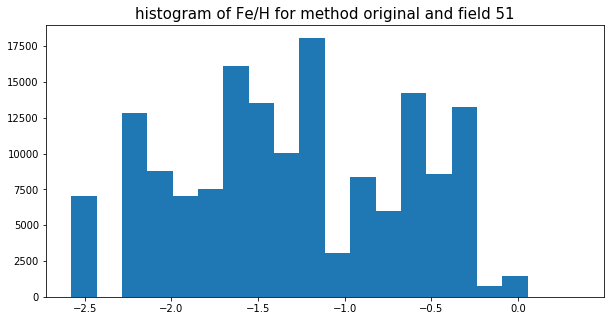

metallicity for shift method: -0.7596888949828735


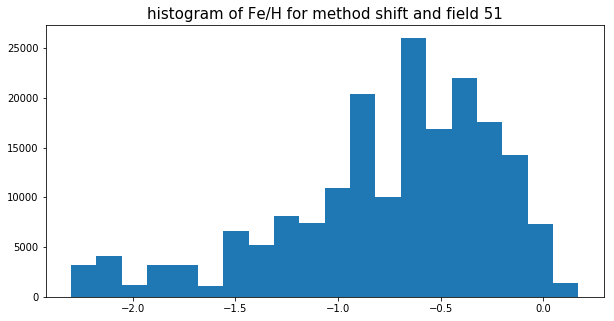

number of initial stars in field 52: 62890


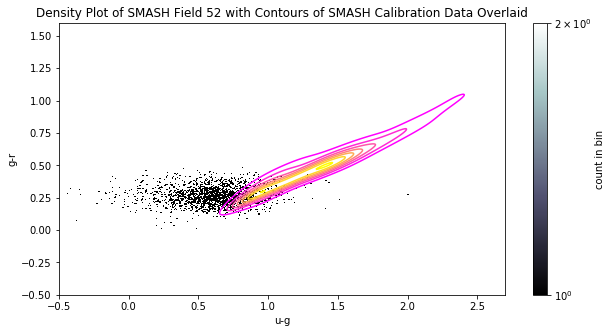

number of stars after cuts in field 52: 1949
metallicity for original method: -1.5938341460908143


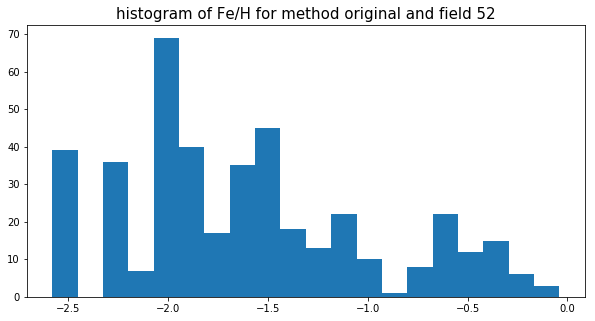

metallicity for shift method: -1.3304846370119159


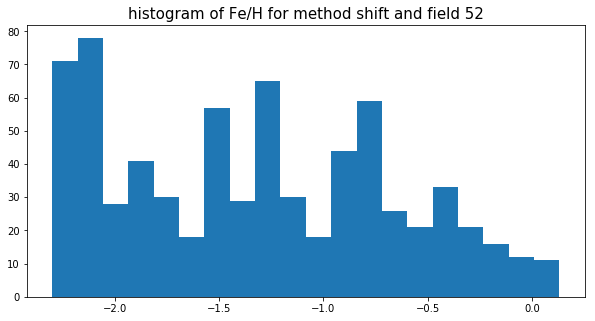

number of initial stars in field 53: 396092


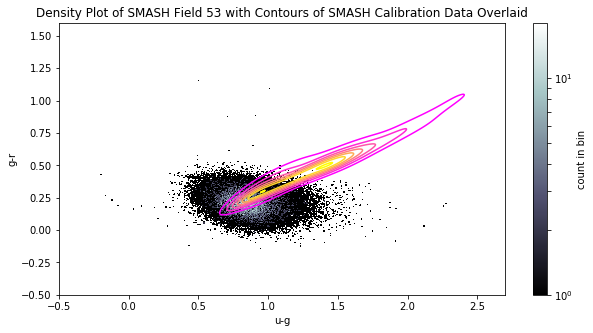

number of stars after cuts in field 53: 104288
metallicity for original method: -1.4034762050075122


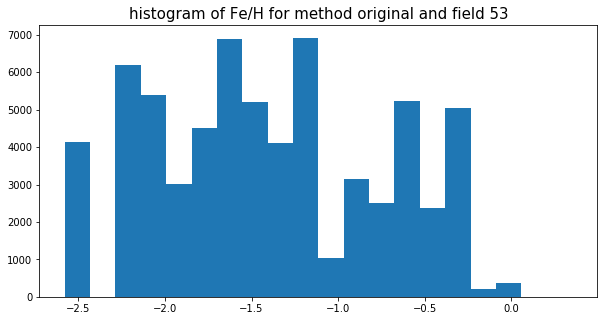

metallicity for shift method: -0.9184803926263337


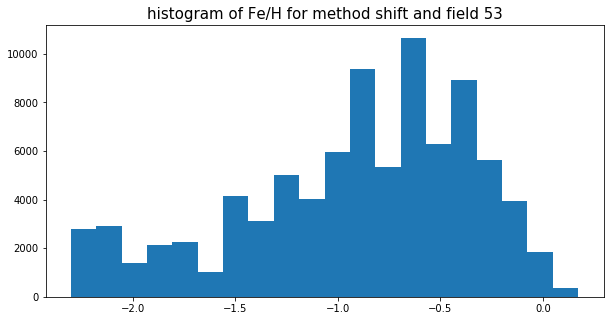

number of initial stars in field 54: 163332


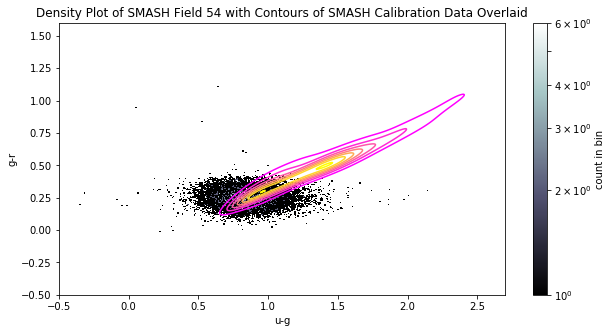

number of stars after cuts in field 54: 19381
metallicity for original method: -1.4403316883501527


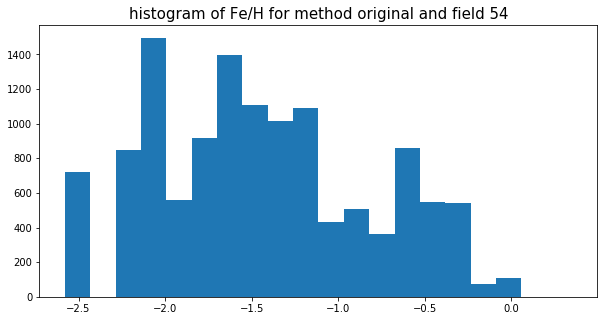

metallicity for shift method: -0.9615888451842706


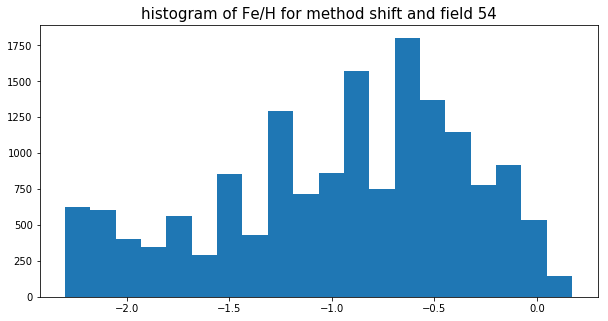

number of initial stars in field 55: 637616


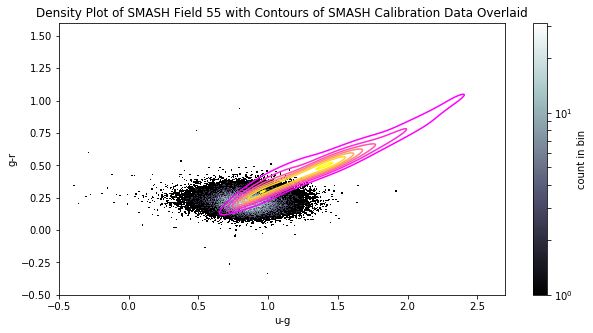

number of stars after cuts in field 55: 106127
metallicity for original method: -1.3799247592325863


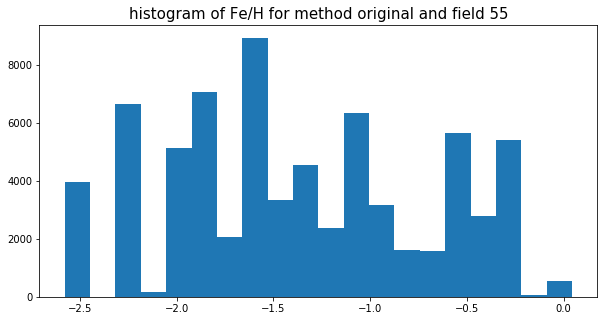

metallicity for shift method: -0.8644449338665462


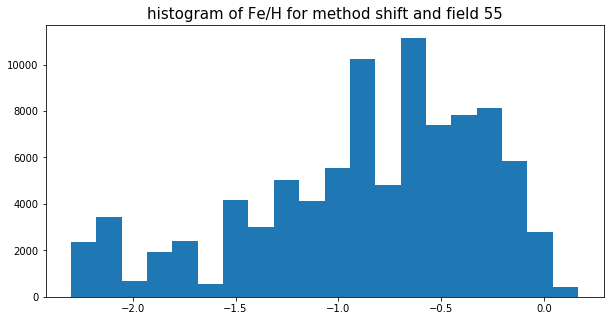

number of initial stars in field 56: 120917


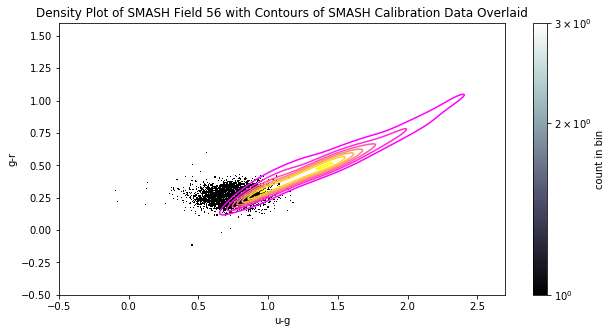

number of stars after cuts in field 56: 6302
metallicity for original method: -1.8160888075482684


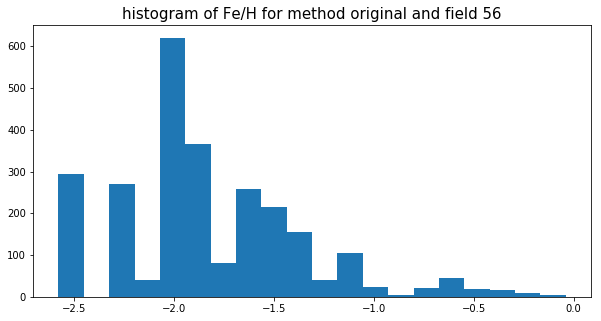

metallicity for shift method: -1.3999612658615515


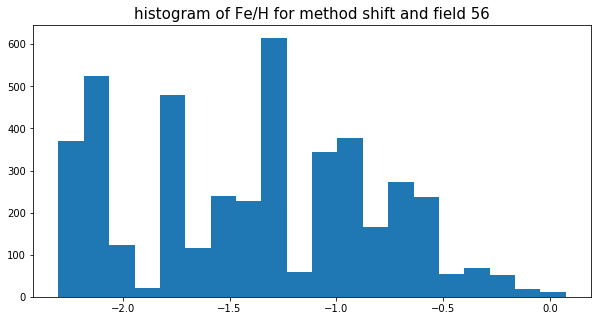

number of initial stars in field 57: 76423


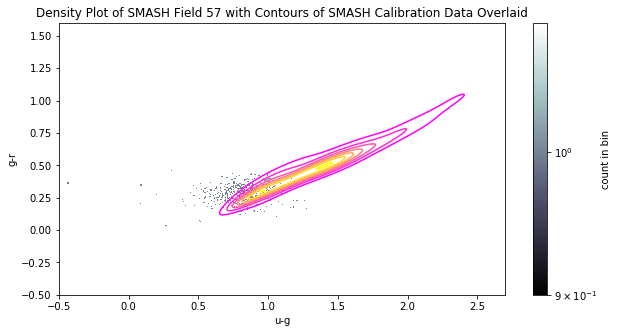

number of stars after cuts in field 57: 472
metallicity for original method: -1.5702800936169095


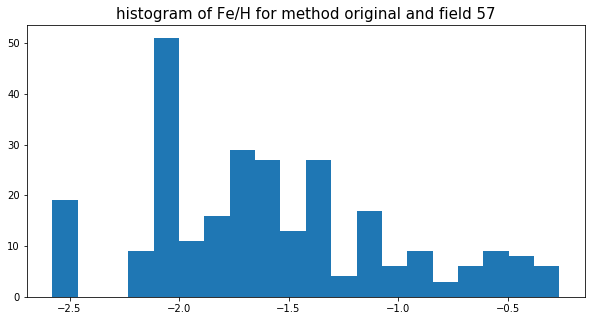

metallicity for shift method: -1.1946607616639906


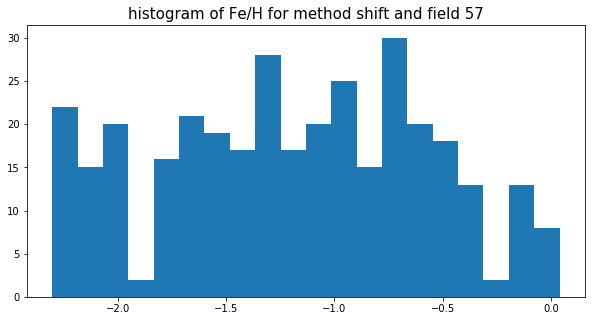

number of initial stars in field 58: 77341


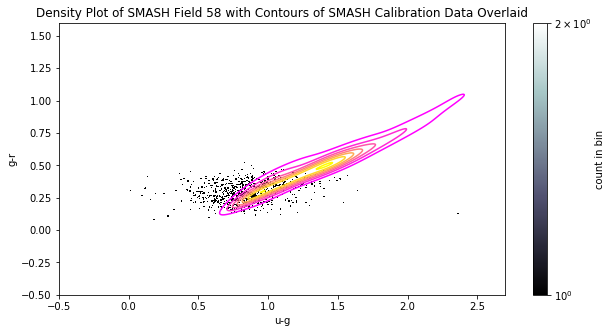

number of stars after cuts in field 58: 788
metallicity for original method: -1.3805735785143354


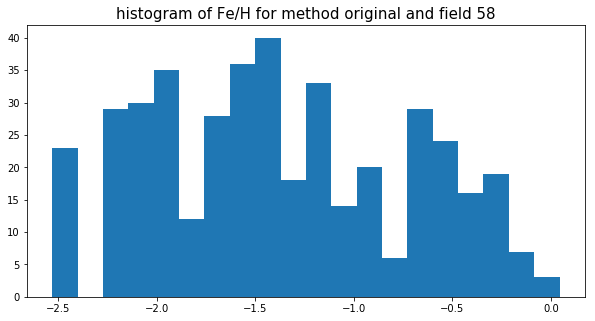

metallicity for shift method: -1.1042563465738913


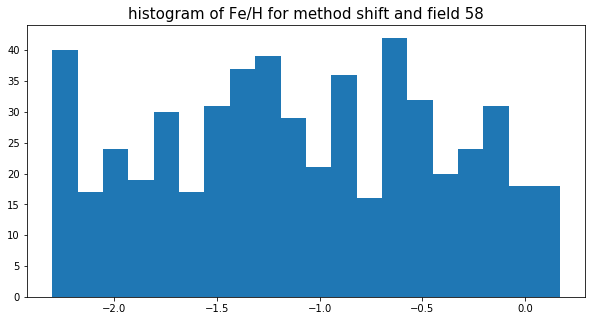

number of initial stars in field 59: 88849


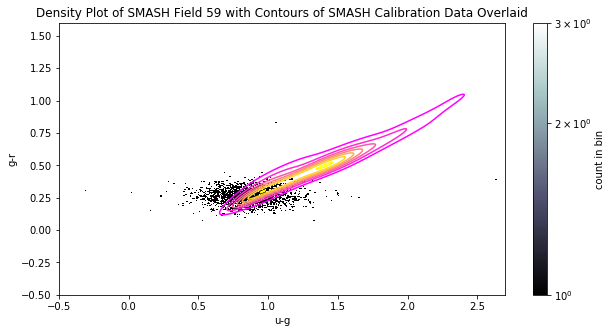

number of stars after cuts in field 59: 2148
metallicity for original method: -1.4055117055179907


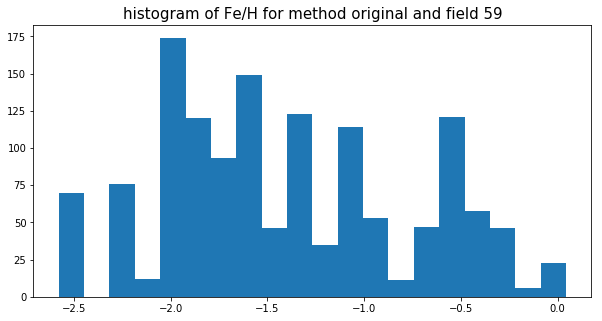

metallicity for shift method: -0.9326506493450538


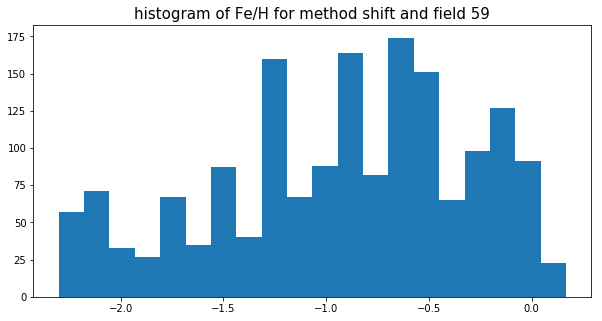

number of initial stars in field 60: 59324


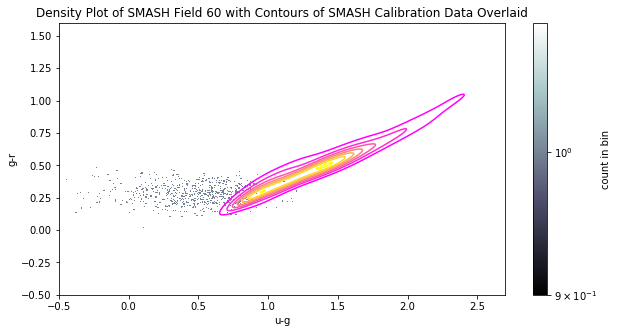

number of stars after cuts in field 60: 664
metallicity for original method: -1.7675879247147928


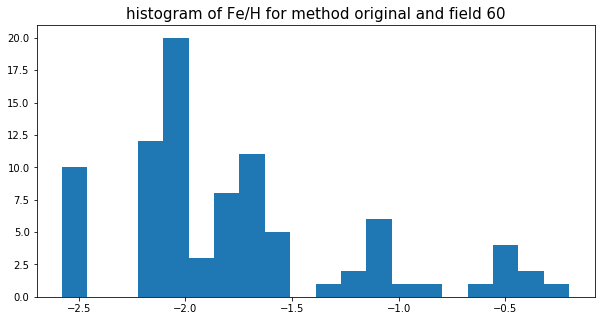

metallicity for shift method: -1.3888844727669787


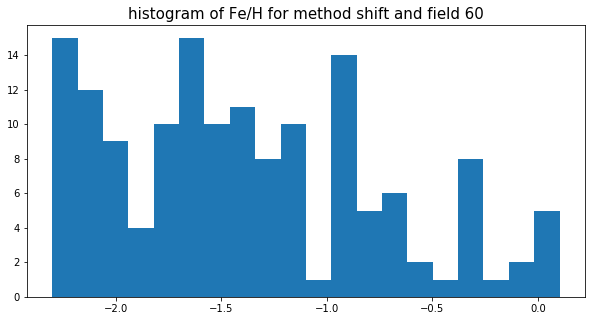

number of initial stars in field 61: 80665


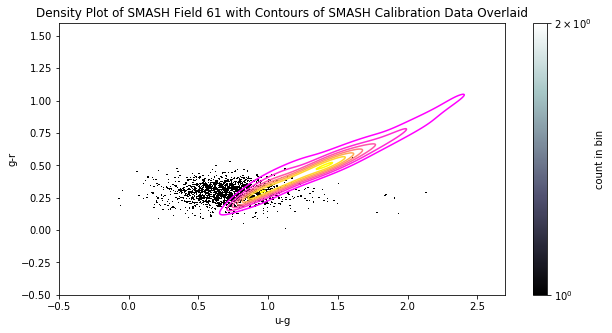

number of stars after cuts in field 61: 1745
metallicity for original method: -1.5234058129448276


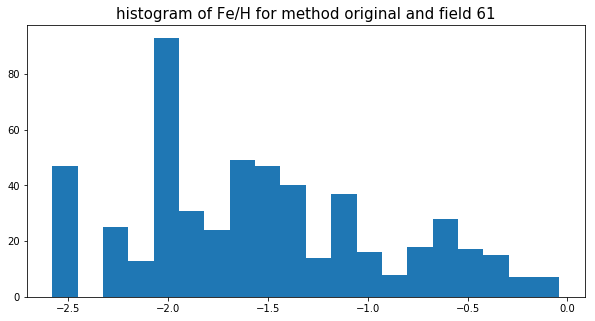

metallicity for shift method: -1.2363645364392188


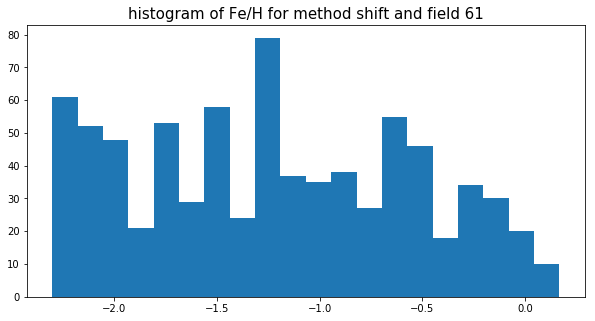

number of initial stars in field 63: 113977


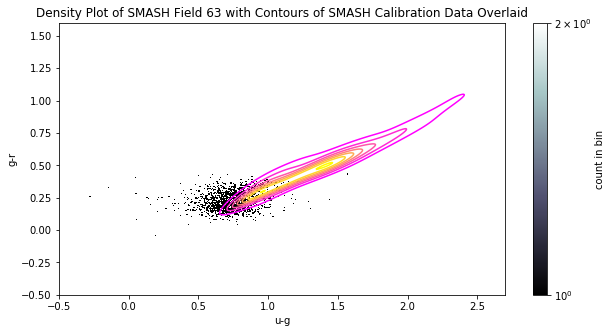

number of stars after cuts in field 63: 1575
metallicity for original method: -1.695961169728627


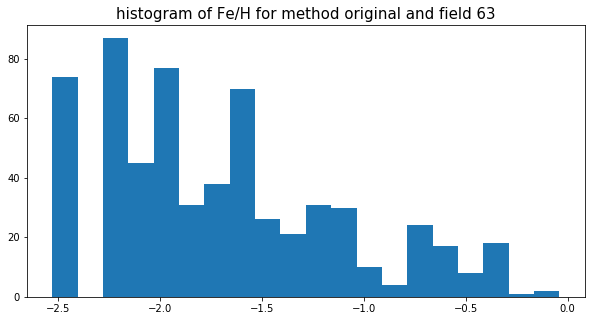

metallicity for shift method: -1.3196189334138637


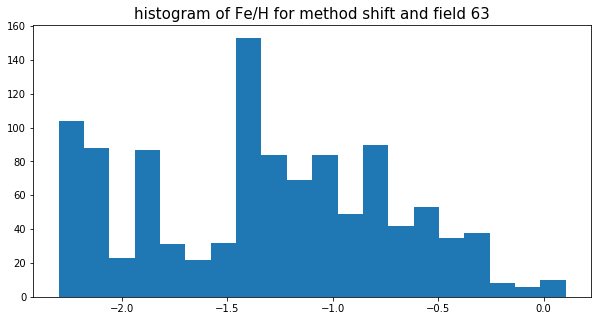

number of initial stars in field 64: 68421


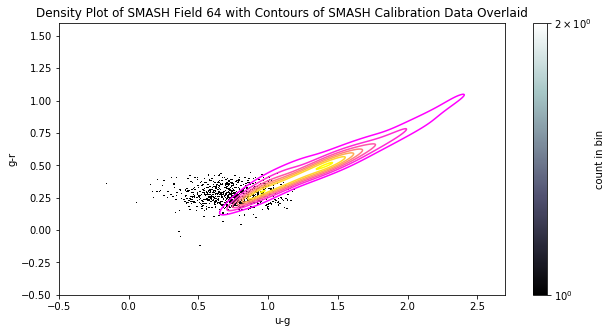

number of stars after cuts in field 64: 912
metallicity for original method: -1.5430704517160903


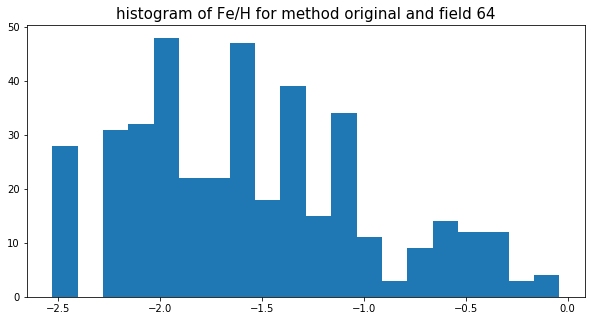

metallicity for shift method: -1.1119864906055215


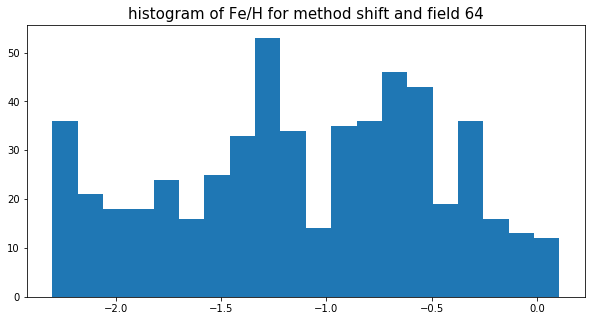

number of initial stars in field 66: 101460


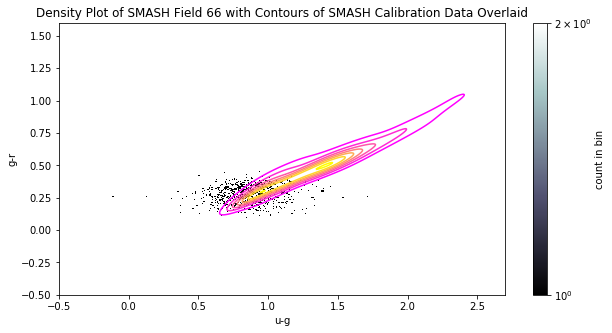

number of stars after cuts in field 66: 784
metallicity for original method: -1.3895764239853303


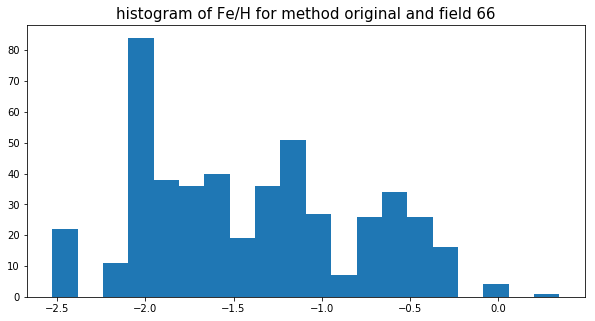

metallicity for shift method: -1.0556214611965204


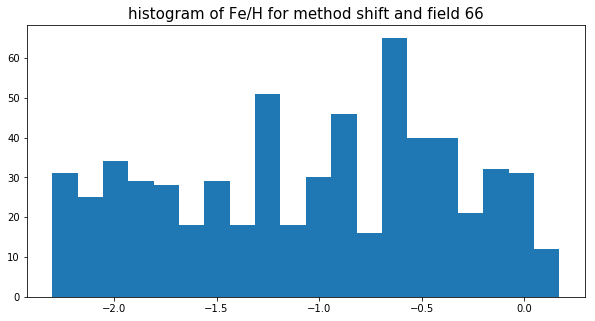

number of initial stars in field 68: 90704


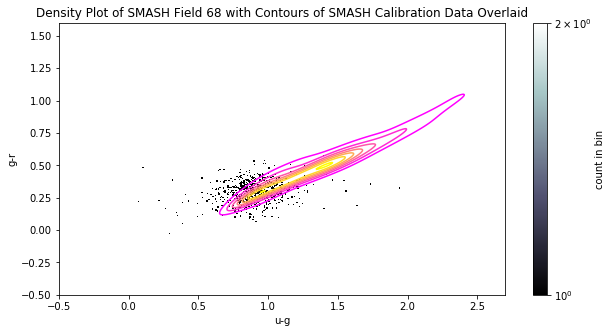

number of stars after cuts in field 68: 689
metallicity for original method: -1.384896532297658


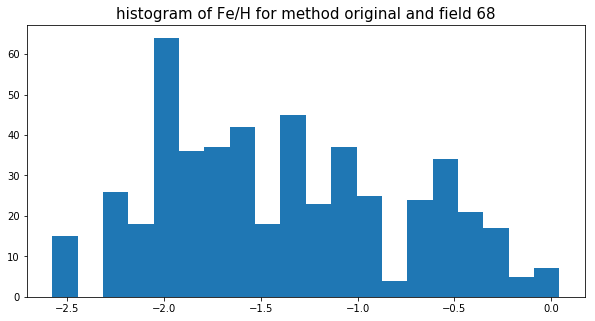

metallicity for shift method: -1.0204955148108212


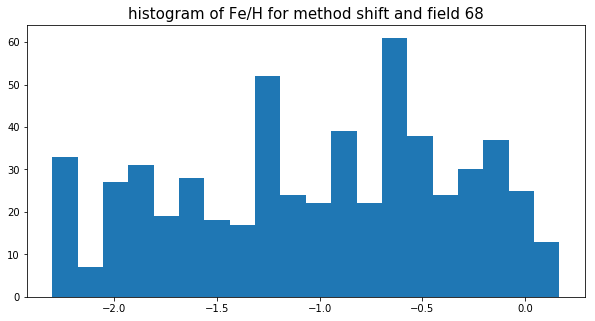

number of initial stars in field 149: 69283


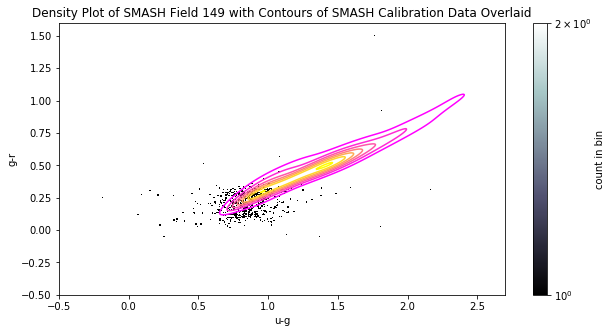

number of stars after cuts in field 149: 616
metallicity for original method: -1.4363369404030988


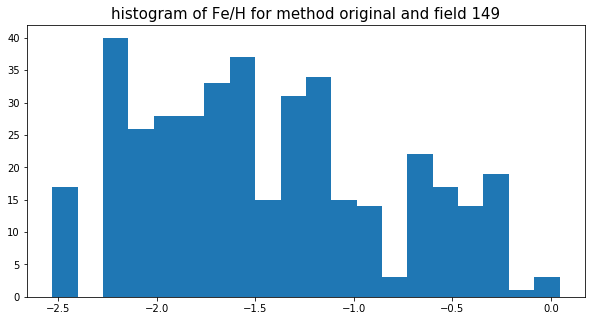

metallicity for shift method: -0.9579742940572592


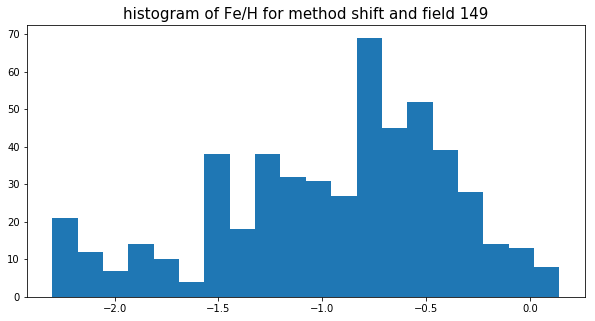

number of initial stars in field 150: 46060


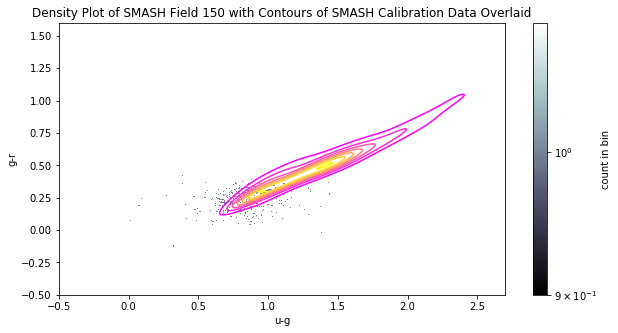

number of stars after cuts in field 150: 343
metallicity for original method: -1.497323318315086


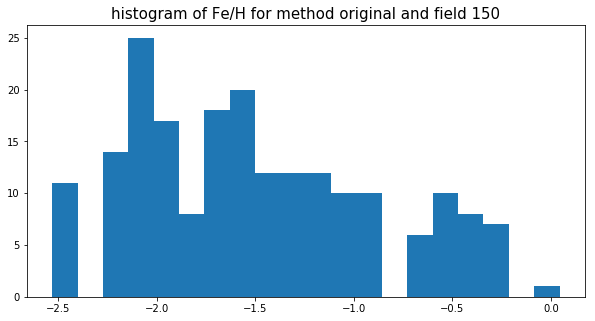

metallicity for shift method: -1.0795865609920283


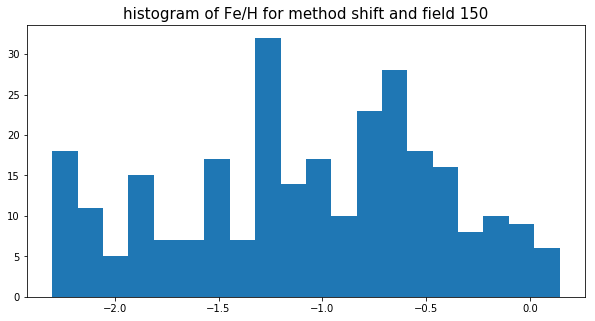

number of initial stars in field 156: 122018


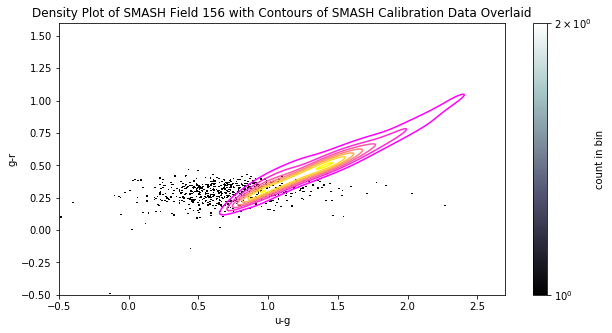

number of stars after cuts in field 156: 636
metallicity for original method: -1.280798856549316


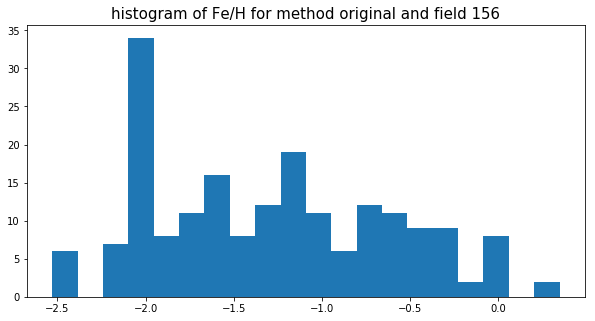

metallicity for shift method: -1.1079496236776145


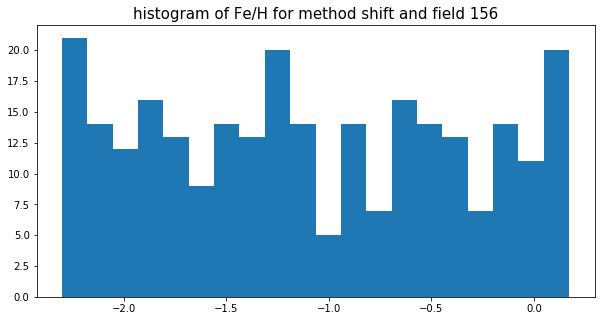

number of initial stars in field 176: 111318


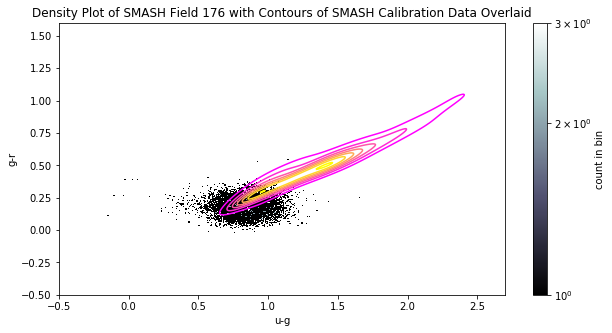

number of stars after cuts in field 176: 10154
metallicity for original method: -1.4175882956640549


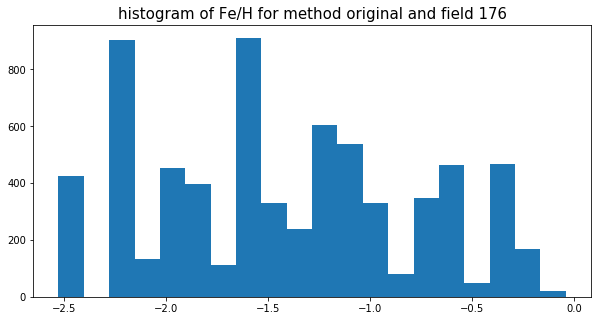

metallicity for shift method: -0.9011535888967109


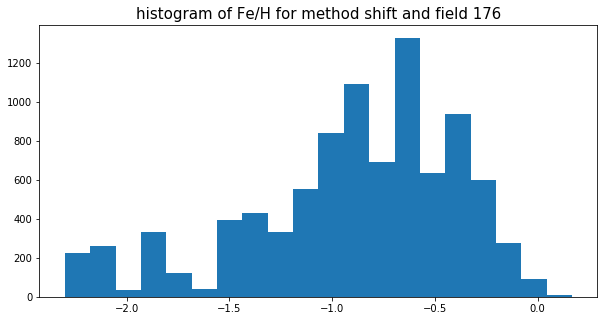

number of initial stars in field 177: 98553


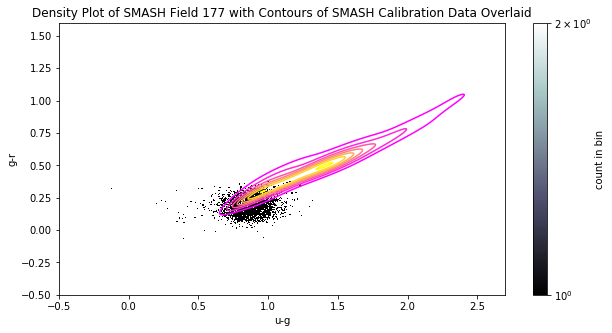

number of stars after cuts in field 177: 2870
metallicity for original method: -1.344580028331758


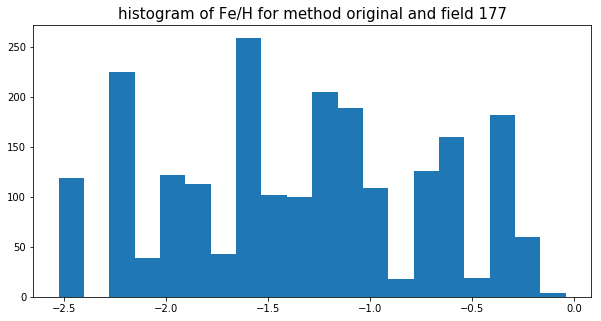

metallicity for shift method: -0.8048254143147893


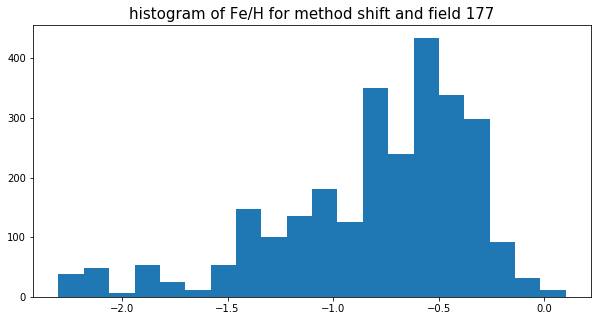

number of initial stars in field 178: 233226


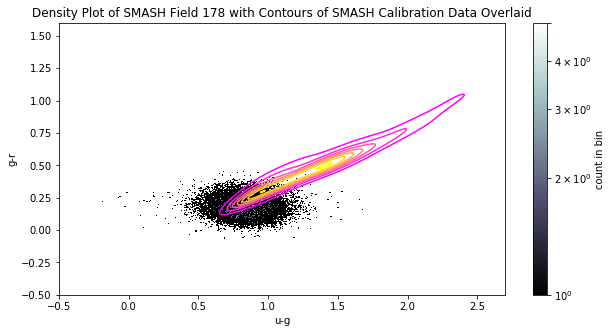

number of stars after cuts in field 178: 26378
metallicity for original method: -1.3907774851260726


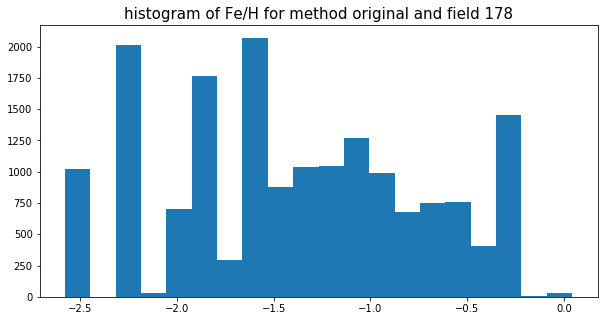

metallicity for shift method: -0.9207646675983929


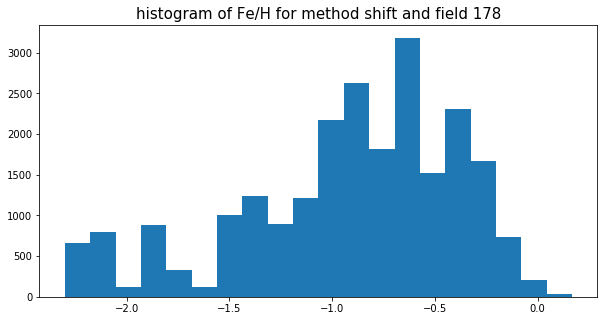

number of initial stars in field 246: 76714


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal


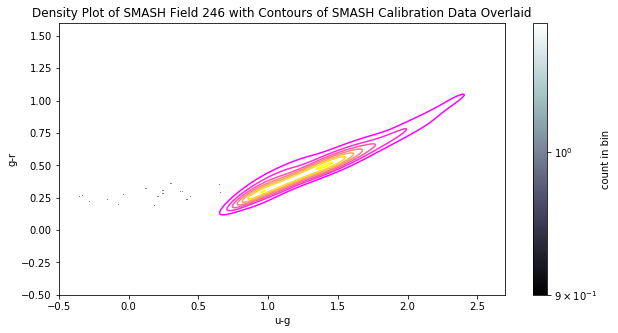

number of stars after cuts in field 246: 21
metallicity for original method: nan


/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


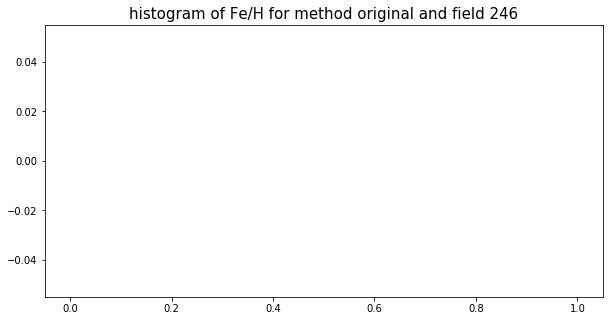

metallicity for shift method: nan


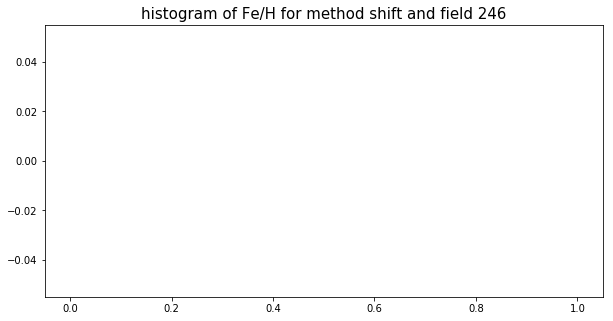

In [400]:

if __name__=="__main__":
    for number in fields:
        metallicity('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field{}_allobj_deep_stars.fits.gz'.format(number))

              

In [401]:
#ra and dec of each SMASH field and of the centers of LMC/SMC
ra = np.array([2.58282, 4.74128, 5.8295, 6.23604, 11.0282, 11.2637, 12.6438, 15.3642, 17.2959, 19.3929, 20.1116, 21.1397, 22.3556, 32.3014, 33.2987, 33.7735, 38.0154, 40.8729, 48.7252, 55.0714, 62.0399, 62.2076, 71.5224, 72.8794, 73.2326, 73.826, 74.3797, 74.8251, 75.6417, 78.0543, 79.5644, 81.6974, 83.023, 84.5087, 85.416, 87.2541, 87.3605, 89.5211, 96.3535, 96.7494, 98.0372, 98.2317, 107.298, 108.637, 111.26, 111.286, 114.087, 114.673, 118.049, 120.112, 128.154, 130.919, 351.667, 351.815, 115.38663, 10.65102, 22.45883, 25.12044, 101.835])
dec = np.array([-69.7946, -77.0834, -73.9689, -72.3856, -71.6294, -74.8041, -82.474, -70.7182, -75.4505, -78.5112, -71.2591, -72.825, -74.3674, -73.2717, -77.5124, -67.4354, -70.2838, -74.5334, -72.4893, -76.4147, -72.0384, -68.4171, -75.3739, -68.7777, -80.7479, -70.5799, -84.3086, -72.3767, -67.5258, -66.2141, -72.8687, -66.6022, -76.3886, -73.2367, -66.8939, -71.7809, -68.5956, -70.2803, -79.9982, -67.1805, -75.1855, -70.3668, -68.3137, -54.6223, -59.3505, -64.5201, -76.1913, -70.9916, -67.0089, -84.4426, -72.6595, -76.0996, -72.0863, -67.6899, -54.888583, -67.7937, -67.39283, -71.2175, -52.264999])

ra = ra[good_index]
dec = dec[good_index]
#associated SkyCoord object
c_fields = SkyCoord(ra,dec,unit='deg')

#LMC center
ra_lmc = 81.900000
dec_lmc = -69.866667
#SMC center
ra_smc = 13.183333
dec_smc = -72.828333
#associated SkyCoord objects
c_lmc = SkyCoord(ra_lmc,dec_lmc,unit='deg')
c_smc = SkyCoord(ra_smc,dec_smc,unit='deg')

#calculate radii from LMC/SMC center
radii_lmc = c_fields.separation(c_lmc)
radii_smc = c_fields.separation(c_smc)


In [402]:
radii_lmc = radii_lmc.degree
radii_smc = radii_smc.degree

In [403]:
lmc_fields = [156,24,246,26,27,28,29,31,33,44,52,53,54,55,56,57,58,59,60,61,63,64,66,68,30,32,34,35,37,40,42,46,48,49,50,51]


In [404]:
lmc_index = []
for i in np.arange(0,len(fields)):
    for j in lmc_fields:
        if fields[i]==j:
            lmc_index.append(i)

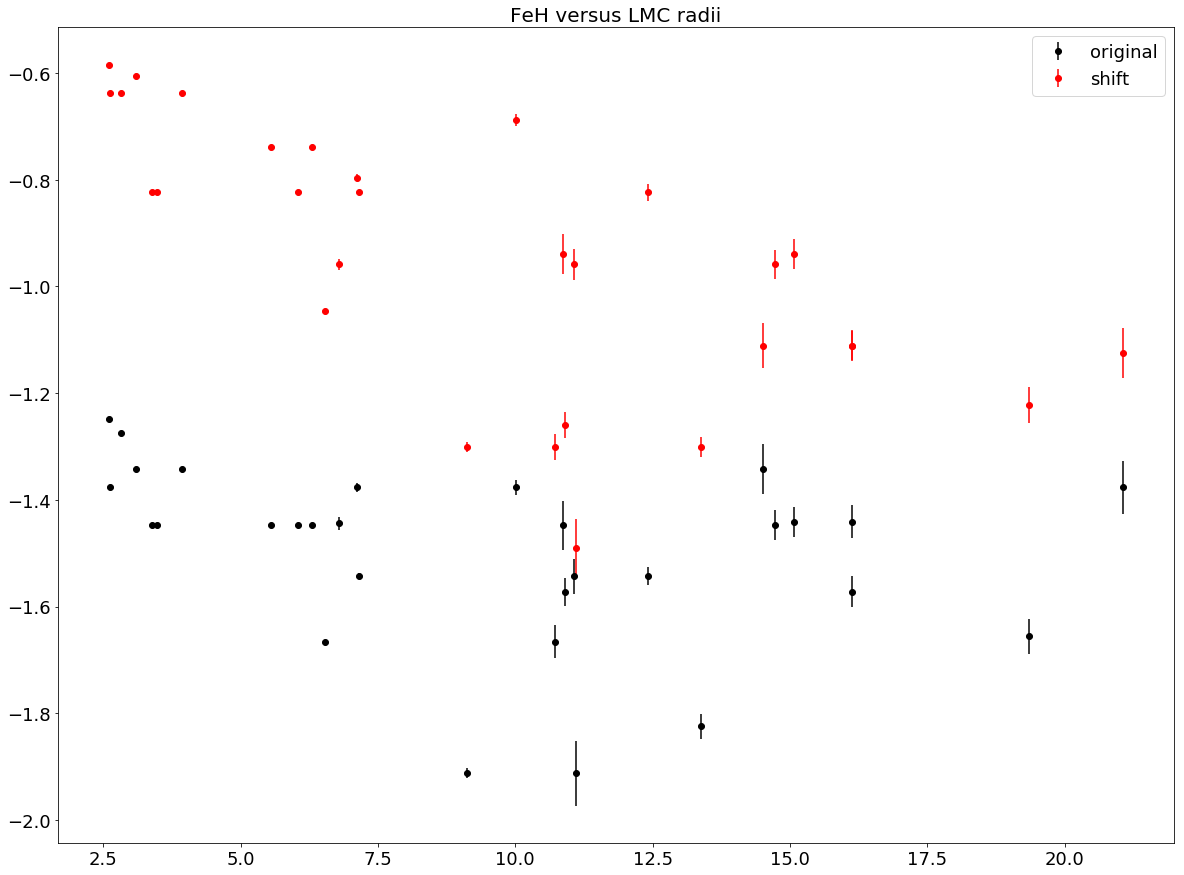

In [405]:
#plots of Fe/H versus radii for LMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['k','r','b','g','c','m']
#for i, method in enumerate(('original','nearest_regressor','uerr','gerr','rerr')):
for i, method in enumerate(('original','shift')):
    ax.errorbar(radii_lmc[lmc_index],np.array(metal[method])[lmc_index],yerr=np.array(error[method])[lmc_index],fmt='o',c=colors[i],label=method)

ax.set_title('FeH versus LMC radii',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_ylim(-2.25,-.5)
ax.legend(fontsize=18)
    

In [406]:
smc_fields = [1,13,149,150,176,177,178,18,20,21,22,8,12,14,15,16,19,2,3,4,5,7,9]

In [407]:
smc_index = []
for i in np.arange(0,len(fields)):
    for j in smc_fields:
        if fields[i]==j:
            smc_index.append(i)

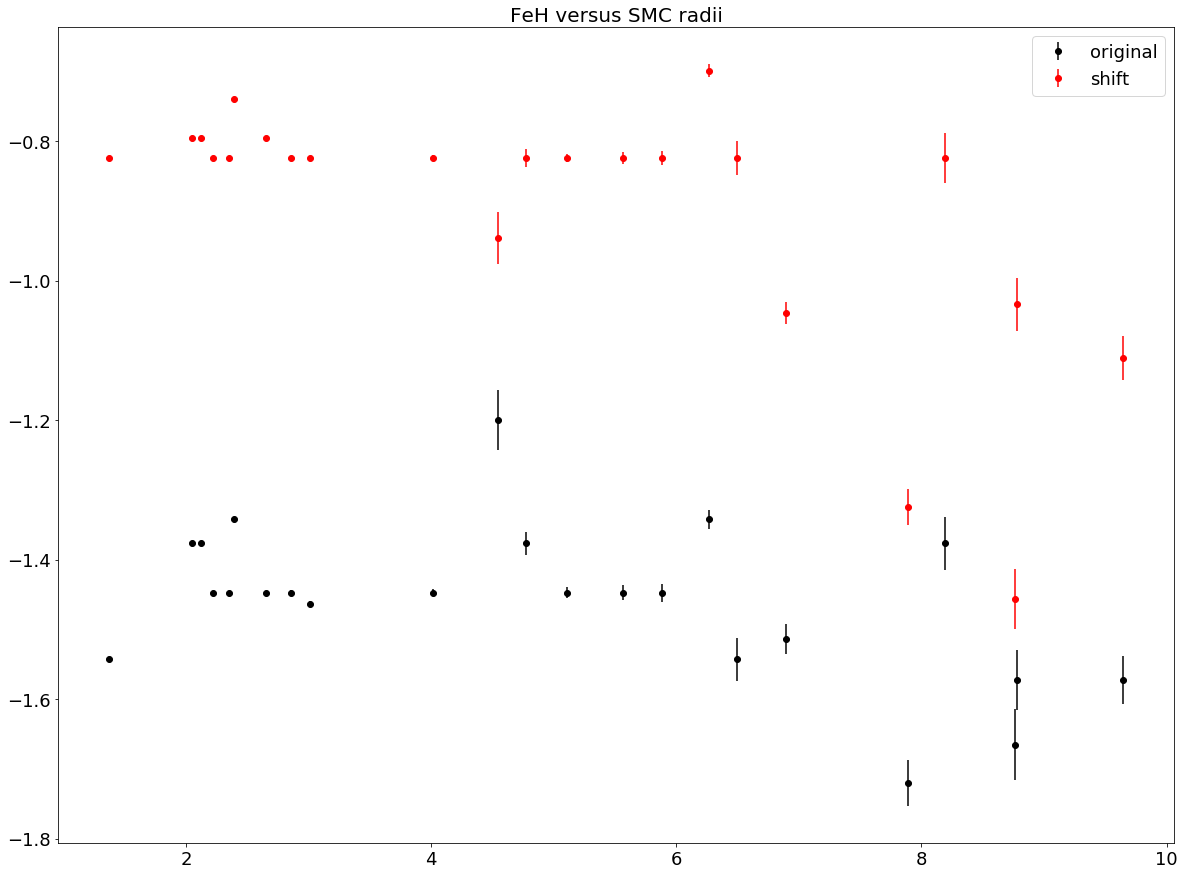

In [408]:
#plots of Fe/H versus radii for SMC
#index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20,15))
colors = ['k','r','b','g','c','m']
#for i, method in enumerate(('original','nearest_regressor','uerr','gerr','rerr')):
for i, method in enumerate(('original','shift')):
    ax.errorbar(radii_smc[smc_index],np.array(metal[method])[smc_index],yerr=np.array(error[method])[smc_index],fmt='o',c=colors[i],label=method)

    ax.set_title('FeH versus SMC radii',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_ylim(-2.25,-.5)
ax.legend(fontsize=18)
    

In [151]:

#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    #initial_stars.append(len(objs_new))
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g<=25)&(u<=25)&(r<=25)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8)))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    g_i = g-i
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    fig, ax = plt.subplots(figsize=(10,5))
    hess = stats.binned_statistic_2d(u_g, g_r, None, 'count',bins=1000)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='bone',norm=clr.LogNorm())
    ax.contour(xx_cal,yy_cal,zz_cal,cmap='spring')
    cb = fig.colorbar(im,ax=ax,label='count in bin')
    ax.set_xlim(-.5,2.7)
    ax.set_ylim(-.5,1.6)
    ax.set_xlabel('u-g')
    ax.set_ylabel('g-r')
    ax.set_title('Density Plot of SMASH Field '+str(field_number[0])+' with Contours of SMASH Calibration Data Overlaid')
    
    fig,ax = plt.subplots(figsize=(10,5))
    hess = stats.binned_statistic_2d(g_i,g, None, 'count',bins=10000)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='bone',norm=clr.LogNorm())
    cb = fig.colorbar(im,ax=ax,label='count in bin')
    ax.set_xlim(-2,2)
    ax.set_xlabel('g-i')
    ax.set_ylabel('g')
    ax.invert_yaxis()
    
    plt.show(block=False)
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    #cut_stars.append(len(u))
    stars = len(u)
    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('original','iso','iso_cut','shift')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        N = np.count_nonzero(~np.isnan(feh))
        metal[method].append(np.nanmedian(feh))
        print("metallicity for "+method+" method:",(np.nanmean(feh)))
        #std[method].append(np.nanstd(feh))
        #error[method].append((np.nanstd(feh))/np.sqrt(N))
        fig,ax = plt.subplots(figsize=(10,5))
        ax.hist(feh[~np.isnan(feh)],bins=20)
        ax.set_title('histogram of Fe/H for method '+method+' and field '+str(field_number[0]),fontsize=15)
        plt.show(block=False)
    
    
    return 0


number of initial stars in field 362: 31344


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


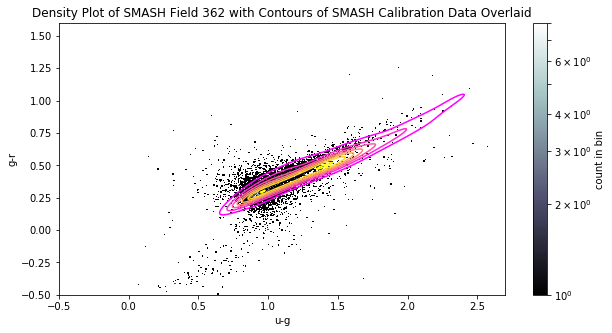

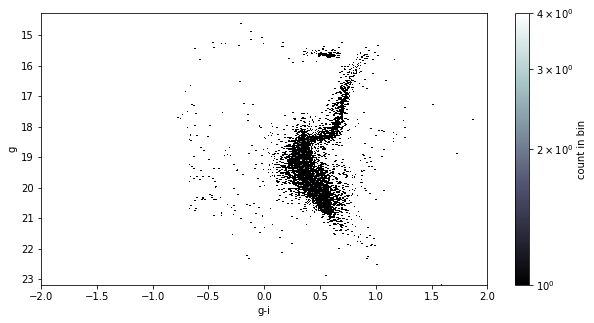

number of stars after cuts in field 362: 8980
metallicity for original method: -1.1636545910615033


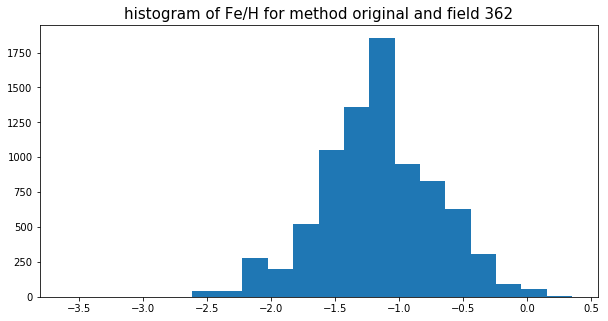

metallicity for iso method: -0.6085546633448651


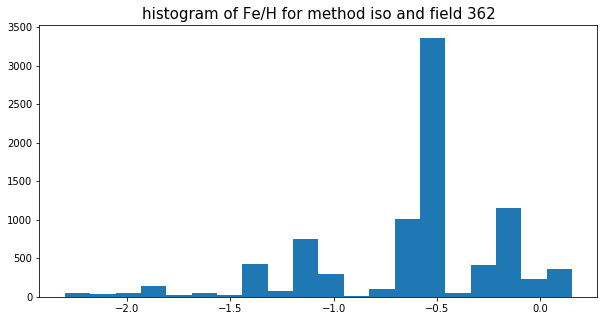

metallicity for iso_cut method: -0.6668373831757554


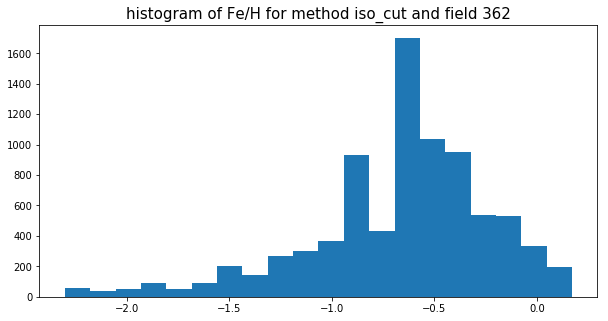

metallicity for shift method: -0.8073974840654443


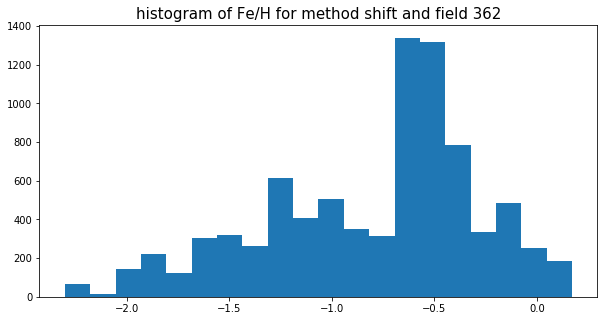

number of initial stars in field 47: 79938


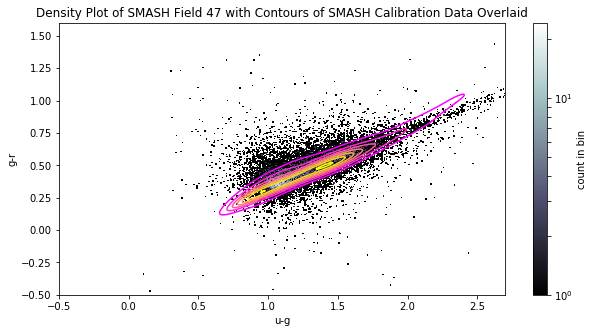

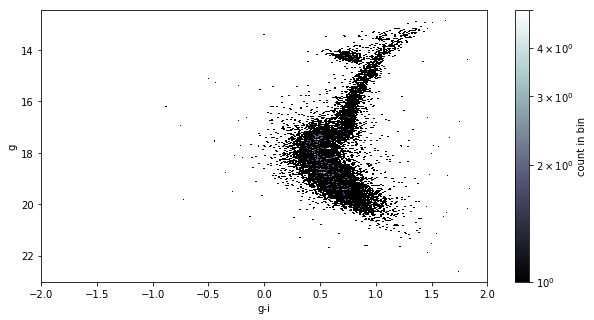

number of stars after cuts in field 47: 26256
metallicity for original method: -0.8767273810211011


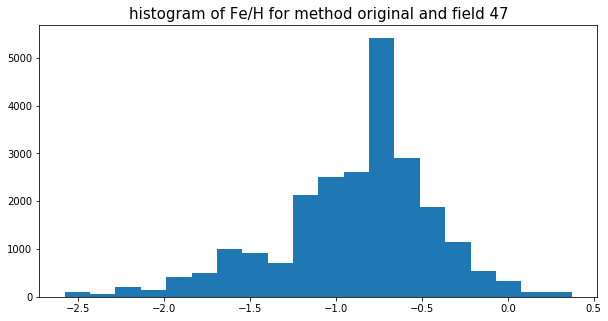

metallicity for iso method: -0.4263941562778208


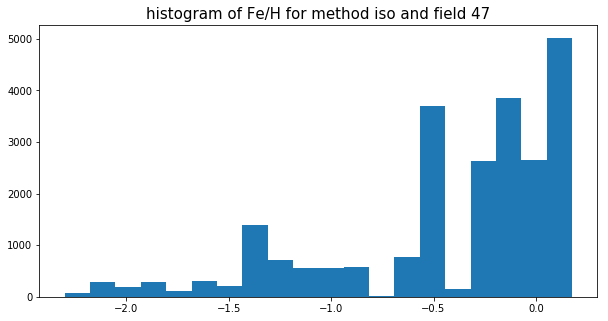

metallicity for iso_cut method: -0.4771579882438044


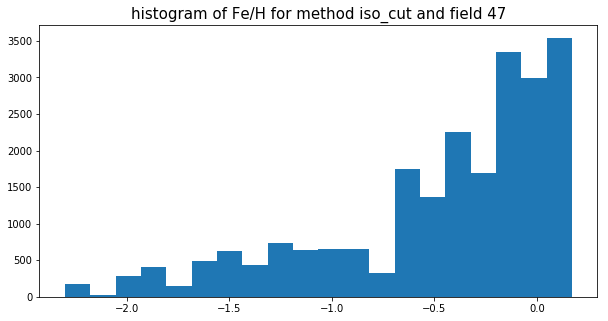

metallicity for shift method: -0.8150341013635433


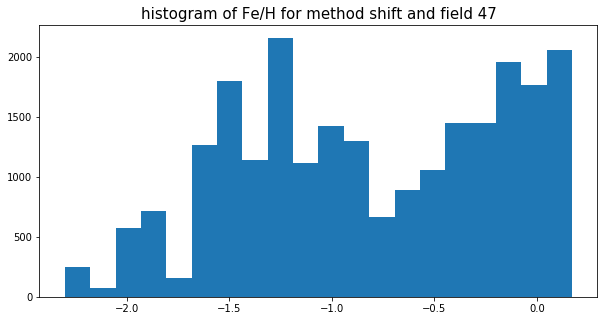

number of initial stars in field 1841: 3405


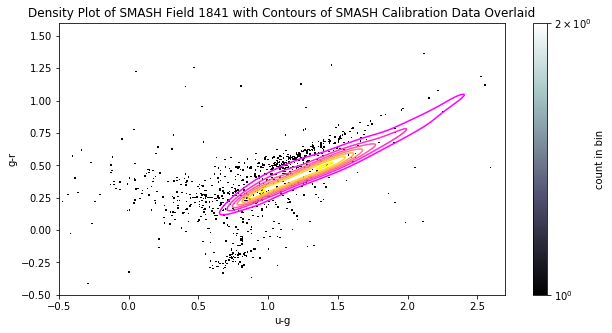

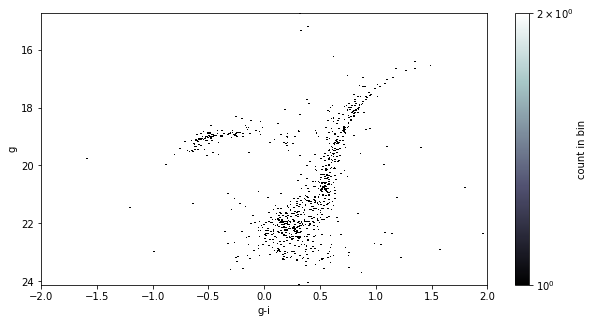

number of stars after cuts in field 1841: 858
metallicity for original method: -1.507768783650202


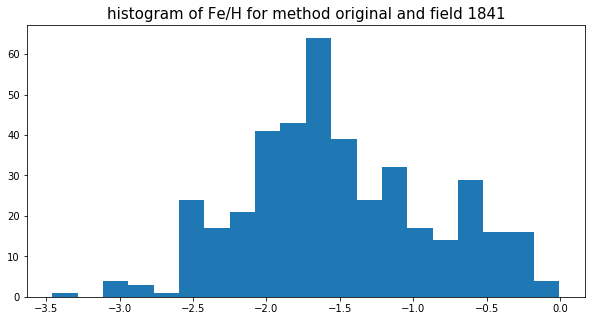

metallicity for iso method: -1.2489120478053772


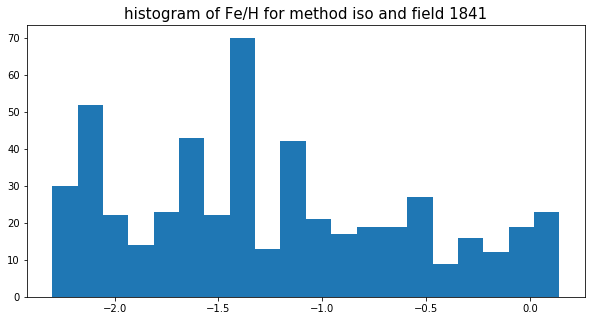

metallicity for iso_cut method: -1.2840522170066833


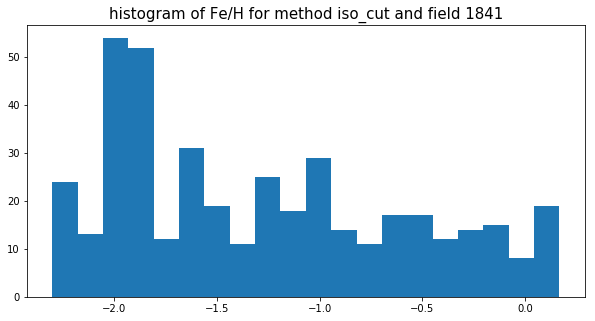

metallicity for shift method: -1.340595899671316


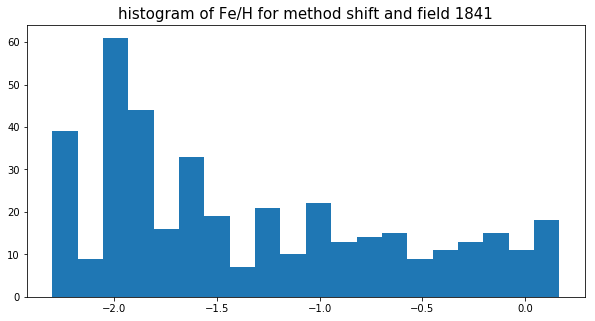

In [153]:

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC362_stars.fits')
    metallicity('/Users/amyel/research/SMASH_project/datafiles/47tuc_stars.fits')  
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

### Literature values
### NGC 362: -1.09 dex
### NGC1841: -2.02
### Tuc 47: -0.78

In [384]:

#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    #initial_stars.append(len(objs_new))
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=0.48)&((g-i)<=.8)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    g_i = g-i
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    fig, ax = plt.subplots(figsize=(10,5))
    hess = stats.binned_statistic_2d(u_g, g_r, None, 'count',bins=1000)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='bone',norm=clr.LogNorm())
    ax.contour(xx_cal,yy_cal,zz_cal,cmap='spring')
    cb = fig.colorbar(im,ax=ax,label='count in bin')
    ax.set_xlim(-.5,2.7)
    ax.set_ylim(-.5,1.6)
    ax.set_xlabel('u-g')
    ax.set_ylabel('g-r')
    ax.set_title('Density Plot of SMASH Field '+str(field_number[0])+' with Contours of SMASH Calibration Data Overlaid')
    
    
    plt.show(block=False)
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    #cut_stars.append(len(u))
    stars = len(u)
    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('original','iso','iso_cut','shift')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        N = np.count_nonzero(~np.isnan(feh))
        metal[method].append(np.nanmedian(feh))
        print("metallicity for "+method+" method:",(np.nanmean(feh)))
        #std[method].append(np.nanstd(feh))
        #error[method].append((np.nanstd(feh))/np.sqrt(N))
        fig,ax = plt.subplots(figsize=(10,5))
        ax.hist(feh[~np.isnan(feh)],bins=20)
        ax.set_title('histogram of Fe/H for method '+method+' and field '+str(field_number[0]),fontsize=15)
        plt.show(block=False)
    
    
    return 0


number of initial stars in field 362: 31344


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


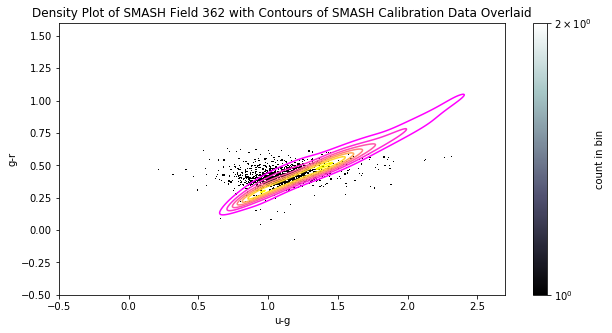

number of stars after cuts in field 362: 1866
metallicity for original method: -1.1191671913836474


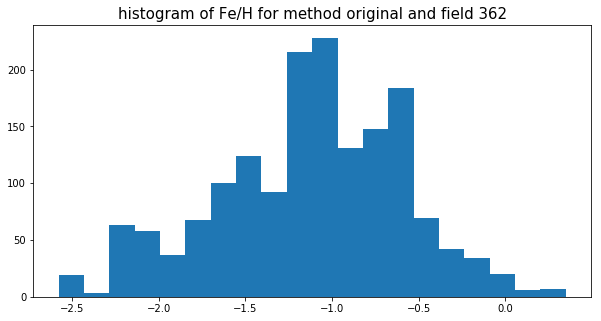

metallicity for iso method: -0.6729369025911212


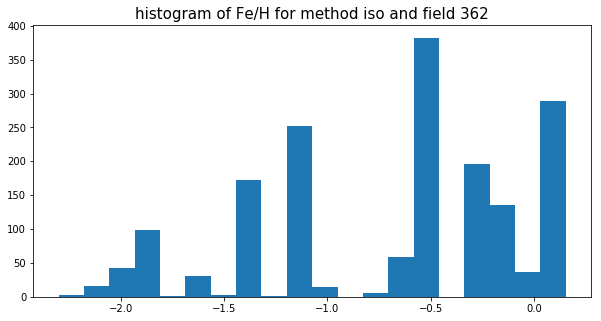

metallicity for iso_cut method: -0.7184534333101134


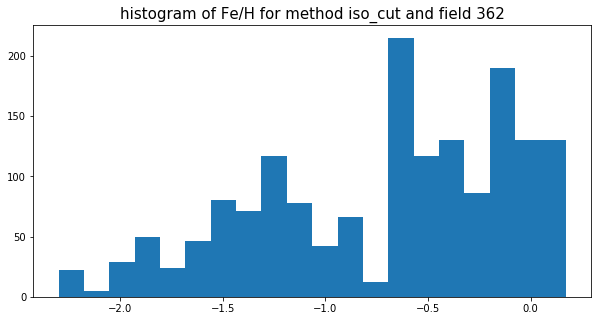

metallicity for shift method: -1.0932566651038627


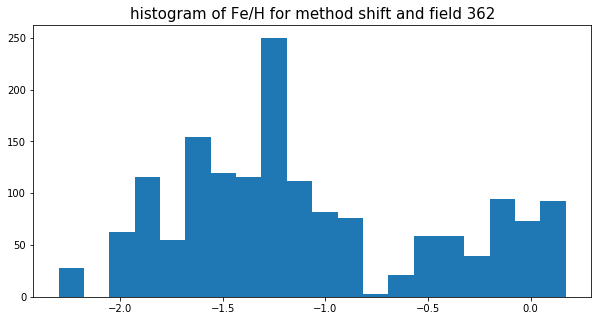

In [385]:
#selected = np.where(((g-i)>=0.48)&((g-i)<=.8)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC362_stars.fits')

number of initial stars in field 362: 31344


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


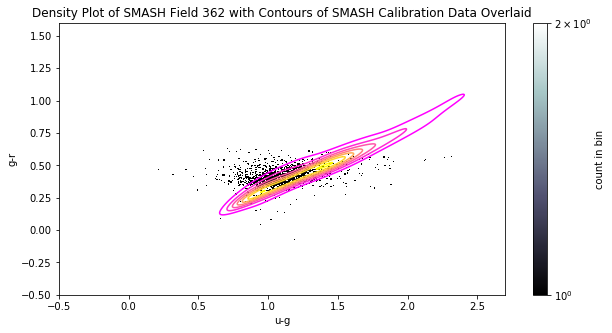

number of stars after cuts in field 362: 2076
metallicity for original method: -1.1180998008097893


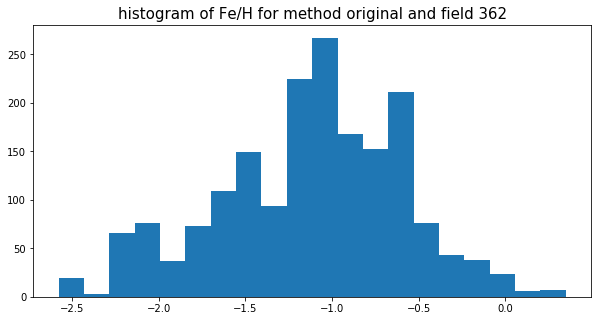

metallicity for iso method: -0.6610273222026136


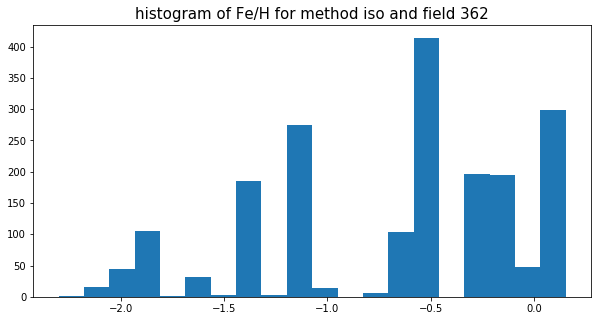

metallicity for iso_cut method: -0.7062694895241515


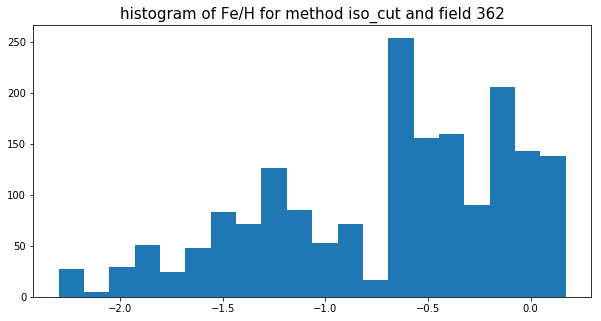

metallicity for shift method: -1.0888693544723944


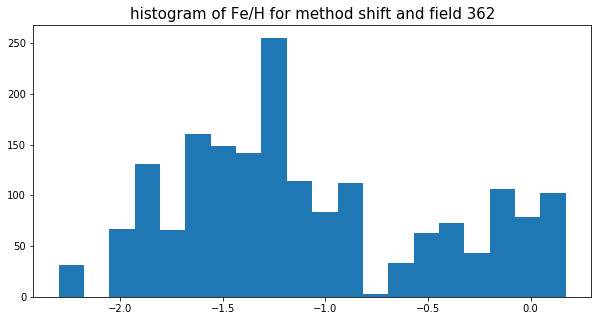

In [383]:
#selected = np.where(((g-i)>=0.47)&((g-i)<=.8)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC362_stars.fits')

number of initial stars in field 362: 31344


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


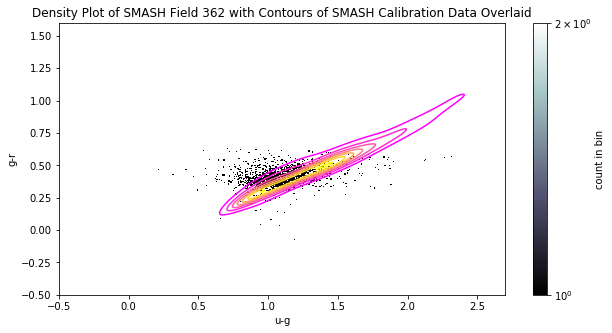

number of stars after cuts in field 362: 2290
metallicity for original method: -1.1141998213670332


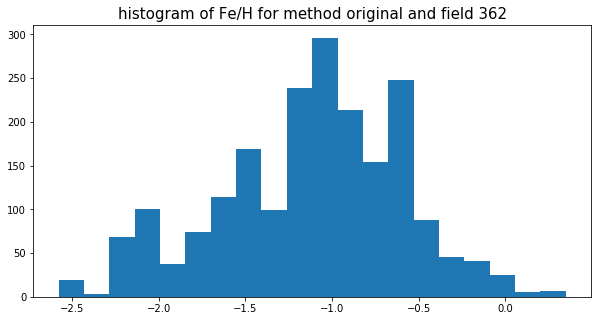

metallicity for iso method: -0.6403228918729852


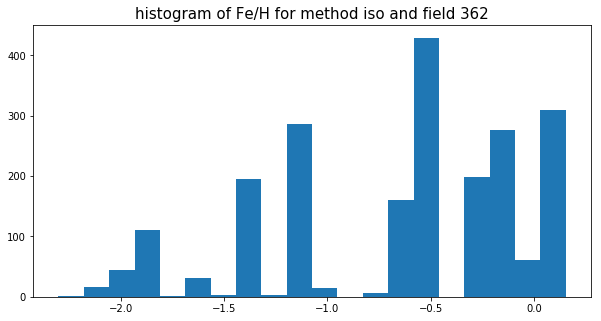

metallicity for iso_cut method: -0.6885289814283051


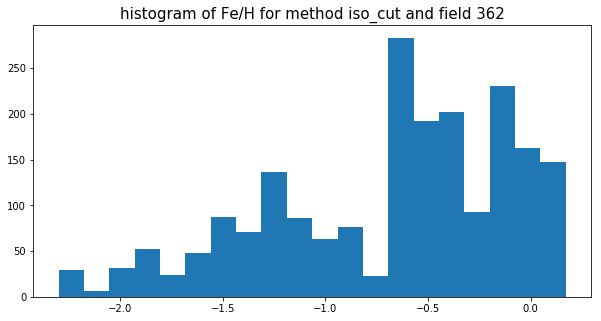

metallicity for shift method: -1.0791610561680085


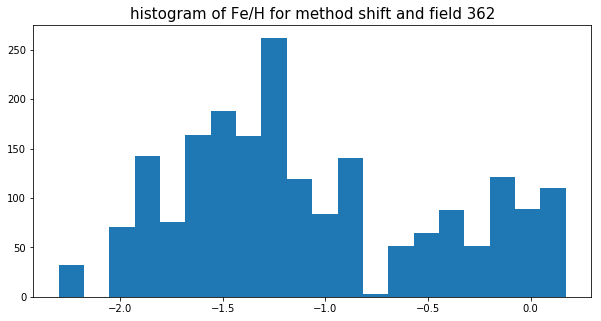

In [353]:
#selected = np.where(((g-i)>=0.46)&((g-i)<=.8)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC362_stars.fits')

number of initial stars in field 362: 31344


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


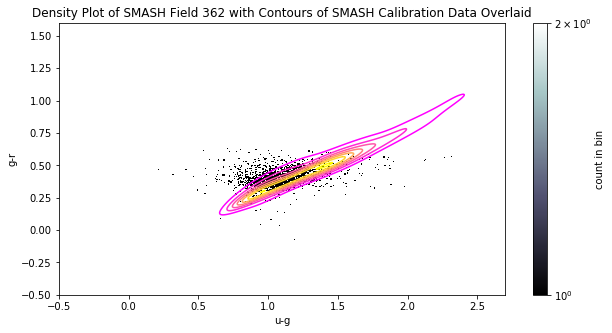

number of stars after cuts in field 362: 2494
metallicity for original method: -1.1122516578070012


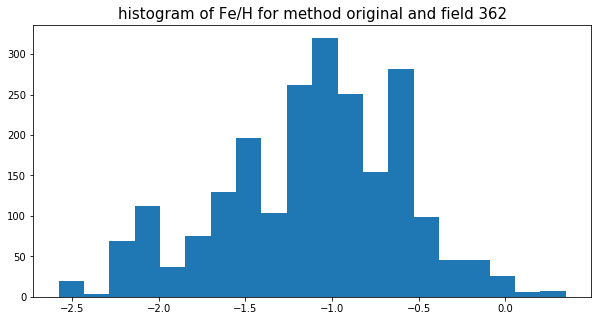

metallicity for iso method: -0.6246391497488931


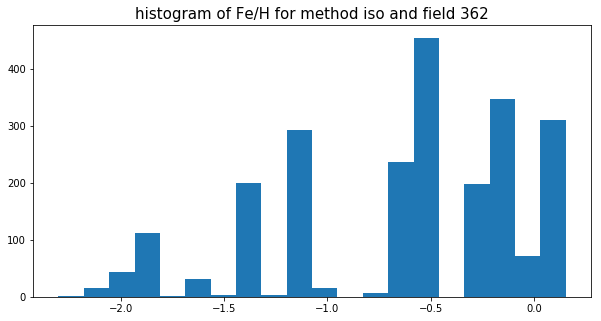

metallicity for iso_cut method: -0.6757822267505125


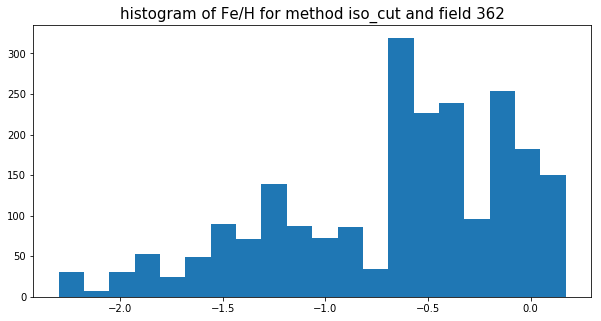

metallicity for shift method: -1.0631010137253272


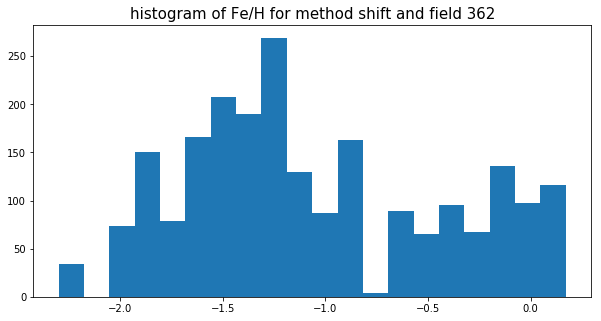

In [351]:
#selected = np.where(((g-i)>=0.45)&((g-i)<=.8)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC362_stars.fits')

In [356]:

#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    #initial_stars.append(len(objs_new))
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=.11)&((g-i)<=1)&(g>=18.25)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    g_i = g-i
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    fig, ax = plt.subplots(figsize=(10,5))
    hess = stats.binned_statistic_2d(u_g, g_r, None, 'count',bins=1000)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='bone',norm=clr.LogNorm())
    ax.contour(xx_cal,yy_cal,zz_cal,cmap='spring')
    cb = fig.colorbar(im,ax=ax,label='count in bin')
    ax.set_xlim(-.5,2.7)
    ax.set_ylim(-.5,1.6)
    ax.set_xlabel('u-g')
    ax.set_ylabel('g-r')
    ax.set_title('Density Plot of SMASH Field '+str(field_number[0])+' with Contours of SMASH Calibration Data Overlaid')
    
    
    plt.show(block=False)
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    #cut_stars.append(len(u))
    stars = len(u)
    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('original','iso','iso_cut','shift')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        N = np.count_nonzero(~np.isnan(feh))
        metal[method].append(np.nanmedian(feh))
        print("metallicity for "+method+" method:",(np.nanmean(feh)))
        #std[method].append(np.nanstd(feh))
        #error[method].append((np.nanstd(feh))/np.sqrt(N))
        fig,ax = plt.subplots(figsize=(10,5))
        ax.hist(feh[~np.isnan(feh)],bins=20)
        ax.set_title('histogram of Fe/H for method '+method+' and field '+str(field_number[0]),fontsize=15)
        plt.show(block=False)
    
    
    return 0


number of initial stars in field 47: 79938


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


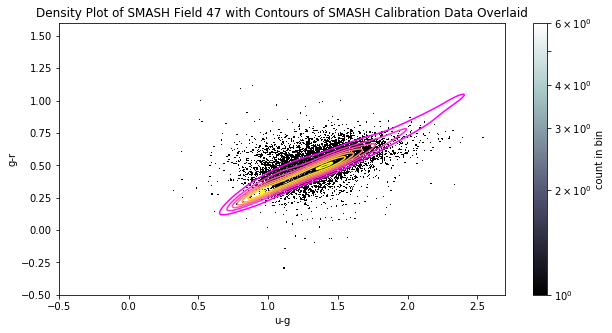

number of stars after cuts in field 47: 12633
metallicity for original method: -0.8531894790998164


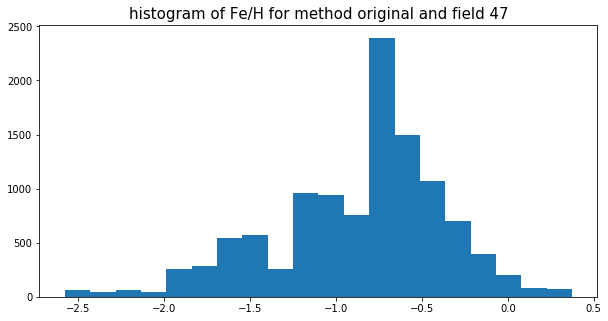

metallicity for iso method: -0.4396566229247996


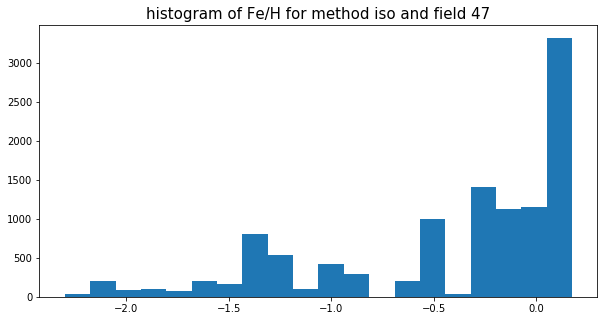

metallicity for iso_cut method: -0.5032111299217022


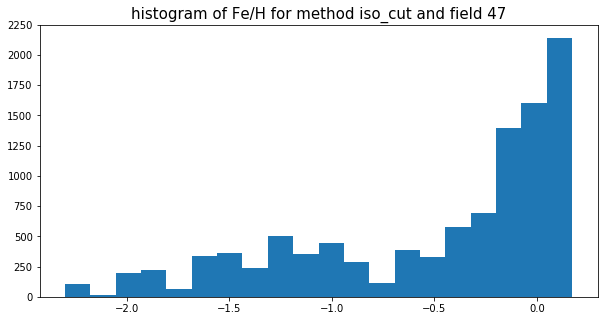

metallicity for shift method: -0.78773984105397


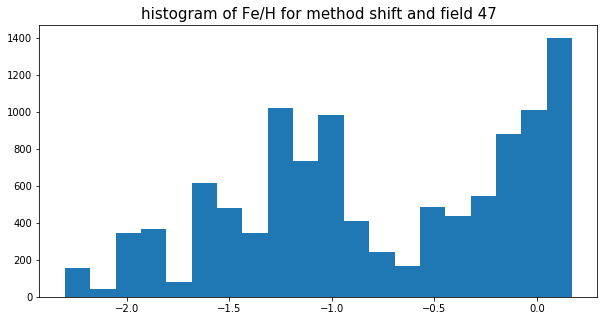

In [357]:
#selected = np.where(((g-i)>=.11)&((g-i)<=1)&(g>=18.25)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/47tuc_stars.fits')

number of initial stars in field 47: 79938


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


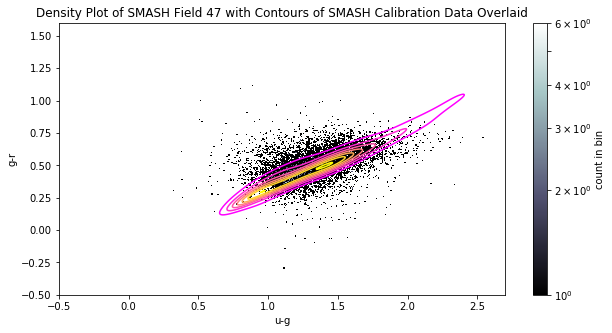

number of stars after cuts in field 47: 12630
metallicity for original method: -0.8531551671751217


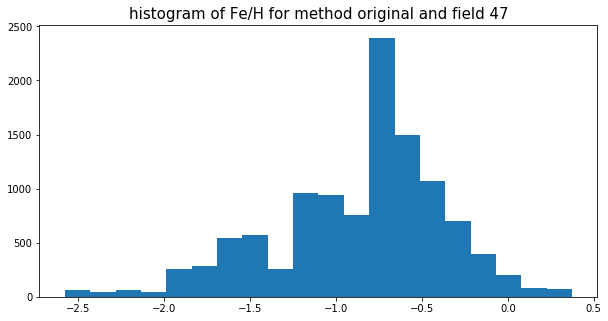

metallicity for iso method: -0.4396589645069629


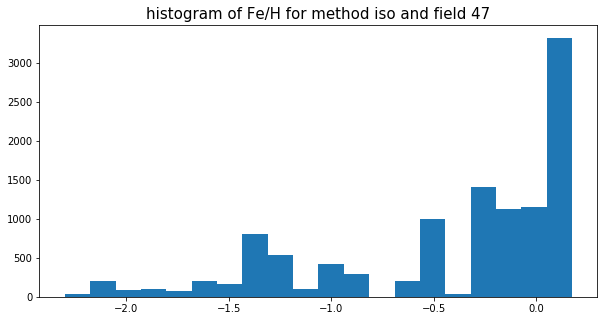

metallicity for iso_cut method: -0.5031998952306367


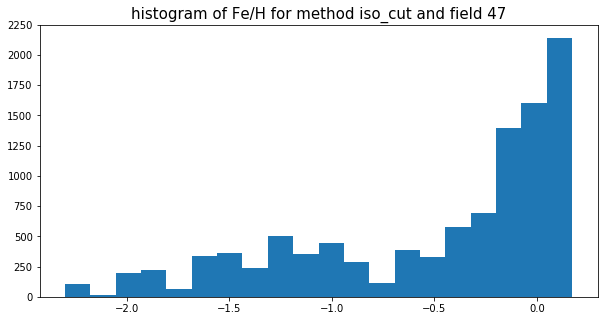

metallicity for shift method: -0.7877708506136745


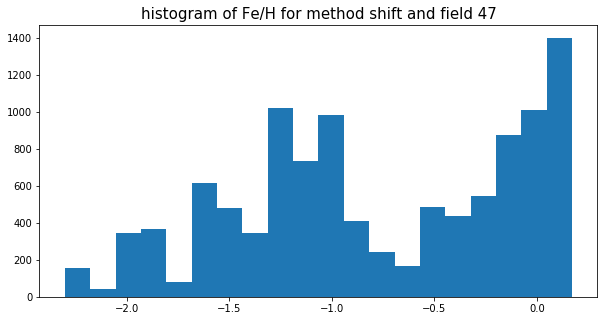

In [355]:
#selected = np.where(((g-i)>=.12)&((g-i)<=1)&(g>=18.25)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/47tuc_stars.fits')

number of initial stars in field 47: 79938


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


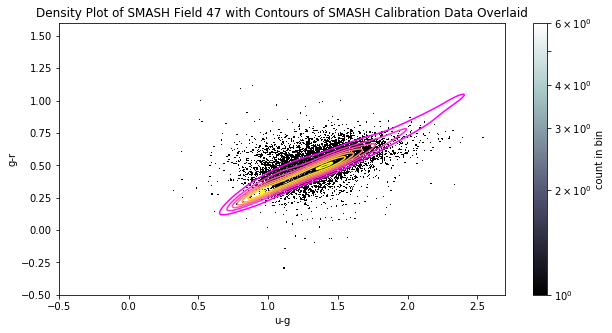

number of stars after cuts in field 47: 12634
metallicity for original method: -0.8531526102248735


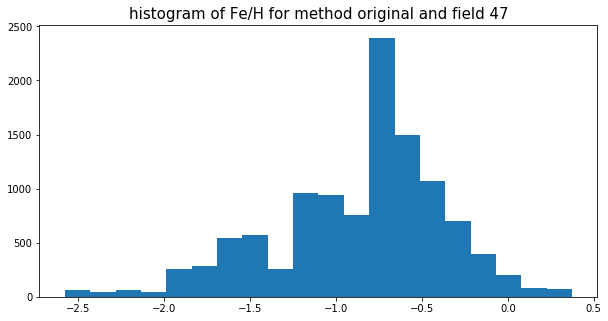

metallicity for iso method: -0.43963079825539725


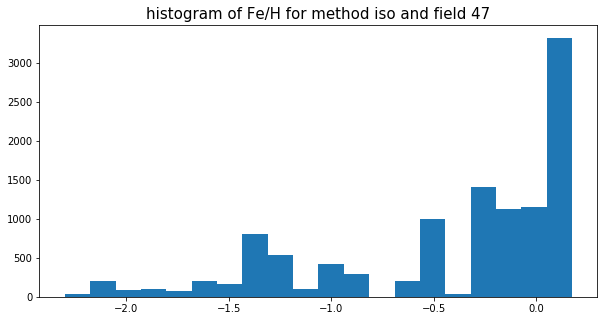

metallicity for iso_cut method: -0.5031697175223838


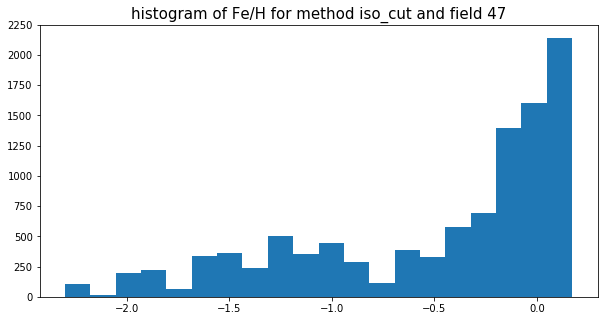

metallicity for shift method: -0.7876631102932189


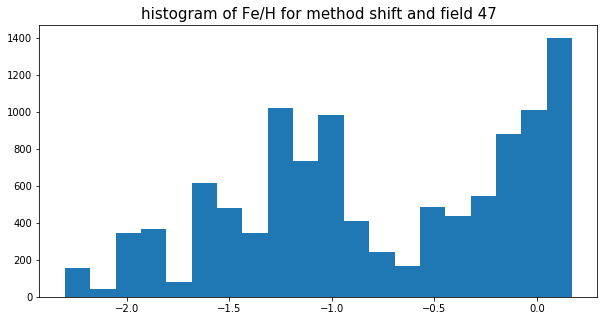

In [300]:
#selected = np.where(((g-i)>=.1)&((g-i)<=1)&(g>=18.25)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/47tuc_stars.fits')

In [392]:

#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    #initial_stars.append(len(objs_new))
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=.65)&((g-i)<=.93)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    g_i = g-i
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    fig, ax = plt.subplots(figsize=(10,5))
    hess = stats.binned_statistic_2d(u_g, g_r, None, 'count',bins=1000)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='bone',norm=clr.LogNorm())
    ax.contour(xx_cal,yy_cal,zz_cal,cmap='spring')
    cb = fig.colorbar(im,ax=ax,label='count in bin')
    ax.set_xlim(-.5,2.7)
    ax.set_ylim(-.5,1.6)
    ax.set_xlabel('u-g')
    ax.set_ylabel('g-r')
    ax.set_title('Density Plot of SMASH Field '+str(field_number[0])+' with Contours of SMASH Calibration Data Overlaid')
    
    
    plt.show(block=False)
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    #cut_stars.append(len(u))
    stars = len(u)
    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('original','iso','iso_cut','shift')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        N = np.count_nonzero(~np.isnan(feh))
        metal[method].append(np.nanmedian(feh))
        print("metallicity for "+method+" method:",(np.nanmean(feh)))
        #std[method].append(np.nanstd(feh))
        #error[method].append((np.nanstd(feh))/np.sqrt(N))
        fig,ax = plt.subplots(figsize=(10,5))
        ax.hist(feh[~np.isnan(feh)],bins=20)
        ax.set_title('histogram of Fe/H for method '+method+' and field '+str(field_number[0]),fontsize=15)
        plt.show(block=False)
    
    
    return 0


number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


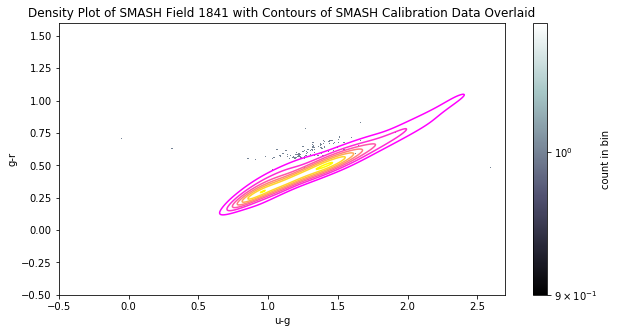

number of stars after cuts in field 1841: 105
metallicity for original method: -1.6975874103290933


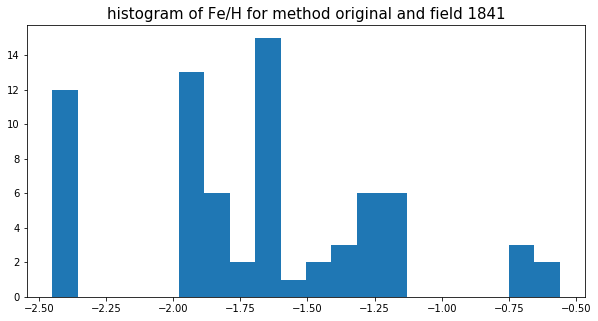

metallicity for iso method: -1.486933974215859


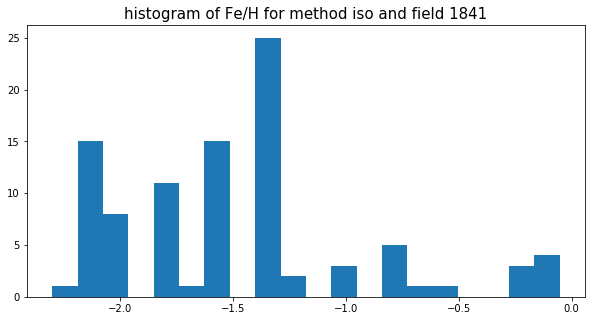

metallicity for iso_cut method: -1.6512856525044108


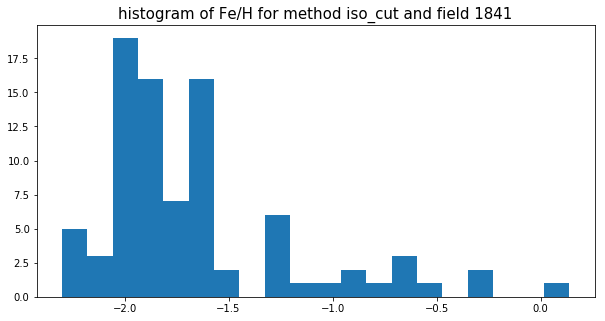

metallicity for shift method: -1.8028696448572221


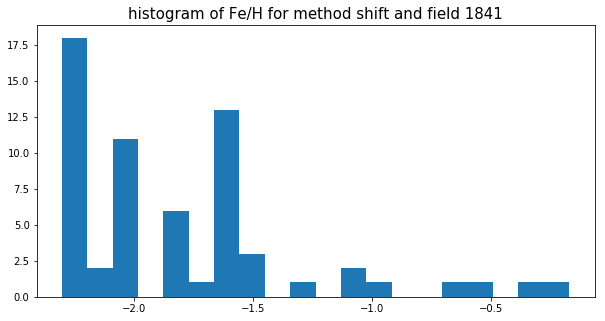

In [389]:
#selected = np.where(((g-i)>=.63)&((g-i)<=.93)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


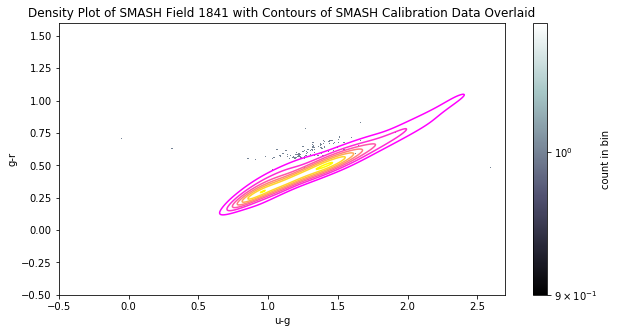

number of stars after cuts in field 1841: 105
metallicity for original method: -1.6975874103290933


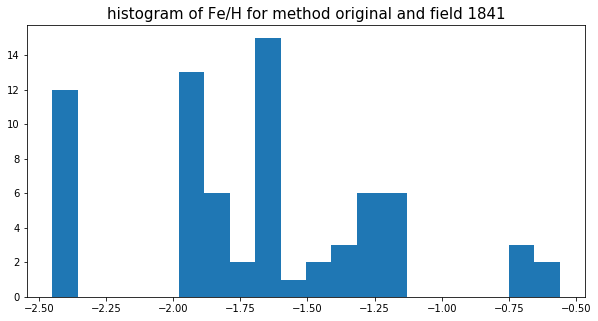

metallicity for iso method: -1.486933974215859


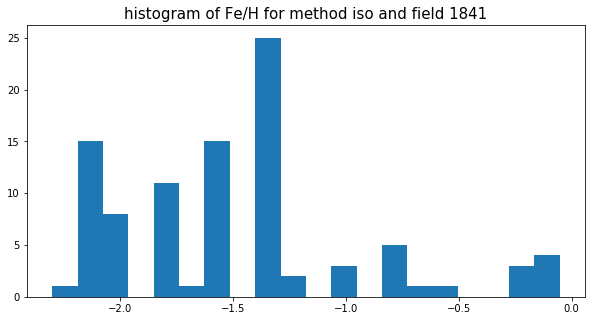

metallicity for iso_cut method: -1.6512856525044108


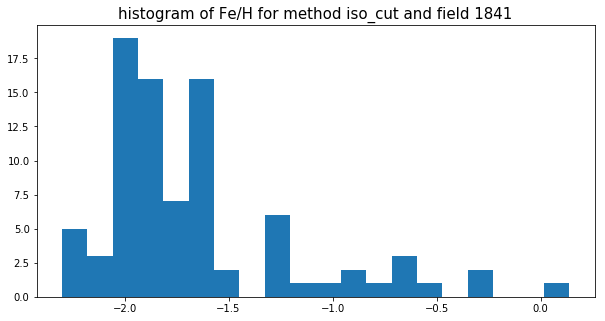

metallicity for shift method: -1.8028696448572221


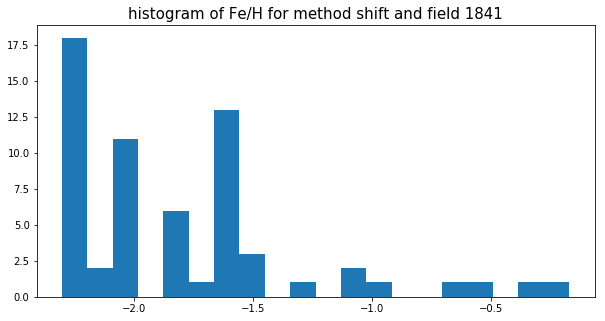

In [387]:
#selected = np.where(((g-i)>=.63)&((g-i)<=.94)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


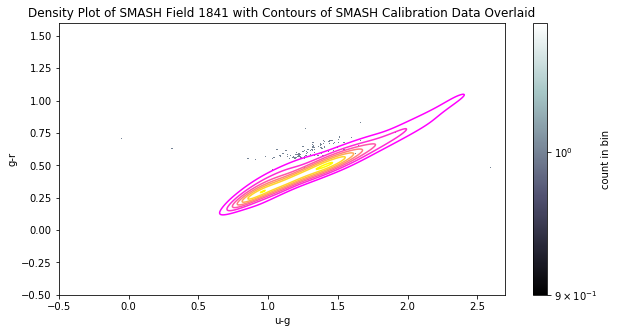

number of stars after cuts in field 1841: 105
metallicity for original method: -1.6975874103290933


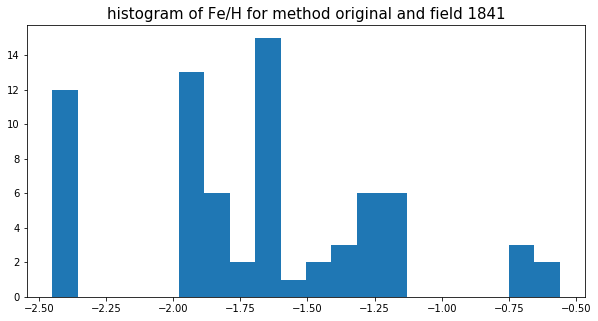

metallicity for iso method: -1.486933974215859


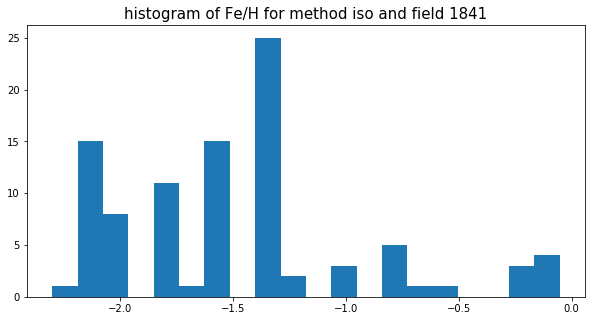

metallicity for iso_cut method: -1.6512856525044108


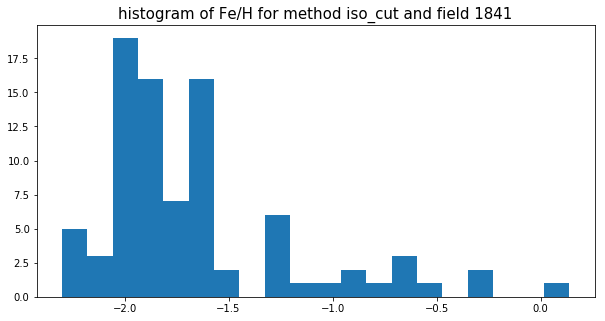

metallicity for shift method: -1.8028696448572221


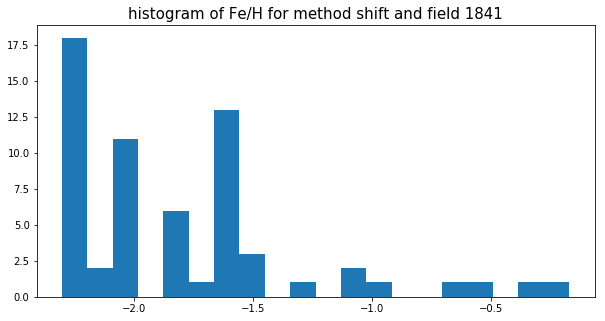

In [381]:
#selected = np.where(((g-i)>=.63)&((g-i)<=.95)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


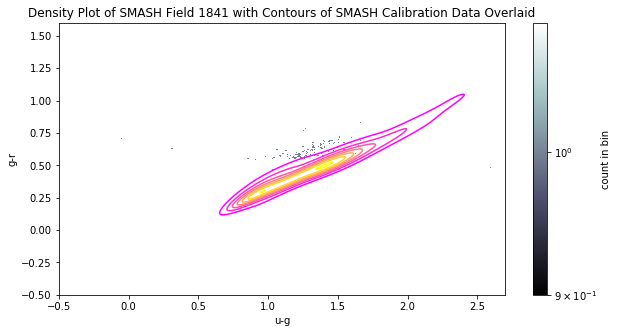

number of stars after cuts in field 1841: 106
metallicity for original method: -1.6975874103290933


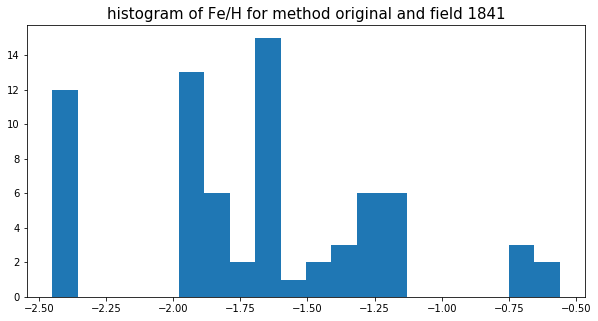

metallicity for iso method: -1.486933974215859


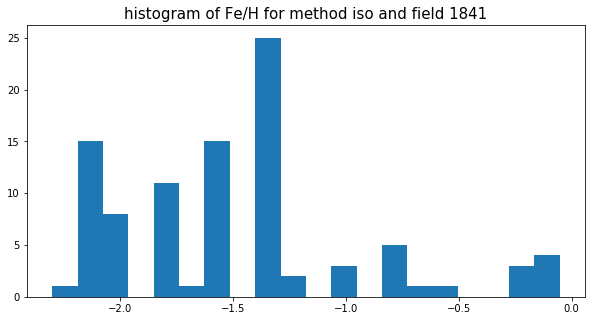

metallicity for iso_cut method: -1.6512856525044108


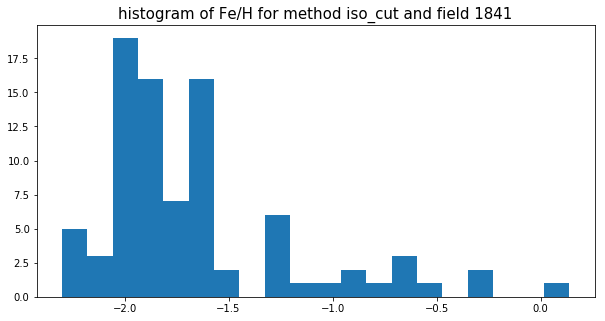

metallicity for shift method: -1.8028696448572221


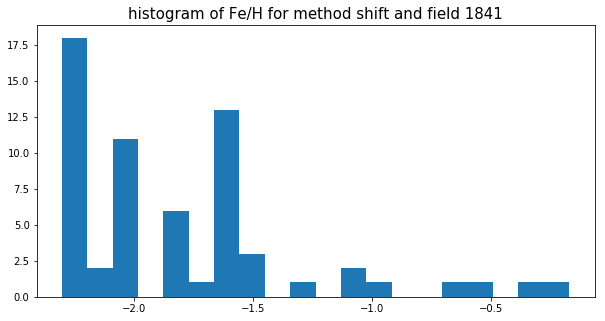

In [379]:
#selected = np.where(((g-i)>=.63)&((g-i)<=.96)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


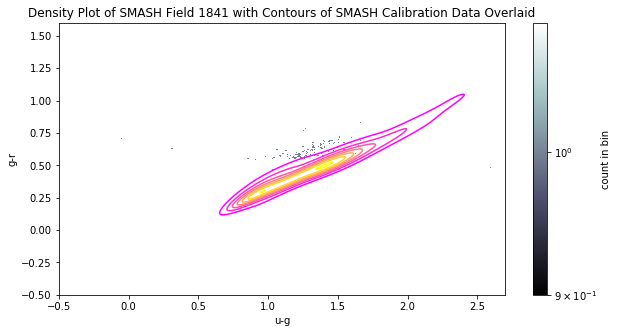

number of stars after cuts in field 1841: 106
metallicity for original method: -1.6975874103290933


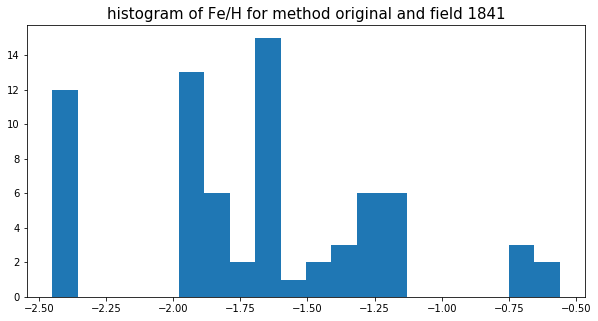

metallicity for iso method: -1.486933974215859


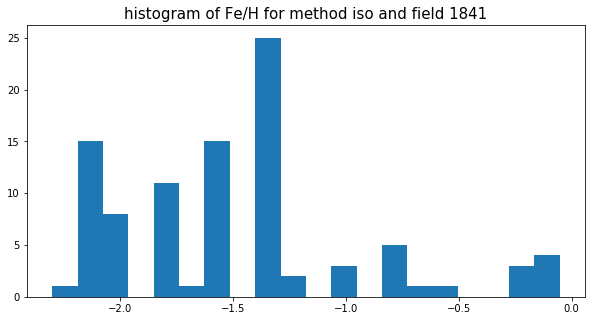

metallicity for iso_cut method: -1.6512856525044108


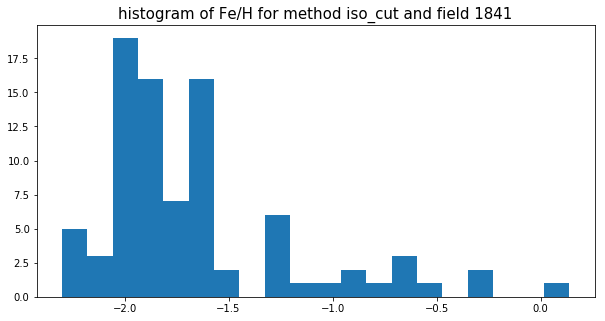

metallicity for shift method: -1.8028696448572221


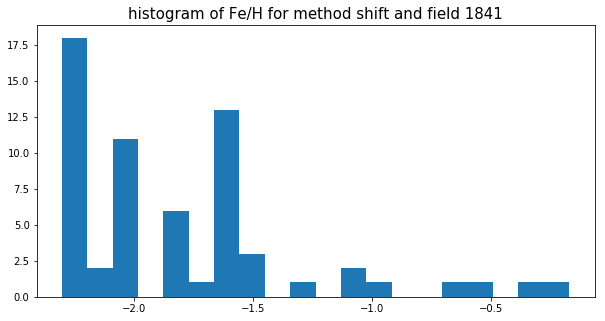

In [377]:
#selected = np.where(((g-i)>=.63)&((g-i)<=.97)&(g>=18)&(g<=23)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


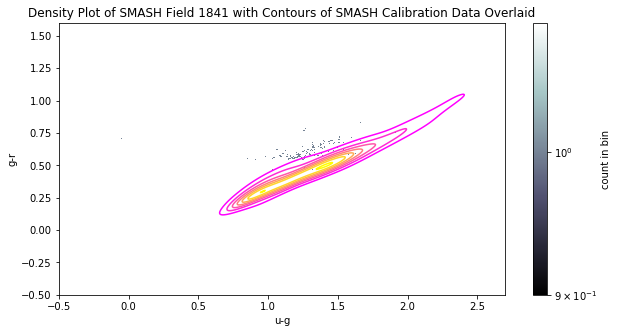

number of stars after cuts in field 1841: 114
metallicity for original method: -1.7016524069103194


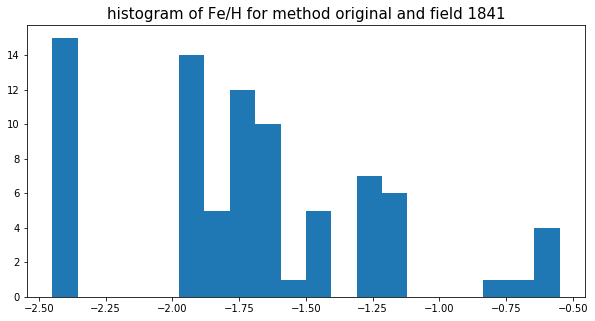

metallicity for iso method: -1.461774966830299


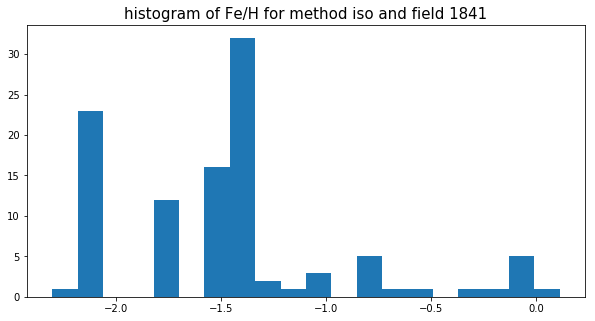

metallicity for iso_cut method: -1.6385331420848768


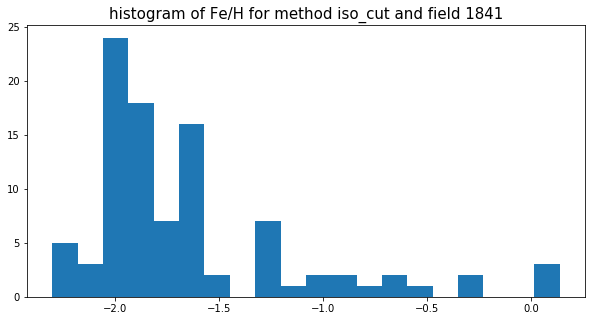

metallicity for shift method: -1.7982157361176279


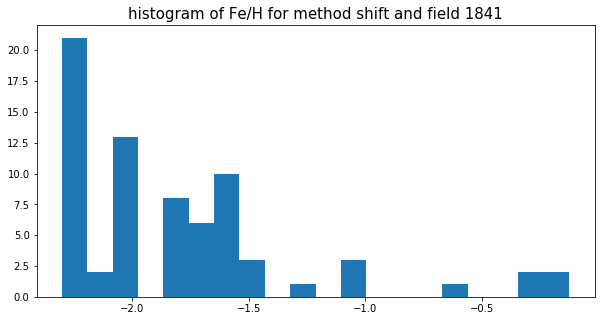

In [369]:
#selected = np.where(((g-i)>=.62)&((g-i)<=.97)&(g>=18)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


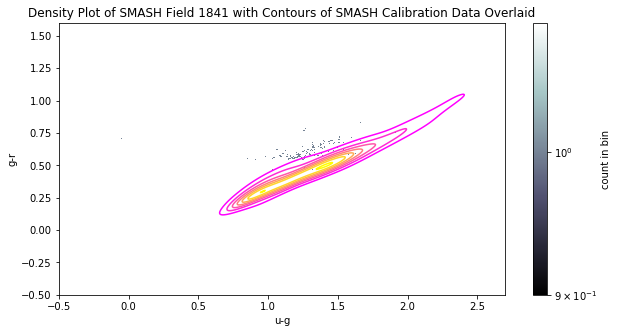

number of stars after cuts in field 1841: 114
metallicity for original method: -1.7016524069103194


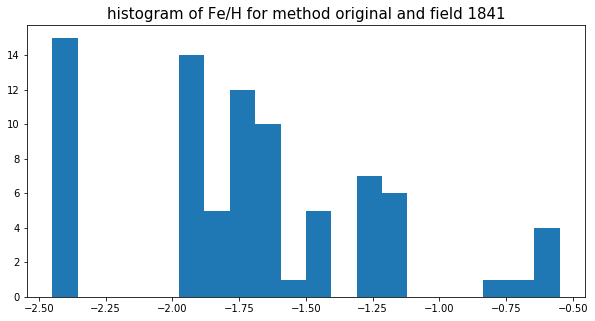

metallicity for iso method: -1.461774966830299


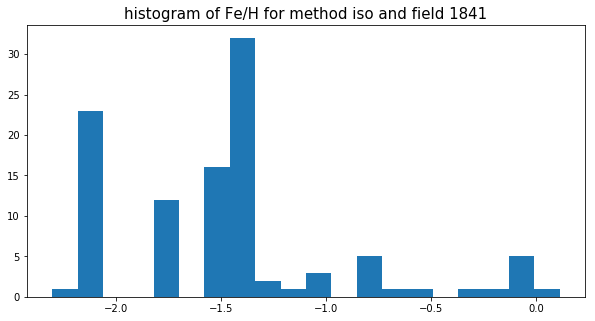

metallicity for iso_cut method: -1.6385331420848768


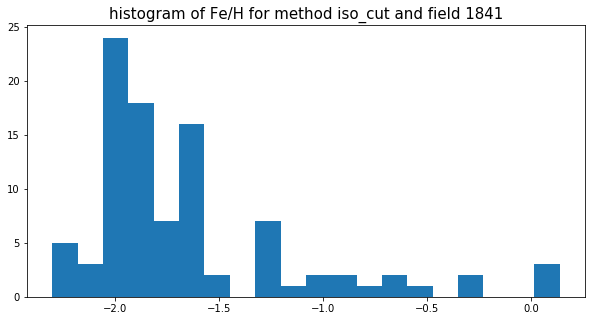

metallicity for shift method: -1.7982157361176279


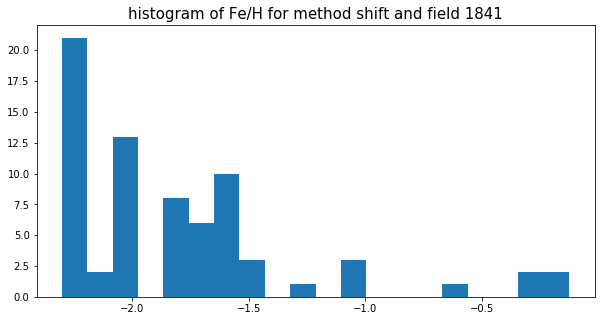

In [367]:
#selected = np.where(((g-i)>=.62)&((g-i)<=.98)&(g>=18)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


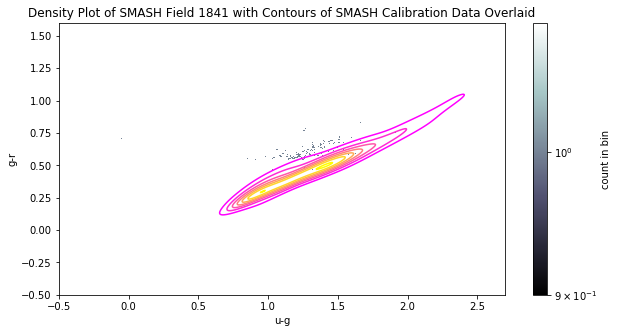

number of stars after cuts in field 1841: 114
metallicity for original method: -1.7016524069103194


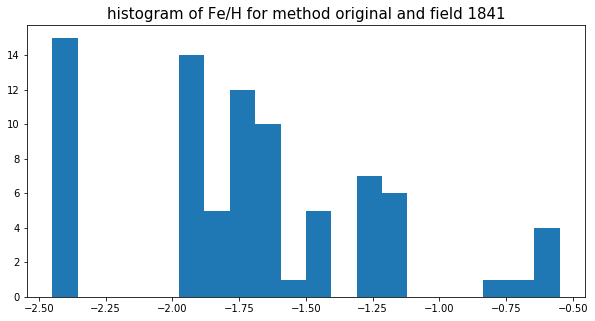

metallicity for iso method: -1.461774966830299


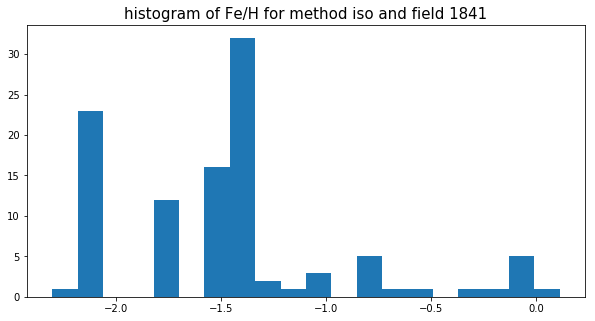

metallicity for iso_cut method: -1.6385331420848768


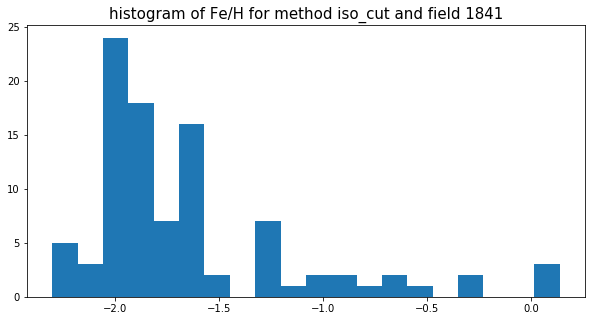

metallicity for shift method: -1.7982157361176279


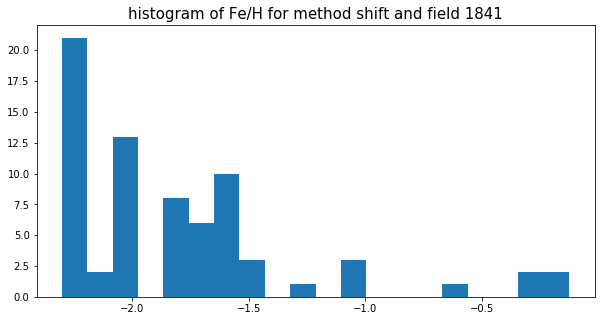

In [365]:
#selected = np.where(((g-i)>=.62)&((g-i)<=.99)&(g>=18)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


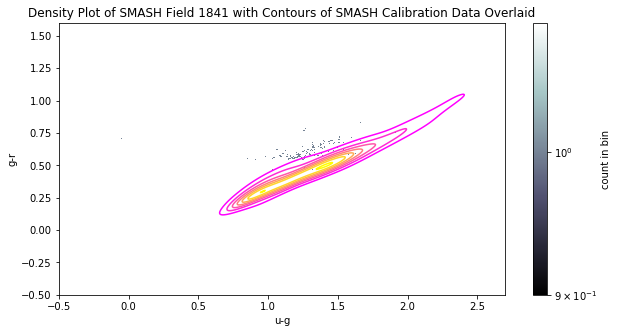

number of stars after cuts in field 1841: 114
metallicity for original method: -1.7016524069103194


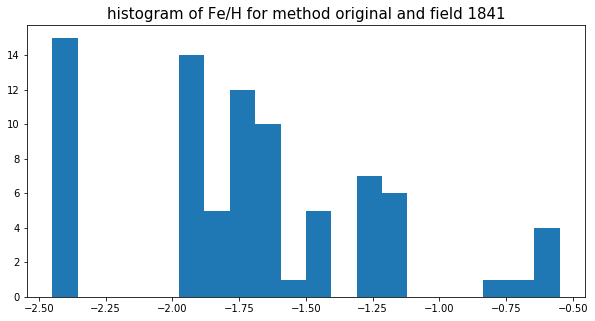

metallicity for iso method: -1.461774966830299


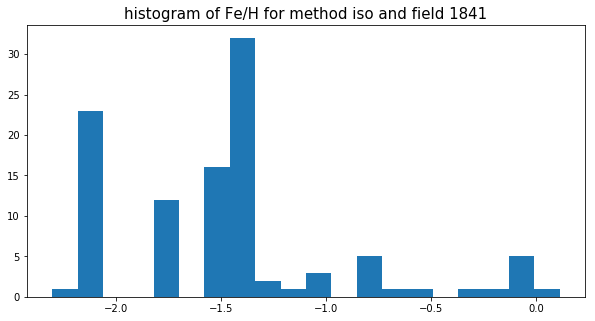

metallicity for iso_cut method: -1.6385331420848768


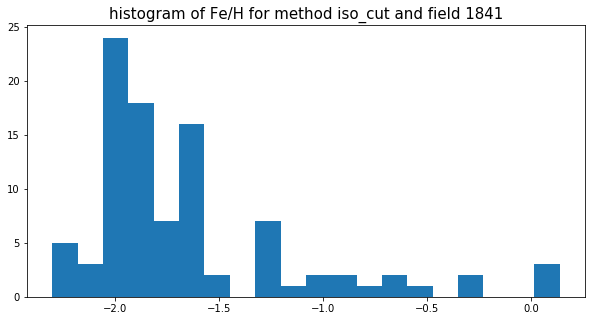

metallicity for shift method: -1.7982157361176279


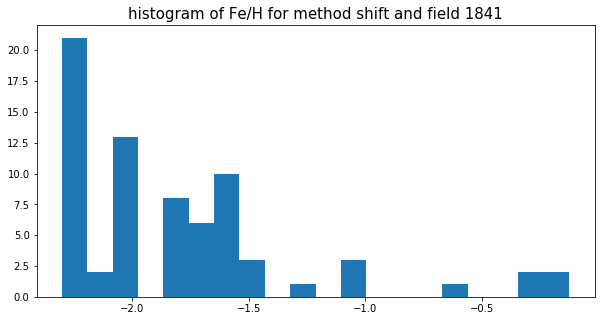

In [363]:
#selected = np.where(((g-i)>=.62)&((g-i)<=1)&(g>=18)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


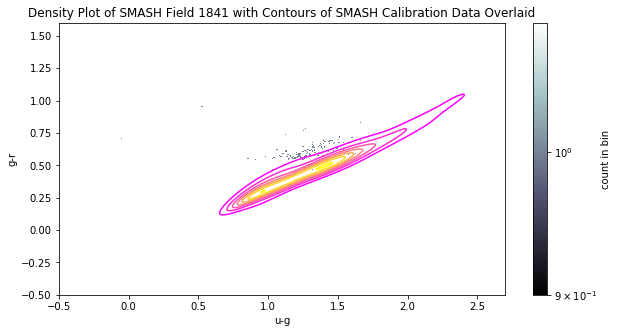

number of stars after cuts in field 1841: 117
metallicity for original method: -1.686571280040392


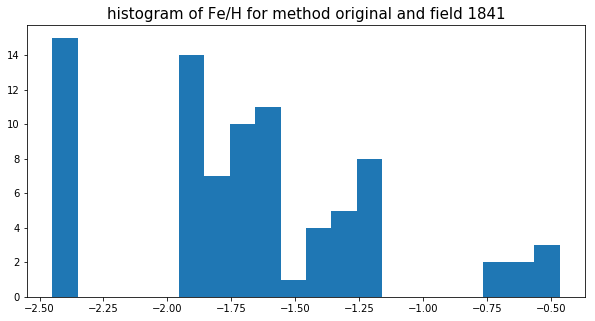

metallicity for iso method: -1.448578824412148


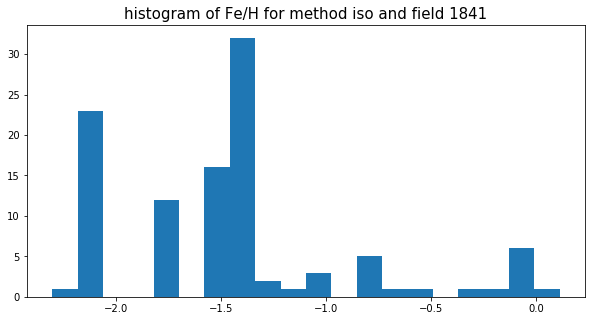

metallicity for iso_cut method: -1.6223424285957493


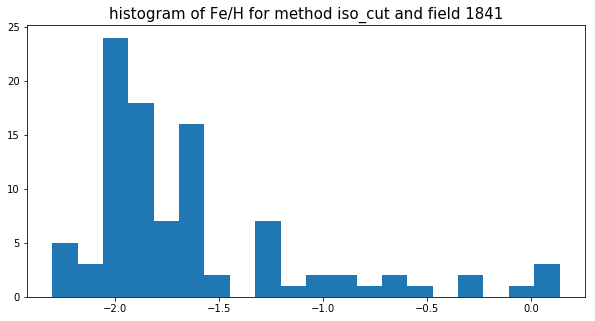

metallicity for shift method: -1.7837843903123516


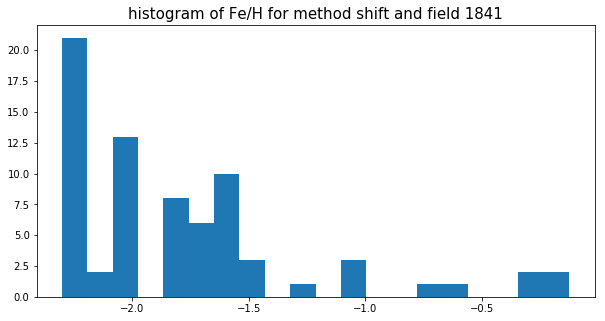

In [361]:
#selected = np.where(((g-i)>=.62)&((g-i)<=1.1)&(g>=18)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


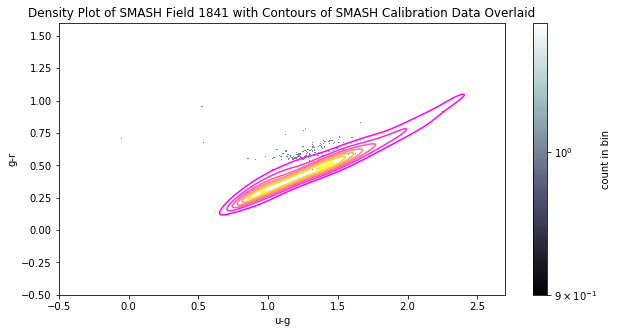

number of stars after cuts in field 1841: 126
metallicity for original method: -1.6721710532568814


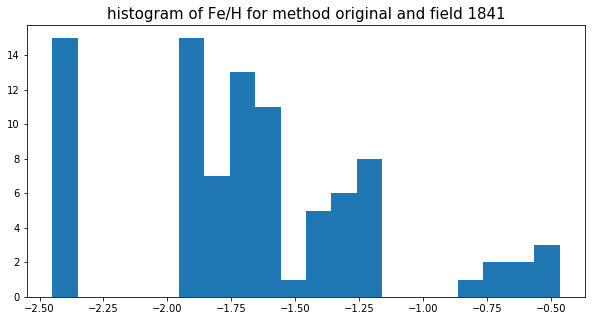

metallicity for iso method: -1.436338838778044


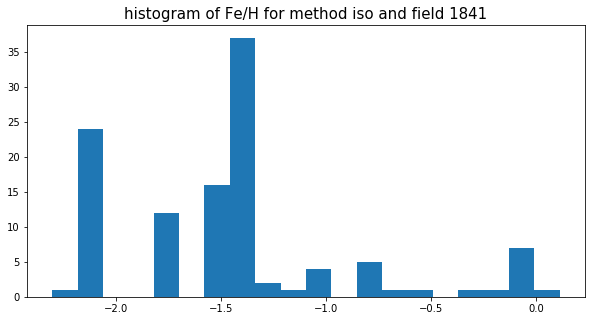

metallicity for iso_cut method: -1.6089032428605217


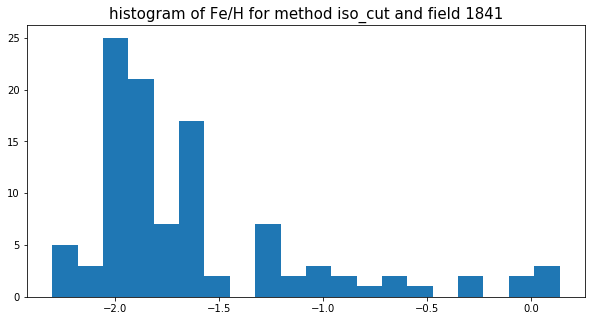

metallicity for shift method: -1.7662475802004338


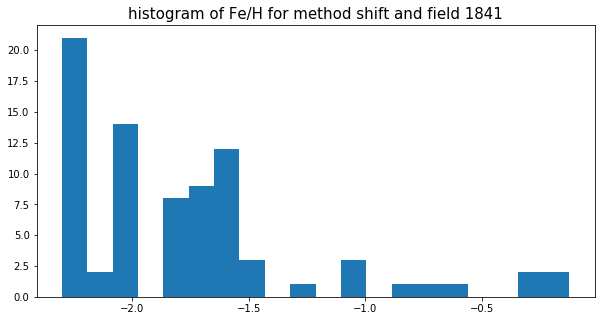

In [359]:
#selected = np.where(((g-i)>=.61)&((g-i)<=1.1)&(g>=18)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


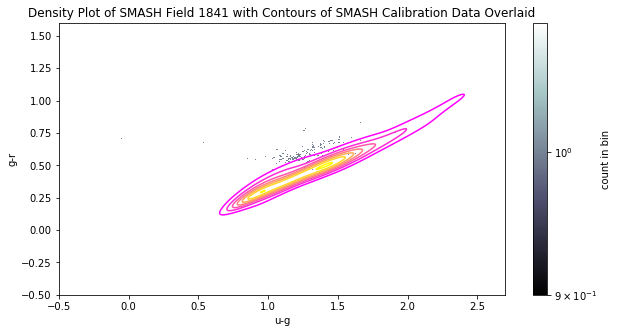

number of stars after cuts in field 1841: 136
metallicity for original method: -1.710526774732434


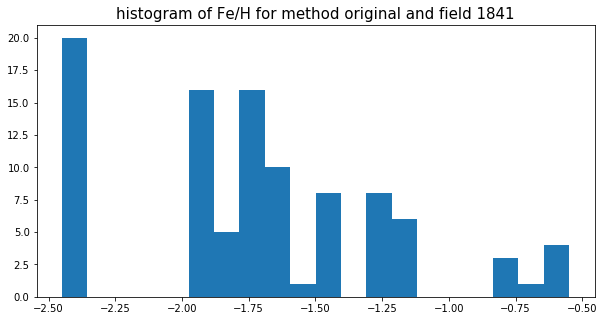

metallicity for iso method: -1.4549603925810919


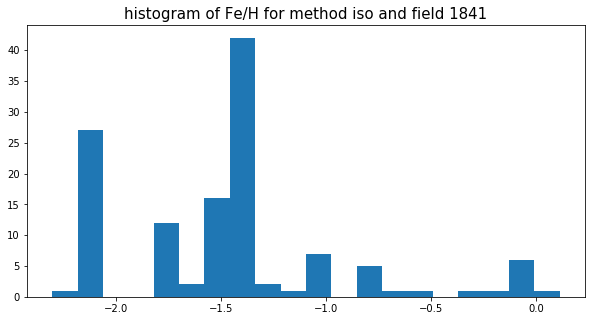

metallicity for iso_cut method: -1.6191444998202116


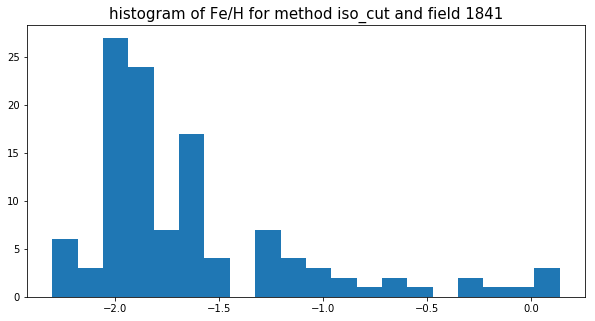

metallicity for shift method: -1.7694472174965934


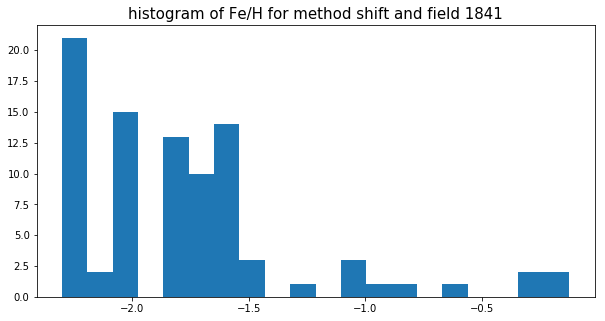

In [325]:
#selected = np.where(((g-i)>=.6)&((g-i)<=1.1)&(g>=18)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


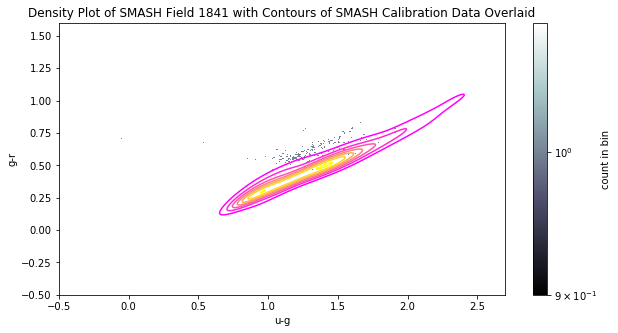

number of stars after cuts in field 1841: 160
metallicity for original method: -1.684295758063143


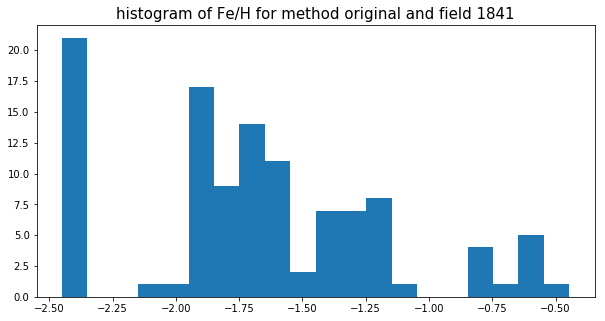

metallicity for iso method: -1.4431758132335302


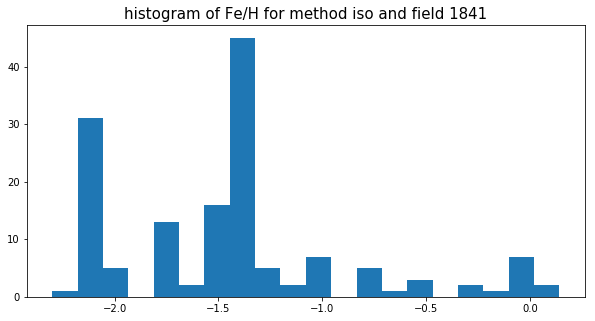

metallicity for iso_cut method: -1.6066397678020388


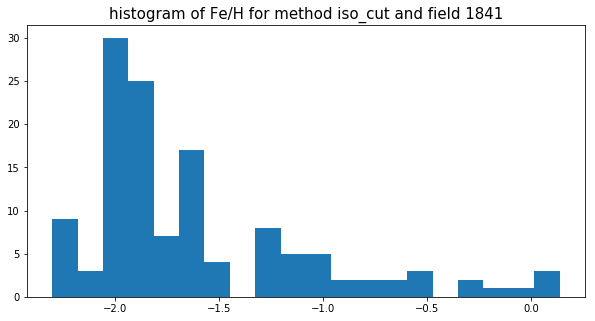

metallicity for shift method: -1.7576389236025292


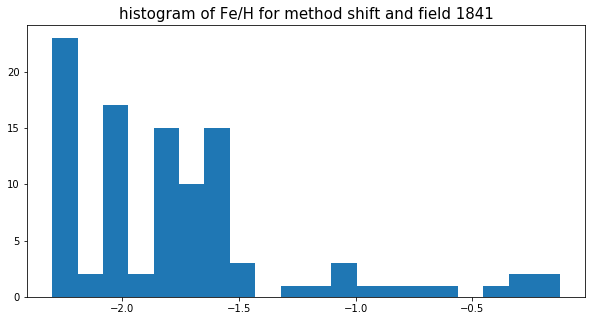

In [323]:
#selected = np.where(((g-i)>=.6)&((g-i)<=1.1)&(g>=17.5)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


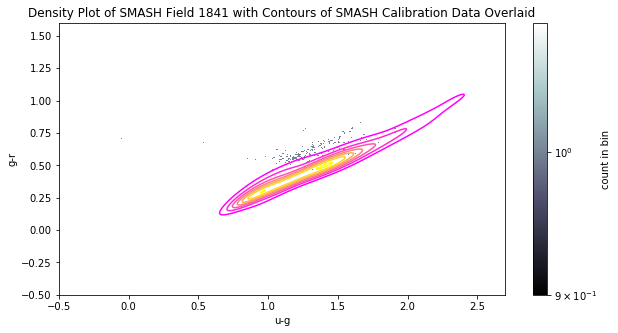

number of stars after cuts in field 1841: 160
metallicity for original method: -1.684295758063143


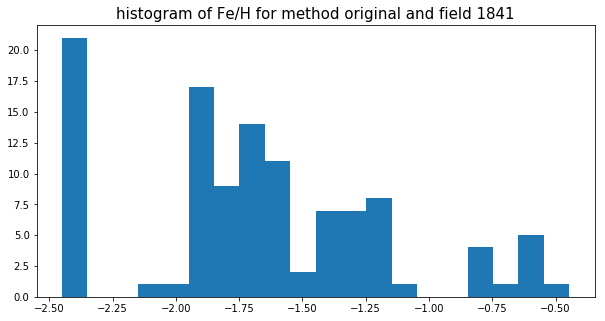

metallicity for iso method: -1.4431758132335302


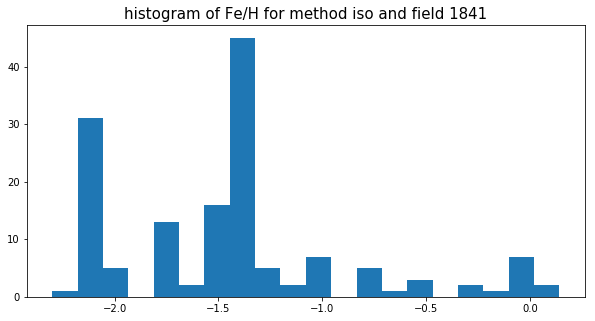

metallicity for iso_cut method: -1.6066397678020388


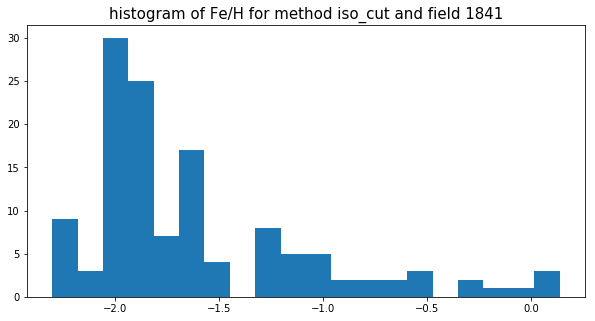

metallicity for shift method: -1.7576389236025292


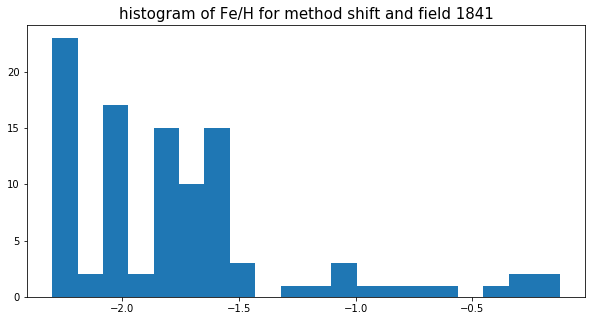

In [320]:
#selected = np.where(((g-i)>=.6)&((g-i)<=1)&(g>=17.5)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


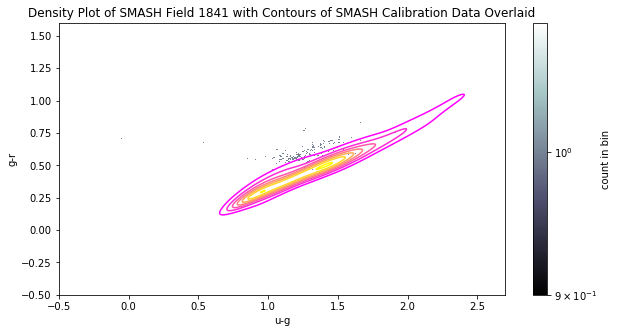

number of stars after cuts in field 1841: 136
metallicity for original method: -1.710526774732434


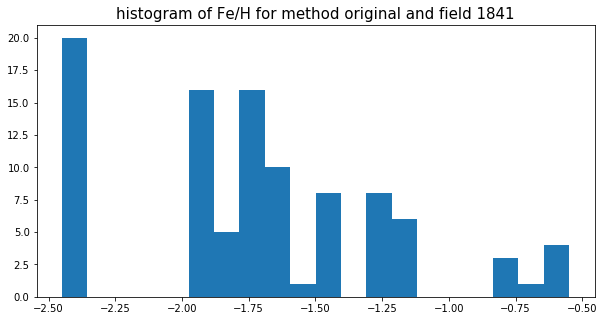

metallicity for iso method: -1.4549603925810919


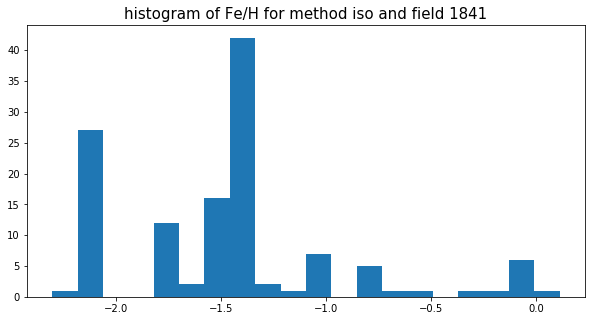

metallicity for iso_cut method: -1.6191444998202116


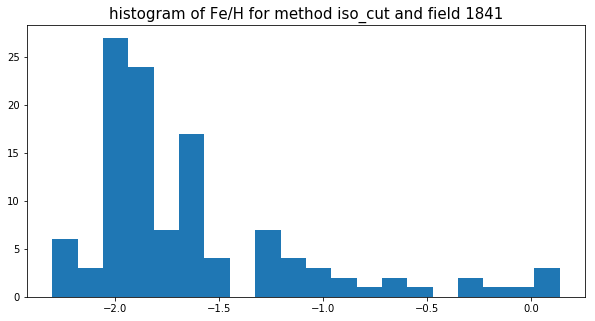

metallicity for shift method: -1.7694472174965934


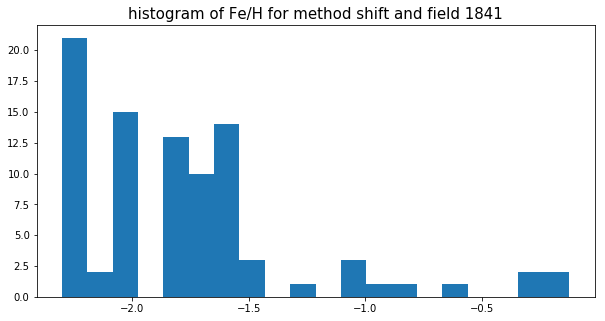

In [316]:
#selected = np.where(((g-i)>=.6)&((g-i)<=1)&(g>=18)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


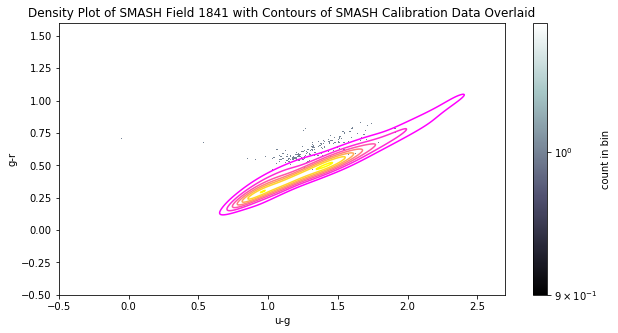

number of stars after cuts in field 1841: 166
metallicity for original method: -1.6828849181137253


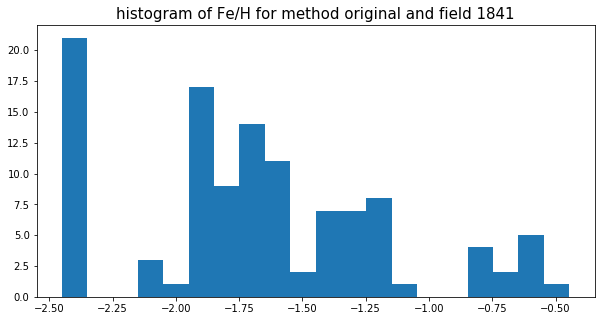

metallicity for iso method: -1.4478302191604266


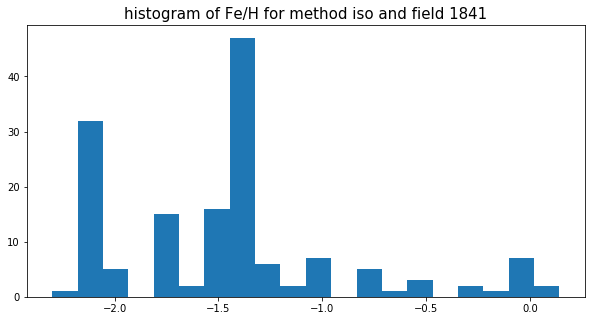

metallicity for iso_cut method: -1.6191754812624917


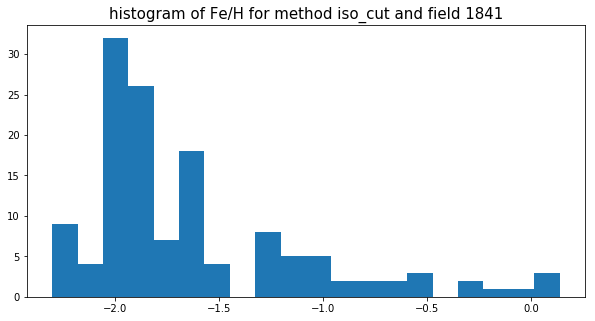

metallicity for shift method: -1.7617355888852706


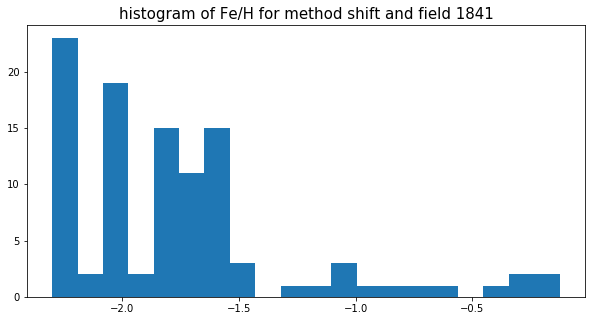

In [314]:
#selected = np.where(((g-i)>=.6)&((g-i)<=1)&(g>=17)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


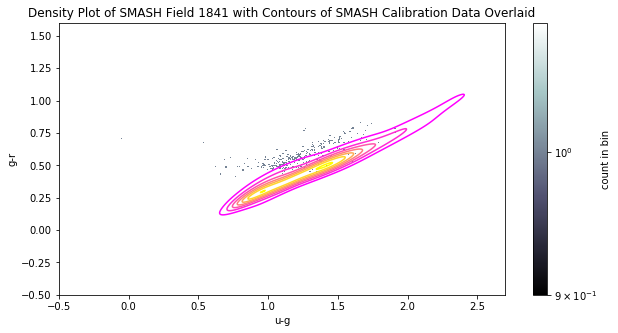

number of stars after cuts in field 1841: 277
metallicity for original method: -1.6432867066384598


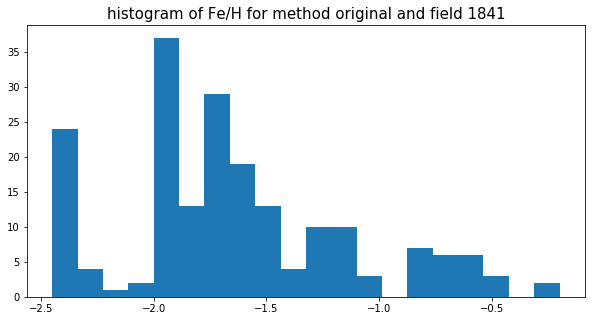

metallicity for iso method: -1.4139396396291208


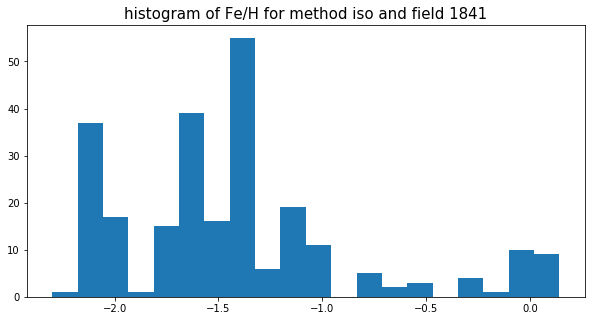

metallicity for iso_cut method: -1.534680250944666


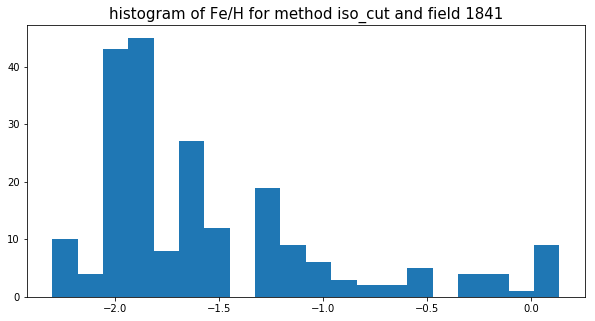

metallicity for shift method: -1.6803891870935084


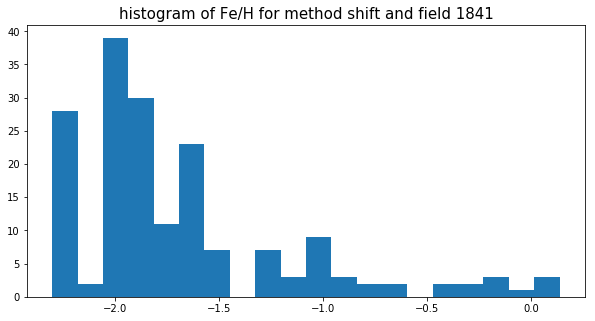

In [312]:
#selected = np.where(((g-i)>=.5)&((g-i)<=1)&(g>=17)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


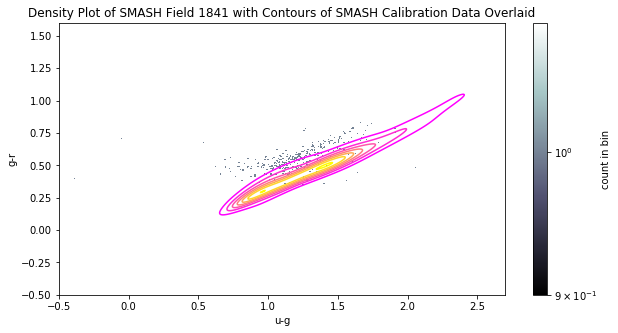

number of stars after cuts in field 1841: 328
metallicity for original method: -1.57997382786857


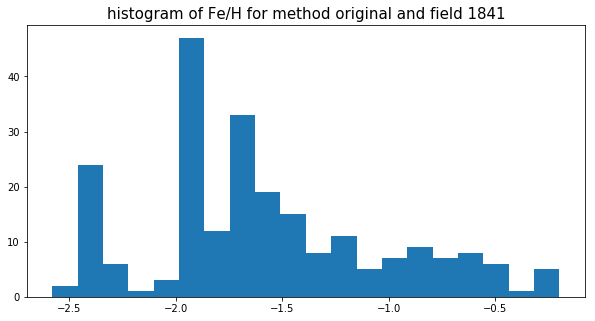

metallicity for iso method: -1.3395026211476408


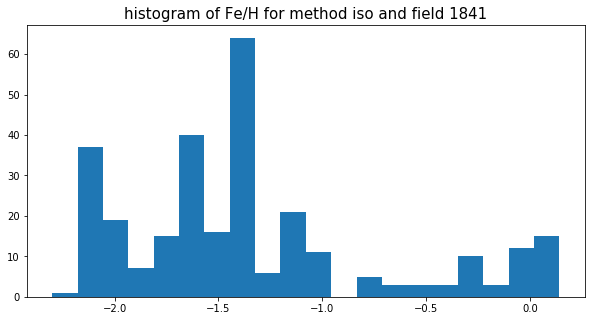

metallicity for iso_cut method: -1.4355677058696747


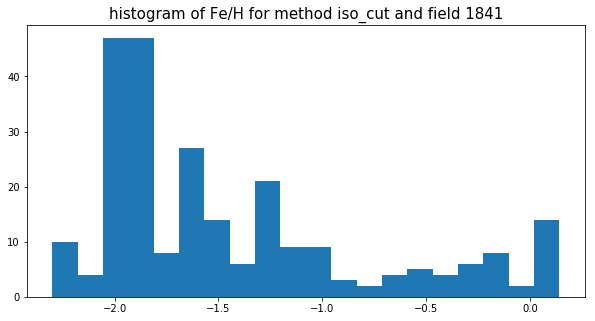

metallicity for shift method: -1.60287647987429


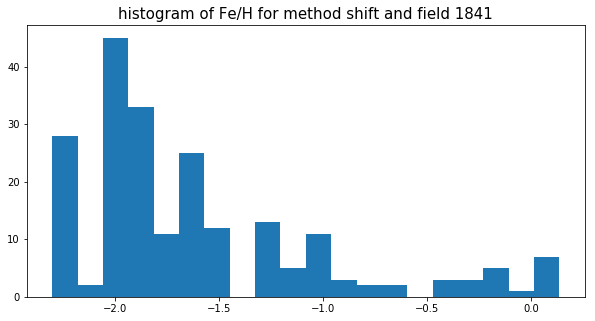

In [310]:
#selected = np.where(((g-i)>=.4)&((g-i)<=1)&(g>=17)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


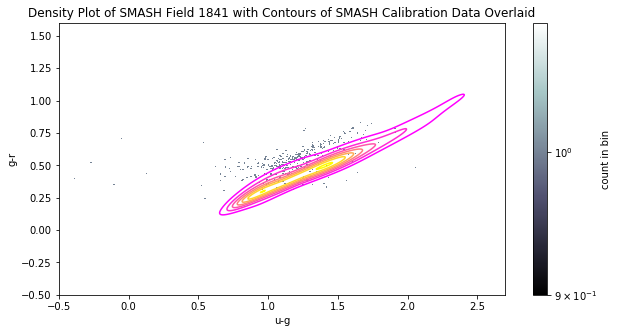

number of stars after cuts in field 1841: 363
metallicity for original method: -1.5391166664815816


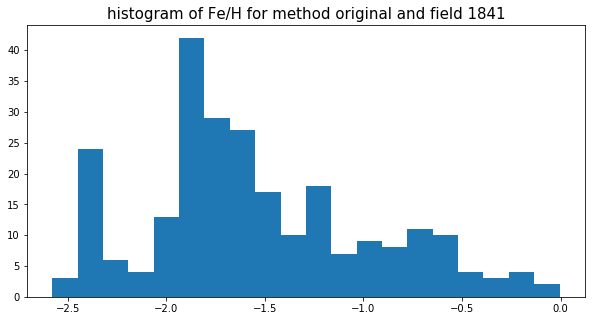

metallicity for iso method: -1.2909698171328894


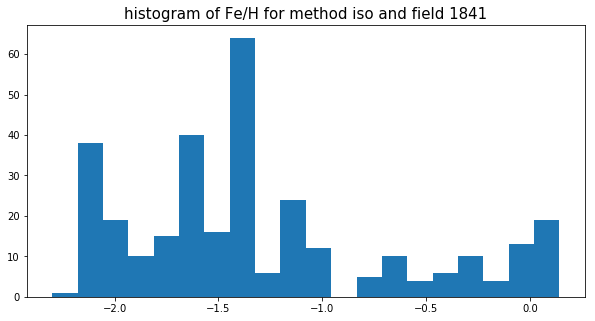

metallicity for iso_cut method: -1.3735428758156605


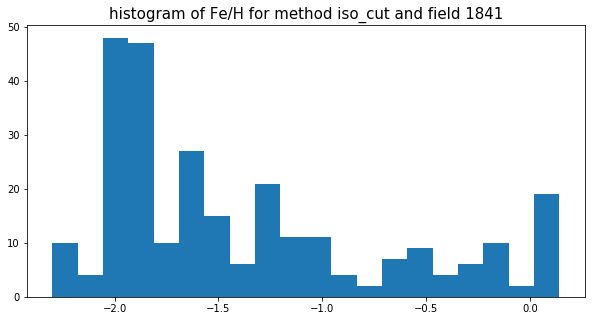

metallicity for shift method: -1.5347645845392655


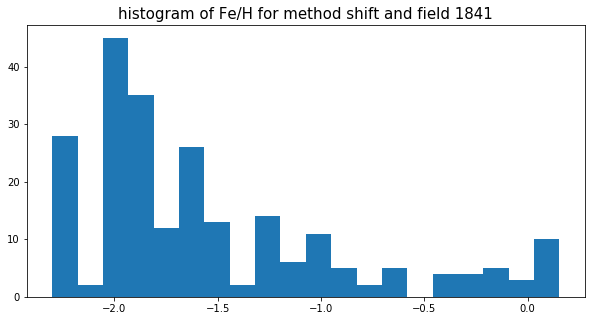

In [308]:
#selected = np.where(((g-i)>=.3)&((g-i)<=1)&(g>=17)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


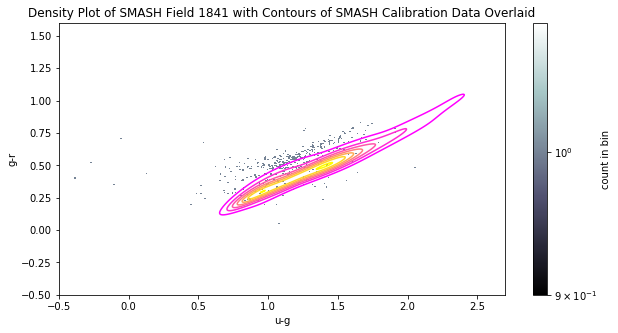

number of stars after cuts in field 1841: 400
metallicity for original method: -1.5176969600372343


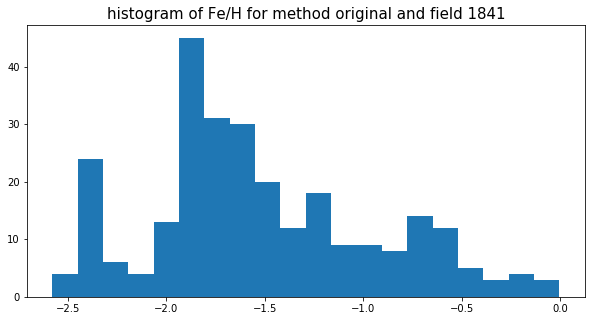

metallicity for iso method: -1.2612003592741972


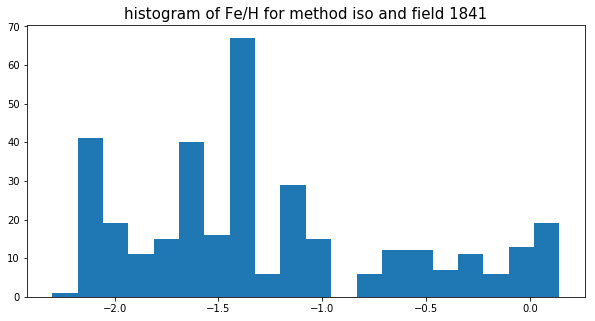

metallicity for iso_cut method: -1.3364769170515514


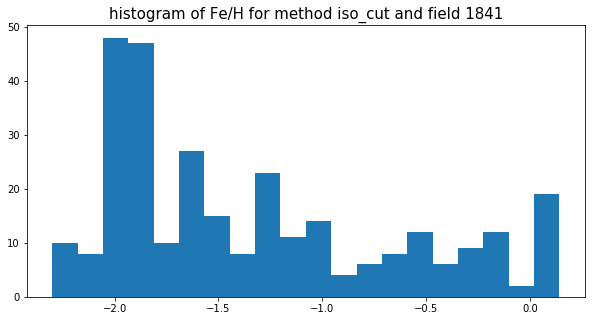

metallicity for shift method: -1.4668649733066559


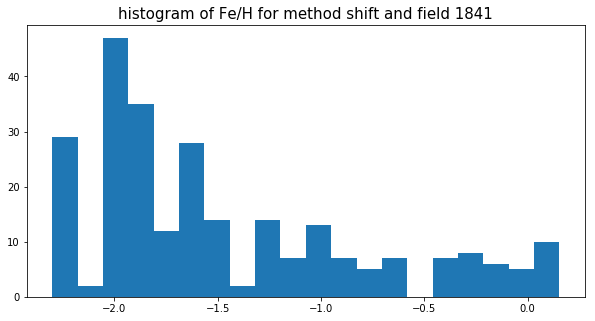

In [306]:
#selected = np.where(((g-i)>=.2)&((g-i)<=1)&(g>=17)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


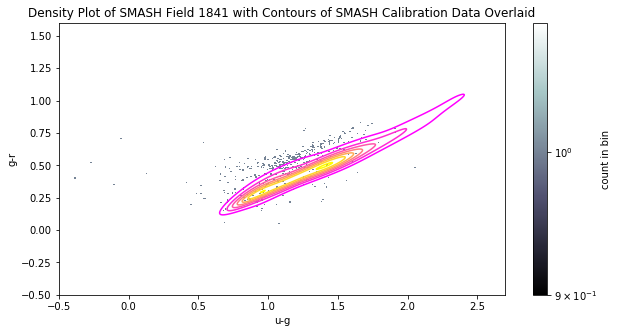

number of stars after cuts in field 1841: 424
metallicity for original method: -1.4967308487463091


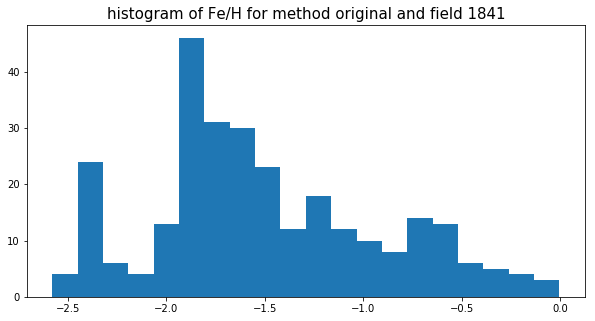

metallicity for iso method: -1.2554920222405548


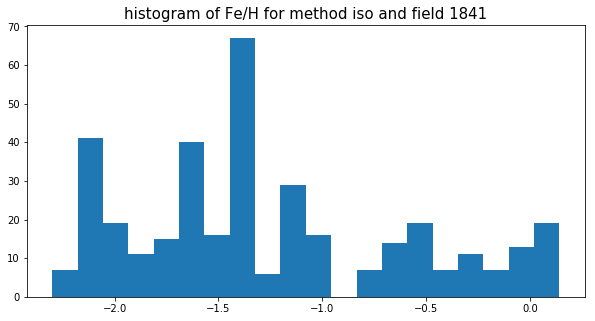

metallicity for iso_cut method: -1.317624230483535


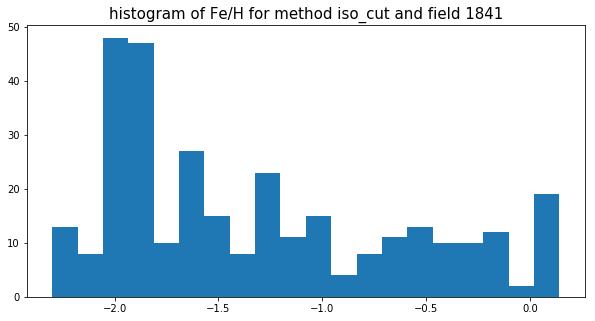

metallicity for shift method: -1.4314213630513868


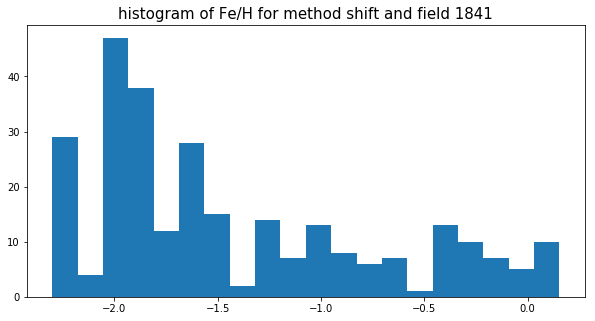

In [304]:
#selected = np.where(((g-i)>=.1)&((g-i)<=1)&(g>=17)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

number of initial stars in field 1841: 3405


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


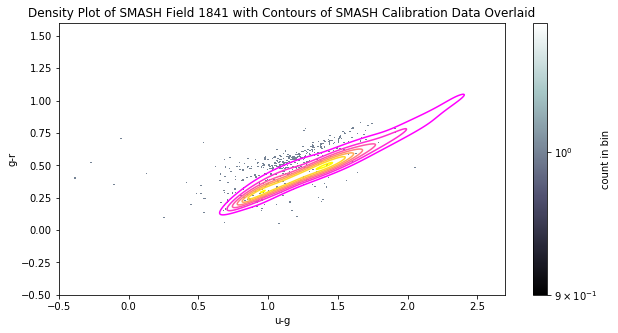

number of stars after cuts in field 1841: 433
metallicity for original method: -1.4919210285831332


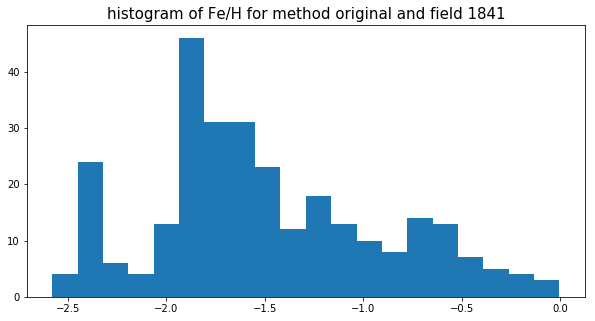

metallicity for iso method: -1.251750272091316


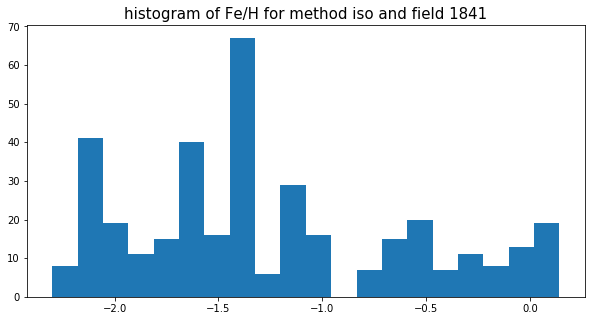

metallicity for iso_cut method: -1.3112933419480308


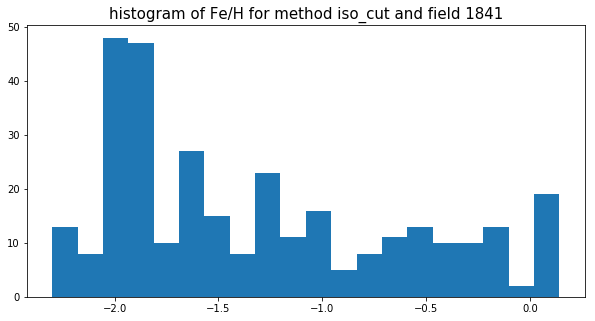

metallicity for shift method: -1.421855370274612


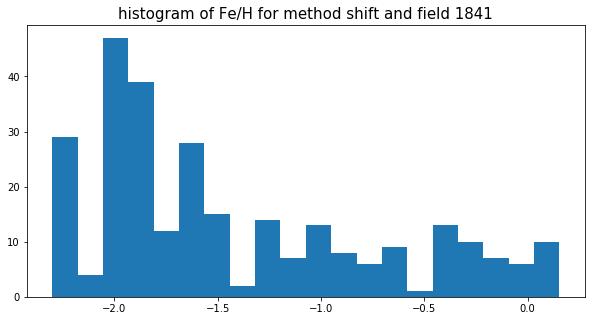

In [302]:
#selected = np.where(((g-i)>=0)&((g-i)<=1)&(g>=17)&(g<=21.9)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))

if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')